In [1]:
#! /usr/bin/python3

__author__ = "Jun Hu <jh3846@columbia.edu"
__date__ = "Apr 10, 2018"

import logging

logger = logging.getLogger('etl')
logger.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

formatter_c = logging.Formatter('[%(asctime)s]-[%(process)d]-[%(thread)d]-[%(name)s]-[%(lineno)s]-[%(levelname)s]: %(message)s')
ch.setFormatter(formatter_c)

logger.addHandler(ch)

import pandas as pd
import time
import json

from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from keras.models import Sequential
import keras.backend as K
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras import regularizers, optimizers
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# df1 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d1.pickle")
# df2 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d2.pickle")
# df3 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d3.pickle")
# df4 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d4.pickle")
# df5 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d5.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/junhu/Projects/bcr_data/d1.pickle'

In [3]:
df = pd.concat([df1, df2, df3, df4, df5], axis=1)
logger.debug(df.shape)
df.head()

[2018-04-25 10:18:55,248]-[22022]-[140735658623872]-[etl]-[2]-[DEBUG]: (4241, 17)


,cancer,unigram,bigram,trigram,four_gram,five_gram,six_gram,trigram_skip2,trigram_skip3,unigram_cls,bigram_cls,trigram_cls,four_gram_cls,five_gram_cls,six_gram_cls,trigram_cls_skip2,trigram_cls_skip3
0,THCA,D Y W G Q G R S D D T A V Y F C G D S P P F F ...,DY YW WG GQ QG RS SD DD DT TA AV VY YF FC GD D...,DYW YWG WGQ GQG RSD SDD DDT DTA TAV AVY VYF YF...,DYWG YWGQ WGQG RSDD SDDT DDTA DTAV TAVY AVYF V...,DYWGQ YWGQG RSDDT SDDTA DDTAV DTAVY TAVYF AVYF...,DYWGQG RSDDTA SDDTAV DDTAVY DTAVYF TAVYFC GDSP...,DWQ YGG RDT SDA DTV DAY TVF AYC GSP DPF SPF PF...,RTF SAC GPY DFW SFG PDQ PYG RTF SAC DVA DYR TF...,4 Y W G 5 G 6 3 4 4 3 1 1 Y F 2 G 4 3 P P F F ...,4Y YW WG G5 5G 63 34 44 43 31 11 1Y YF F2 G4 4...,4YW YWG WG5 G5G 634 344 443 431 311 11Y 1YF YF...,4YWG YWG5 WG5G 6344 3443 4431 4311 311Y 11YF 1...,4YWG5 YWG5G 63443 34431 44311 4311Y 311YF 11YF...,4YWG5G 634431 344311 44311Y 4311YF 311YF2 G43P...,4W5 YGG 643 341 431 41Y 31F 1Y2 G3P 4PF 3PF PF...,63F 312 GPY 4FW 3FG P45 PYG 63F 312 411 4Y6 3F...
1,LUSC,Y Y C A R G V V Y Y C A R V G Y Y Y D S S D Y ...,YY YC CA AR RG GV VV YY YC CA AR RV VG GY YY Y...,YYC YCA CAR ARG RGV GVV YYC YCA CAR ARV RVG VG...,YYCA YCAR CARG ARGV RGVV YYCA YCAR CARV ARVG R...,YYCAR YCARG CARGV ARGVV YYCAR YCARV CARVG ARVG...,YYCARG YCARGV CARGVV YYCARV YCARVG CARVGY ARVG...,YCR YAG CRV AGV YCR YAV CRG AVY RGY VYY GYD YY...,YRY YVY CGD AYS RYS VYD GDY YSP YSM YSL CLR AW...,Y Y 2 1 6 G 1 1 Y Y 2 1 6 1 G Y Y Y 4 3 3 4 Y ...,YY Y2 21 16 6G G1 11 YY Y2 21 16 61 1G GY YY Y...,YY2 Y21 216 16G 6G1 G11 YY2 Y21 216 161 61G 1G...,YY21 Y216 216G 16G1 6G11 YY21 Y216 2161 161G 6...,YY216 Y216G 216G1 16G11 YY216 Y2161 2161G 161G...,YY216G Y216G1 216G11 YY2161 Y2161G 2161GY 161G...,Y26 Y1G 261 1G1 Y26 Y11 26G 11Y 6GY 1YY GY4 YY...,Y6Y Y1Y 2G4 1Y3 6Y3 1Y4 G4Y Y3P Y32 Y31 216 1W...
2,OV,R E H S S S S W Y F D Y W G Q G Y Y C A R H E ...,RE EH HS SS SS SS SW WY YF FD DY YW WG GQ QG Y...,REH EHS HSS SSS SSS SSW SWY WYF YFD FDY DYW YW...,REHS EHSS HSSS SSSS SSSW SSWY SWYF WYFD YFDY F...,REHSS EHSSS HSSSS SSSSW SSSWY SSWYF SWYFD WYFD...,REHSSS EHSSSS HSSSSW SSSSWY SSSWYF SSWYFD SWYF...,RHS ESS HSS SSW SSY SWF SYD WFY YDW FYG DWQ YG...,RSY ESF HSD SWY SYW SFG SDQ WYG YRG YHQ CES AD...,6 4 6 3 3 3 3 W Y F 4 Y W G 5 G Y Y 2 1 6 6 4 ...,64 46 63 33 33 33 3W WY YF F4 4Y YW WG G5 5G Y...,646 463 633 333 333 33W 3WY WYF YF4 F4Y 4YW YW...,6463 4633 6333 3333 333W 33WY 3WYF WYF4 YF4Y F...,64633 46333 63333 3333W 333WY 33WYF 3WYF4 WYF4...,646333 463333 63333W 3333WY 333WYF 33WYF4 3WYF...,663 433 633 33W 33Y 3WF 3Y4 WFY Y4W FYG 4W5 YG...,63Y 43F 634 3WY 3YW 3FG 345 WYG Y6G Y65 243 14...
3,COAD,D Y Y F D Y W G Q G Y Y C A R E P N G P A Y Y ...,DY YY YF FD DY YW WG GQ QG YY YC CA AR RE EP P...,DYY YYF YFD FDY DYW YWG WGQ GQG YYC YCA CAR AR...,DYYF YYFD YFDY FDYW DYWG YWGQ WGQG YYCA YCAR C...,DYYFD YYFDY YFDYW FDYWG DYWGQ YWGQG YYCAR YCAR...,DYYFDY YYFDYW YFDYWG FDYWGQ DYWGQG YYCARE YCAR...,DYD YFY YDW FYG DWQ YGG YCR YAE CRP AEN RPG EN...,DDQ YYG YRG YEP AYV YGW YMG YDQ YVG DYK TYE AY...,4 Y Y F 4 Y W G 5 G Y Y 2 1 6 4 P 5 G P 1 Y Y ...,4Y YY YF F4 4Y YW WG G5 5G YY Y2 21 16 64 4P P...,4YY YYF YF4 F4Y 4YW YWG WG5 G5G YY2 Y21 216 16...,4YYF YYF4 YF4Y F4YW 4YWG YWG5 WG5G YY21 Y216 2...,4YYF4 YYF4Y YF4YW F4YWG 4YWG5 YWG5G YY216 Y216...,4YYF4Y YYF4YW YF4YWG F4YWG5 4YWG5G YY2164 Y216...,4Y4 YFY Y4W FYG 4W5 YGG Y26 Y14 26P 145 6PG 45...,445 YYG Y6G Y4P 1Y1 YGW Y2G Y45 Y1G 4Y6 3Y4 1Y...
4,THCA,Y S S G S T L D Y W G Q G Y Y Y G M D V W G Q ...,YS SS SG GS ST TL LD DY YW WG GQ QG YY YY YG G...,YSS SSG SGS GST STL TLD LDY DYW YWG WGQ GQG YY...,YSSG SSGS SGST GSTL STLD TLDY LDYW DYWG YWGQ W...,YSSGS SSGST SGSTL GSTLD STLDY TLDYW LDYWG DYWG...,YSSGST SSGSTL SGSTLD GSTLDY STLDYW TLDYWG LDYW...,YSS SGT SSL GTD SLY TDW LYG DWQ YGG YYM YGD YM...,YSY STW SLG GDQ SYG YMG YDQ YVG EYV TGW NMG YD...,Y 3 3 G 3 3 1 4 Y W G 5 G Y Y Y G 2 4 1 W G 5 ...,Y3 33 3G G3 33 31 14 4Y YW WG G5 5G YY YY YG G...,Y33 33G 3G3 G33 331 314 14Y 4YW YWG WG5 G5G YY...,Y33G 33G3 3G33 G3

In [5]:
start_time = time.time()

df_vec4000 = df.copy()
max_features = 4000

# ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')

for i in range(1, 17):
    start_time1 = time.time()
    df_vec4000.iloc[:, i] = tfidf.fit_transform(df_vec4000.iloc[:, i]).toarray().tolist()
    logger.debug("--- %s seconds ---" % (time.time() - start_time1))
logger.debug("--- %s seconds ---" % (time.time() - start_time))
df_vec4000.to_pickle("/Users/junhu/Projects/bcr_data/df_vec4000.pickle")



[2018-04-25 11:15:19,699]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 76.75185108184814 seconds ---


[2018-04-25 11:16:53,194]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 93.47376084327698 seconds ---


[2018-04-25 11:18:36,356]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 103.15917897224426 seconds ---


[2018-04-25 11:20:43,553]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 127.19161915779114 seconds ---


[2018-04-25 11:23:21,043]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 157.48258709907532 seconds ---


[2018-04-25 11:29:04,863]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 343.8124759197235 seconds ---


[2018-04-25 11:30:59,281]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 114.41038990020752 seconds ---


[2018-04-25 11:32:18,341]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 79.0519049167633 seconds ---


[2018-04-25 11:33:58,489]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 100.13671517372131 seconds ---


[2018-04-25 11:36:10,731]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 132.23745489120483 seconds ---


[2018-04-25 11:38:15,154]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 124.40299201011658 seconds ---


[2018-04-25 11:43:27,356]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 312.19010305404663 seconds ---


[2018-04-25 11:45:54,839]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 147.4755940437317 seconds ---


[2018-04-25 11:48:23,592]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 148.74259400367737 seconds ---


[2018-04-25 11:50:03,558]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 99.95715475082397 seconds ---


[2018-04-25 11:50:57,879]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 54.31193494796753 seconds ---


[2018-04-25 11:50:57,915]-[22022]-[140735658623872]-[etl]-[13]-[DEBUG]: --- 2261.245082139969 seconds ---


In [5]:
# start_time = time.time()
# 
# df_vec10000 = df.copy()
# max_features = 10000
# 
# # ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
# tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')
# 
# for i in range(1, 17):
#     start_time1 = time.time()
#     df_vec10000.iloc[:, i] = tfidf.fit_transform(df_vec10000.iloc[:, i]).toarray().tolist()
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# logger.debug("--- %s seconds ---" % (time.time() - start_time))
# 
# df_vec10000.to_pickle(r"F:\courses\bcr_data\df_vec10000.pickle")

[2018-04-24 19:54:01,722]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 75.05780625343323 seconds ---


[2018-04-24 19:55:24,654]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 82.93081402778625 seconds ---


[2018-04-24 19:56:46,521]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 81.864905834198 seconds ---


[2018-04-24 19:58:21,999]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 95.47649383544922 seconds ---


[2018-04-24 20:05:33,854]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 431.85456562042236 seconds ---


[2018-04-24 20:15:45,171]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 611.3135178089142 seconds ---


[2018-04-24 20:19:55,574]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 250.4016752243042 seconds ---


[2018-04-24 20:21:05,720]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 70.14262890815735 seconds ---


[2018-04-24 21:02:35,201]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 2489.479713201523 seconds ---


[2018-04-24 21:07:49,722]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 314.5038962364197 seconds ---


[2018-04-24 21:12:28,719]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 278.69273853302 seconds ---


[2018-04-24 21:15:17,014]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 168.2946493625641 seconds ---


[2018-04-24 21:19:15,221]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 238.20289039611816 seconds ---


[2018-04-24 21:22:05,068]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 169.8456814289093 seconds ---


[2018-04-24 21:26:50,152]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 285.0818667411804 seconds ---


[2018-04-24 21:27:51,585]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 61.430301904678345 seconds ---


[2018-04-24 21:27:51,591]-[5244]-[8988]-[etl]-[13]-[DEBUG]: --- 5704.9492337703705 seconds ---


In [4]:
# start_time = time.time()
# 
# df_model = df.copy()
# 
# df_model["all_features_str"] = df_model.iloc[:, 1]
# for i in range(0, 17):
#     start_time1 = time.time()
#     df_model["all_features_str"] = df_model["all_features_str"] + df_model.iloc[:, i]
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# max_features = 100
# 
# # ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
# for max_features in range(2000, 10000, 2000):
#     start_time1 = time.time()
#     tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')
#     df_model.iloc["all_features_{}".format(max_features)] = tfidf.fit_transform(df_model.all_features_str).toarray().tolist()
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# 
# # for i in range(1, 17):
# # #     start_time1 = time.time()
# # #     df_vec100.iloc[:, i] = tfidf.fit_transform(df_vec100.iloc[:, i]).toarray().tolist()
# # #     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# logger.debug("--- %s seconds ---" % (time.time() - start_time))
# # df_vec100.to_pickle(r"F:\courses\bcr_data\df_vec100.pickle")

[2018-04-25 10:19:39,950]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 2.0253171920776367 seconds ---


[2018-04-25 10:19:41,113]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 1.1623561382293701 seconds ---


[2018-04-25 10:19:47,738]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 6.623291015625 seconds ---


[2018-04-25 10:19:57,229]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 9.484586000442505 seconds ---


[2018-04-25 10:20:10,414]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 13.177716970443726 seconds ---


[2018-04-25 10:20:36,685]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 26.264261960983276 seconds ---


[2018-04-25 10:21:22,849]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 46.155609130859375 seconds ---


[2018-04-25 10:22:16,324]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 53.46981191635132 seconds ---


[2018-04-25 10:23:17,817]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 61.47909927368164 seconds ---


[2018-04-25 10:24:19,292]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 61.46058201789856 seconds ---


[2018-04-25 10:25:40,509]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 81.20649719238281 seconds ---


[2018-04-25 10:27:17,392]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 96.87248730659485 seconds ---


[2018-04-25 10:29:09,584]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 112.18130588531494 seconds ---


[2018-04-25 10:31:35,751]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 146.14876890182495 seconds ---


[2018-04-25 10:34:38,531]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 182.76044702529907 seconds ---


[2018-04-25 10:38:05,329]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 206.78540229797363 seconds ---


[2018-04-25 10:42:14,142]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 248.7958903312683 seconds ---


ValueError: Can only index by location with a [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array]

In [2]:
# summarize history for loss
def plot_loss(name):
    plt.clf()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('{} model loss'.format(name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_{}'.format(name), 'validation_{}'.format(name)], loc='upper left')
    plt.savefig('loss_{}.png'.format(name))
    # plt.show()

# summarize history for acc
def plot_acc(name):
    plt.clf()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('{} model accuracy'.format(name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_{}'.format(name), 'validation_{}'.format(name)], loc='upper left')
    plt.savefig('acc_{}.png'.format(name))
    # plt.show()

In [3]:
df_model = pd.read_pickle(r"F:\courses\bcr_data\df_vec1000.pickle")
# df_model = df_vec4000

In [5]:
list(df_model)

['cancer',
 'unigram',
 'bigram',
 'trigram',
 'four_gram',
 'five_gram',
 'six_gram',
 'trigram_skip2',
 'trigram_skip3',
 'unigram_cls',
 'bigram_cls',
 'trigram_cls',
 'four_gram_cls',
 'five_gram_cls',
 'six_gram_cls',
 'trigram_cls_skip2',
 'trigram_cls_skip3']

In [12]:
df_model.trigram.head()

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.009818492303147356, 0.004681952388355721, 0...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.009125448830371545...
3    [0.0035005329367748233, 0.002364743457575376, ...
4    [0.006617782043635309, 0.0037902608464007045, ...
Name: trigram, dtype: object

In [4]:
with open("ward_cluster_50_percentage_list.json") as f:
    data_origin = json.load(f)

df_clustering = pd.DataFrame(data_origin)

In [16]:
df_clustering.head()

,data
0,"{'42': 0.945179584120983, '43': 2.268431001890..."
1,"{'42': 1.6477457022380797, '48': 0.34382095361..."
2,"{'42': 0.35545023696682465, '48': 1.0071090047..."
3,"{'42': 1.5090230242688238, '48': 0.28002489110..."
4,"{'42': 1.533853395214114, '48': 0.144827359204..."


In [18]:
df_clustering.shape

(4241, 1)

In [5]:
def dict2list(dict):
    res = []
    for i in range(50):
        if str(i) in dict:
            res.append(dict[str(i)] / 100)
        else:
            res.append(0)
    return res

In [6]:
df_clustering["clustering"] = df_clustering.data.map(lambda x: dict2list(x))

In [26]:
df_clustering.head()

,data,clustering
0,"{'42': 0.945179584120983, '43': 2.268431001890...","[0.001890359168241966, 0.00945179584120983, 0...."
1,"{'42': 1.6477457022380797, '48': 0.34382095361...","[0.00454103146286085, 0.004735647096983458, 0...."
2,"{'42': 0.35545023696682465, '48': 1.0071090047...","[0, 0.004146919431279621, 0.045616113744075835..."
3,"{'42': 1.5090230242688238, '48': 0.28002489110...","[0.004355942750466708, 0.005133789670192906, 0..."
4,"{'42': 1.533853395214114, '48': 0.144827359204...","[0.0018103419900595767, 0.002699055330634278, ..."


In [7]:
with open("bcr_project_data.json") as f:
    data_origin = json.load(f)

df_origin = pd.DataFrame(data_origin)
df_origin.head()

,BCR,EVENT,OS,age,cancer
0,"[[DYWGQG, NA], [RSDDTAVYFC, NA], [GDSPPFFDYWGQ...",living,389,31.0,THCA
1,"[[YYCARGVV, NA], [YYCARVGYYYDSSDYP, NA], [FNHW...",living,482,74.0,LUSC
2,"[[REHSSSSWYFDYWGQG, NA], [YYCARHEDGQSK, NA], [...",living,3388,70.0,OV
3,"[[DYYFDYWGQG, NA], [YYCAREPNGP, NA], [AYYYYGMD...",living,1419,82.0,COAD
4,"[[YSSGSTLDYWGQG, IGHG3], [YYYGMDVWGQG, NA], [E...",living,726,55.0,THCA


In [8]:
def digiEVENT(str):
    if str == "living":
        return 1
    else:
        return 0
df_origin["event"] = df_origin.EVENT.map(lambda x: digiEVENT(x))
df_origin.fillna(62, inplace=True)

df_origin.describe()

,OS,age,event
count,4241.000000,4241.000000,4241.000000
mean,1041.745815,61.668239,0.668003
std,910.424916,12.720973,0.470986
min,1.000000,15.000000,0.000000
25%,405.000000,54.000000,0.000000
50%,761.000000,62.000000,1.000000
75%,1424.000000,71.000000,1.000000
max,4992.000000,90.000000,1.000000


In [73]:

C = np.array(list(df_model.cancer))


encoder = LabelEncoder()
encoder.fit(C)
encoder_C = encoder.transform(C)
dummy_C = np_utils.to_categorical(encoder_C)

def toList(n):
    x = []
    x.append(n)
    return x

def toList2(n):
    return list(n)

def ageSec(n):
    if n < 35:
        return [0,0,1]
    elif n < 75:
        return [0,1,0]
    else:
        return [1,0,0]
    
def osSec(n):
    if n < 100:
        return [0,0,0,0,1]
    elif n < 300:
        return [0,0,0,1,0]
    elif n < 600:
        return [0,0,1,0,0]
    elif n < 1200:
        return [0,1,0,0,0]
    else:
        return [1,0,0,0,0]
    
df_origin["cs"] = pd.Series(list(dummy_C))
df_origin["agel"] = df_origin.age.map(lambda x: ageSec(x))
df_origin["os"] = df_origin.OS.map(lambda x: osSec(x))

df_origin["cs"] = df_origin.cs.map(lambda x: toList2(x))

df_origin.head()



,BCR,EVENT,OS,age,cancer,event,cs,agel,os
0,"[[DYWGQG, NA], [RSDDTAVYFC, NA], [GDSPPFFDYWGQ...",living,389,31.0,THCA,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 1]","[0, 0, 1, 0, 0]"
1,"[[YYCARGVV, NA], [YYCARVGYYYDSSDYP, NA], [FNHW...",living,482,74.0,LUSC,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0, 1, 0]","[0, 0, 1, 0, 0]"
2,"[[REHSSSSWYFDYWGQG, NA], [YYCARHEDGQSK, NA], [...",living,3388,70.0,OV,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 1, 0]","[1, 0, 0, 0, 0]"
3,"[[DYYFDYWGQG, NA], [YYCAREPNGP, NA], [AYYYYGMD...",living,1419,82.0,COAD,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0]","[1, 0, 0, 0, 0]"
4,"[[YSSGSTLDYWGQG, IGHG3], [YYYGMDVWGQG, NA], [E...",living,726,55.0,THCA,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1, 0]","[0, 1, 0, 0, 0]"


[2018-05-10 02:17:34,863]-[12076]-[9580]-[etl]-[41]-[DEBUG]: 16


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              17000     
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1001      
Total params: 3,021,001
Trainable params: 3,021,001
Non-trainable params: 0
_________________________________________________________________


Train on 848 samples, validate on 3393 samples
Epoch 1/500


848/848 [==============================] - 1s 725us/step - loss: 0.6929 - acc: 0.4965 - val_loss: 0.6858 - val_acc: 0.6670


Epoch 2/500
848/848 [==============================] - 0s 42us/step - loss: 0.6851 - acc: 0.6733 - val_loss: 0.6779 - val_acc: 0.6670


Epoch 3/500
848/848 [==============================] - 0s 41us/step - loss: 0.6773 - acc: 0.6722 - val_loss: 0.6703 - val_acc: 0.6670


Epoch 4/500
848/848 [==============================] - 0s 41us/step - loss: 0.6692 - acc: 0.6722 - val_loss: 0.6630 - val_acc: 0.6670


Epoch 5/500
848/848 [==============================] - 0s 43us/step - loss: 0.6617 - acc: 0.6722 - val_loss: 0.6561 - val_acc: 0.6670


Epoch 6/500


848/848 [==============================] - 0s 42us/step - loss: 0.6544 - acc: 0.6722 - val_loss: 0.6496 - val_acc: 0.6670


Epoch 7/500
848/848 [==============================] - 0s 40us/step - loss: 0.6477 - acc: 0.6722 - val_loss: 0.6434 - val_acc: 0.6670


Epoch 8/500


848/848 [==============================] - 0s 42us/step - loss: 0.6408 - acc: 0.6722 - val_loss: 0.6377 - val_acc: 0.6670


Epoch 9/500


848/848 [==============================] - 0s 42us/step - loss: 0.6348 - acc: 0.6722 - val_loss: 0.6326 - val_acc: 0.6670


Epoch 10/500
848/848 [==============================] - 0s 42us/step - loss: 0.6296 - acc: 0.6722 - val_loss: 0.6281 - val_acc: 0.6670


Epoch 11/500


848/848 [==============================] - 0s 43us/step - loss: 0.6248 - acc: 0.6722 - val_loss: 0.6244 - val_acc: 0.6670


Epoch 12/500


848/848 [==============================] - 0s 39us/step - loss: 0.6208 - acc: 0.6722 - val_loss: 0.6214 - val_acc: 0.6670


Epoch 13/500
848/848 [==============================] - 0s 39us/step - loss: 0.6171 - acc: 0.6722 - val_loss: 0.6189 - val_acc: 0.6670


Epoch 14/500


848/848 [==============================] - 0s 42us/step - loss: 0.6142 - acc: 0.6722 - val_loss: 0.6166 - val_acc: 0.6670


Epoch 15/500


848/848 [==============================] - 0s 41us/step - loss: 0.6125 - acc: 0.6722 - val_loss: 0.6142 - val_acc: 0.6670


Epoch 16/500
848/848 [==============================] - 0s 37us/step - loss: 0.6091 - acc: 0.6722 - val_loss: 0.6114 - val_acc: 0.6670


Epoch 17/500


848/848 [==============================] - 0s 41us/step - loss: 0.6065 - acc: 0.6722 - val_loss: 0.6081 - val_acc: 0.6670


Epoch 18/500


848/848 [==============================] - 0s 41us/step - loss: 0.6024 - acc: 0.6722 - val_loss: 0.6043 - val_acc: 0.6670


Epoch 19/500
848/848 [==============================] - 0s 43us/step - loss: 0.5992 - acc: 0.6722 - val_loss: 0.6001 - val_acc: 0.6670


Epoch 20/500


848/848 [==============================] - 0s 43us/step - loss: 0.5936 - acc: 0.6722 - val_loss: 0.5957 - val_acc: 0.6670


Epoch 21/500


848/848 [==============================] - 0s 38us/step - loss: 0.5899 - acc: 0.6722 - val_loss: 0.5914 - val_acc: 0.6670


Epoch 22/500


848/848 [==============================] - 0s 41us/step - loss: 0.5850 - acc: 0.6722 - val_loss: 0.5873 - val_acc: 0.6670


Epoch 23/500
848/848 [==============================] - 0s 38us/step - loss: 0.5811 - acc: 0.6722 - val_loss: 0.5835 - val_acc: 0.6670


Epoch 24/500


848/848 [==============================] - 0s 40us/step - loss: 0.5769 - acc: 0.6722 - val_loss: 0.5798 - val_acc: 0.6670


Epoch 25/500


848/848 [==============================] - 0s 37us/step - loss: 0.5734 - acc: 0.6722 - val_loss: 0.5762 - val_acc: 0.6670


Epoch 26/500


848/848 [==============================] - 0s 40us/step - loss: 0.5696 - acc: 0.6722 - val_loss: 0.5726 - val_acc: 0.6670


Epoch 27/500


848/848 [==============================] - 0s 47us/step - loss: 0.5659 - acc: 0.6722 - val_loss: 0.5690 - val_acc: 0.6705


Epoch 28/500


848/848 [==============================]

 - 0s 39us/step - loss: 0.5618 - acc: 0.6745 - val_loss: 0.5653 - val_acc: 0.6705


Epoch 29/500


848/848 [==============================] - 0s 38us/step - loss: 0.5575 - acc: 0.6757 - val_loss: 0.5616 - val_acc: 0.6714


Epoch 30/500


848/848 [==============================] - 0s 40us/step - loss: 0.5538 - acc: 0.6828 - val_loss: 0.5582 - val_acc: 0.6885


Epoch 31/500
848/848 [==============================] - 0s 41us/step - loss: 0.5488 - acc: 0.6934 - val_loss: 0.5551 - val_acc: 0.6885


Epoch 32/500


848/848 [==============================] - 0s 40us/step - loss: 0.5460 - acc: 0.6969 - val_loss: 0.5523 - val_acc: 0.6932


Epoch 33/500


848/848 [==============================] - 0s 40us/step - loss: 0.5428 - acc: 0.7064 - val_loss: 0.5499 - val_acc: 0.6944


Epoch 34/500


848/848 [==============================] - 0s 41us/step - loss: 0.5406 - acc: 0.7052 - val_loss: 0.5479 - val_acc: 0.6944


Epoch 35/500


848/848 [==============================] - 0s 41us/step - loss: 0.5374 - acc: 0.7075 - val_loss: 0.5462 - val_acc: 0.6944


Epoch 36/500


848/848 [==============================] - 0s 40us/step - loss: 0.5355 - acc: 0.7075 - val_loss: 0.5448 - val_acc: 0.6944


Epoch 37/500


848/848 [==============================] - 0s 40us/step - loss: 0.5326 - acc: 0.7075 - val_loss: 0.5440 - val_acc: 0.6944


Epoch 38/500


848/848 [==============================] - 0s 41us/step - loss: 0.5321 - acc: 0.7075 - val_loss: 0.5437 - val_acc: 0.6944


Epoch 39/500


848/848 [==============================] - 0s 38us/step - loss: 0.5308 - acc: 0.7075 - val_loss: 0.5437 - val_acc: 0.6944


Epoch 40/500


848/848 [==============================] - 0s 40us/step - loss: 0.5300 - acc: 0.7075 - val_loss: 0.5439 - val_acc: 0.6944


Epoch 41/500
848/848 [==============================] - 0s 40us/step - loss: 0.5290 - acc: 0.7075 - val_loss: 0.5441 - val_acc: 0.6944


Epoch 42/500


848/848 [==============================] - 0s 41us/step - loss: 0.5283 - acc: 0.7075 - val_loss: 0.5445 - val_acc: 0.6944


Epoch 43/500


848/848 [==============================] - 0s 41us/step - loss: 0.5282 - acc: 0.7075 - val_loss: 0.5451 - val_acc: 0.6944


Epoch 44/500


848/848 [==============================] - 0s 38us/step - loss: 0.5279 - acc: 0.7075 - val_loss: 0.5456 - val_acc: 0.6944


Epoch 45/500


848/848 [==============================] - 0s 38us/step - loss: 0.5277 - acc: 0.7075 - val_loss: 0.5460 - val_acc: 0.6944


Epoch 46/500


848/848 [==============================] - 0s 40us/step - loss: 0.5268 - acc: 0.7075 - val_loss: 0.5463 - val_acc: 0.6944


Epoch 47/500


848/848 [==============================] - 0s 38us/step - loss: 0.5278 - acc: 0.7064 - val_loss: 0.5466 - val_acc: 0.6941


Epoch 48/500


848/848 [==============================] - 0s 37us/step - loss: 0.5271 - acc: 0.7075 - val_loss: 0.5467 - val_acc: 0.6941


Epoch 49/500


848/848 [==============================] - 0s 40us/step - loss: 0.5274 - acc: 0.7087 - val_loss: 0.5467 - val_acc: 0.6941


Epoch 50/500


848/848 [==============================] - 0s 38us/step - loss: 0.5267 - acc: 0.7087 - val_loss: 0.5464 - val_acc: 0.6941


Epoch 51/500


848/848 [==============================] - 0s 36us/step - loss: 0.5267 - acc: 0.7087 - val_loss: 0.5462 - val_acc: 0.6941


Epoch 52/500


848/848 [==============================] - 0s 37us/step - loss: 0.5270 - acc: 0.7075 - val_loss: 0.5460 - val_acc: 0.6941


Epoch 53/500


848/848 [==============================] - 0s 42us/step - loss: 0.5254 - acc: 0.7075 - val_loss: 0.5458 - val_acc: 0.6941


Epoch 54/500


848/848 [==============================] - 0s 43us/step - loss: 0.5255 - acc: 0.7075 - val_loss: 0.5457 - val_acc: 0.6941


Epoch 55/500


848/848 [==============================] - 0s 42us/step - loss: 0.5260 - acc: 0.7099 - val_loss: 0.5456 - val_acc: 0.6941


Epoch 56/500


848/848 [==============================] - 0s 40us/step - loss: 0.5258 - acc: 0.7087 - val_loss: 0.5455 - val_acc: 0.6941


Epoch 57/500


848/848 [==============================] - 0s 40us/step - loss: 0.5255 - acc: 0.7087 - val_loss: 0.5454 - val_acc: 0.6941


Epoch 58/500


848/848 [==============================] - 0s 38us/step - loss: 0.5256 - acc: 0.7087 - val_loss: 0.5453 - val_acc: 0.6941


[2018-05-10 02:17:38,273]-[12076]-[9580]-[etl]-[74]-[DEBUG]: --- 3.4177513122558594 seconds ---


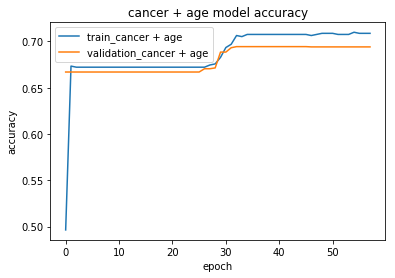

In [74]:

# df_model["all_features"] = df_model.iloc[:, 1]
# for i in range(6, 7):
#     df_model["all_features"] = df_model["all_features"] + df_model.iloc[:, i]


# df_model[
# "all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls + df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 + df_model.five_gram + df_model.six_gram + df_model.five_gram_cls + df_model.six_gram_cls

# df_model["all_features"] = df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 

# df_model["all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls

df_model["selected_features"] = df_origin.cs  + df_origin.agel 
features = [
    'unigram',
    'bigram',
    'trigram',
    'four_gram',
    'five_gram',
    'six_gram',
    'trigram_skip2',
    'trigram_skip3',
    'unigram_cls',
    'bigram_cls',
    'trigram_cls',
    'four_gram_cls',
    'five_gram_cls',
    'six_gram_cls',
    'trigram_cls_skip2',
    'trigram_cls_skip3',
    'all_features']

# for feature in features:

# df_model["selected_features"] = df_model.trigram 

start_time1 = time.time()

X = np.array(list(df_model["selected_features"])).astype(float)
logger.debug(len(X[0]))


dummy_y = np.array(list(df_origin["event"])).astype(float)
# logger.debug(dummy_y[0])

seed = 23
np.random.seed(23)
dim = len(X[0])

# , kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.0001)
K.clear_session()
model = Sequential()
model.add(Dense(1000, input_dim=dim, activation="relu"))
# model.add(Dropout(0.50))
model.add(Dense(1000, activation="relu"))
model.add(Dense(1000, activation="relu"))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.10))
model.add(Dense(1, activation="sigmoid"))
Adam = optimizers.adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=Adam, metrics=["accuracy"])
# plot_model(model, to_file="/model/model.png", show_shapes=True, show_layer_names=True)
model.summary()
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)
history = model.fit(X, dummy_y, validation_split=0.8, epochs=500, batch_size=1024, callbacks=[early_stop])

feature = "cancer + age"

plot_loss(feature)

plot_acc(feature)

logger.debug("--- %s seconds ---" % (time.time() - start_time1))



[2018-05-10 02:18:59,366]-[12076]-[9580]-[etl]-[41]-[DEBUG]: 1016


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              2034000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10005     
Total params: 10,048,005
Trainable params: 10,048,005
Non-trainable params: 0
_________________________________________________________________


Train on 2120 samples, validate on 2121 samples
Epoch 1/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1593 - acc: 0.3086

2120/2120 [==============================] - 1s 285us/step - loss: 0.1586 - acc: 0.2972 - val_loss: 0.1553 - val_acc: 0.3201


Epoch 2/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1550 - acc: 0.3252

2120/2120 [==============================] - 0s 73us/step - loss: 0.1549 - acc: 0.3274 - val_loss: 0.1521 - val_acc: 0.3461


Epoch 3/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1518 - acc: 0.3604

2120/2120 [==============================] - 0s 71us/step - loss: 0.1518 - acc: 0.3387 - val_loss: 0.1500 - val_acc: 0.3159


Epoch 4/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1493 - acc: 0.3184

2120/2120 [==============================] - 0s 75us/step - loss: 0.1500 - acc: 0.3085 - val_loss: 0.1490 - val_acc: 0.3352


Epoch 5/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1496 - acc: 0.3232

2120/2120 [==============================] - 0s 68us/step - loss: 0.1491 - acc: 0.3453 - val_loss: 0.1486 - val_acc: 0.3498


Epoch 6/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1492 - acc: 0.3535

2120/2120 [==============================] - 0s 66us/step - loss: 0.1487 - acc: 0.3571 - val_loss: 0.1486 - val_acc: 0.3484


Epoch 7/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1481 - acc: 0.3525

2120/2120 [==============================] - 0s 67us/step - loss: 0.1485 - acc: 0.3642 - val_loss: 0.1480 - val_acc: 0.3659


Epoch 8/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1482 - acc: 0.3701

2120/2120 [==============================] - 0s 67us/step - loss: 0.1480 - acc: 0.3651 - val_loss: 0.1475 - val_acc: 0.3663


Epoch 9/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1460 - acc: 0.3877

2120/2120 [==============================] - 0s 68us/step - loss: 0.1475 - acc: 0.3741 - val_loss: 0.1471 - val_acc: 0.3654


Epoch 10/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1440 - acc: 0.4004

2120/2120 [==============================] - 0s 68us/step - loss: 0.1469 - acc: 0.3708 - val_loss: 0.1469 - val_acc: 0.3706


Epoch 11/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1462 - acc: 0.3906

2120/2120 [==============================] - 0s 67us/step - loss: 0.1464 - acc: 0.3783 - val_loss: 0.1467 - val_acc: 0.3720


Epoch 12/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1464 - acc: 0.3672

2120/2120 [==============================] - 0s 67us/step - loss: 0.1462 - acc: 0.3830 - val_loss: 0.1465 - val_acc: 0.3753


Epoch 13/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1457 - acc: 0.3691

2120/2120 [==============================] - 0s 67us/step - loss: 0.1459 - acc: 0.3778 - val_loss: 0.1465 - val_acc: 0.3640


Epoch 14/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1452 - acc: 0.3838

2120/2120 [==============================] - 0s 67us/step - loss: 0.1457 - acc: 0.3759 - val_loss: 0.1463 - val_acc: 0.3682


Epoch 15/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1443 - acc: 0.3730

2120/2120 [==============================] - 0s 68us/step - loss: 0.1454 - acc: 0.3811 - val_loss: 0.1464 - val_acc: 0.3654


Epoch 16/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1451 - acc: 0.3789

2120/2120 [==============================] - 0s 67us/step - loss: 0.1455 - acc: 0.3731 - val_loss: 0.1463 - val_acc: 0.3635


Epoch 17/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1457 - acc: 0.3701

2120/2120 [==============================] - 0s 67us/step - loss: 0.1453 - acc: 0.3792 - val_loss: 0.1463 - val_acc: 0.3616


Epoch 18/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1436 - acc: 0.3896

2120/2120 [==============================] - 0s 67us/step - loss: 0.1456 - acc: 0.3774 - val_loss: 0.1465 - val_acc: 0.3621


Epoch 19/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1451 - acc: 0.3760

2120/2120 [==============================] - 0s 67us/step - loss: 0.1455 - acc: 0.3736 - val_loss: 0.1463 - val_acc: 0.3630


Epoch 20/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1458 - acc: 0.3701

2120/2120 [==============================] - 0s 68us/step - loss: 0.1451 - acc: 0.3849 - val_loss: 0.1465 - val_acc: 0.3645


Epoch 21/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1468 - acc: 0.3555

2120/2120 [==============================] - 0s 68us/step - loss: 0.1451 - acc: 0.3712 - val_loss: 0.1472 - val_acc: 0.3621


Epoch 22/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1447 - acc: 0.3770

2120/2120 [==============================] - 0s 67us/step - loss: 0.1455 - acc: 0.3726 - val_loss: 0.1469 - val_acc: 0.3645


Epoch 23/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1443 - acc: 0.3740

2120/2120 [==============================] - 0s 69us/step - loss: 0.1449 - acc: 0.3764 - val_loss: 0.1462 - val_acc: 0.3654


Epoch 24/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1433 - acc: 0.3984

2120/2120 [==============================] - 0s 70us/step - loss: 0.1448 - acc: 0.3797 - val_loss: 0.1464 - val_acc: 0.3725


Epoch 25/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1464 - acc: 0.3848

2120/2120 [==============================] - 0s 67us/step - loss: 0.1449 - acc: 0.3858 - val_loss: 0.1463 - val_acc: 0.3649


Epoch 26/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1451 - acc: 0.3877

2120/2120 [==============================] - 0s 69us/step - loss: 0.1445 - acc: 0.3858 - val_loss: 0.1466 - val_acc: 0.3687


Epoch 27/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1433 - acc: 0.3906

2120/2120 [==============================] - 0s 68us/step - loss: 0.1447 - acc: 0.3769 - val_loss: 0.1466 - val_acc: 0.3678


Epoch 28/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1427 - acc: 0.3926

2120/2120 [==============================] - 0s 68us/step - loss: 0.1444 - acc: 0.3830 - val_loss: 0.1463 - val_acc: 0.3649


Epoch 29/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1428 - acc: 0.3906

2120/2120 [==============================] - 0s 68us/step - loss: 0.1440 - acc: 0.3854 - val_loss: 0.1463 - val_acc: 0.3607


Epoch 30/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1440 - acc: 0.3848

2120/2120 [==============================] - 0s 68us/step - loss: 0.1442 - acc: 0.3939 - val_loss: 0.1464 - val_acc: 0.3602


Epoch 31/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1457 - acc: 0.3730

2120/2120 [==============================] - 0s 67us/step - loss: 0.1439 - acc: 0.3873 - val_loss: 0.1462 - val_acc: 0.3659


Epoch 32/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1418 - acc: 0.4131

2120/2120 [==============================] - 0s 67us/step - loss: 0.1439 - acc: 0.3906 - val_loss: 0.1464 - val_acc: 0.3621


Epoch 33/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1453 - acc: 0.3730

2120/2120 [==============================] - 0s 68us/step - loss: 0.1438 - acc: 0.3858 - val_loss: 0.1466 - val_acc: 0.3626


Epoch 34/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1445 - acc: 0.3701

2120/2120 [==============================] - 0s 68us/step - loss: 0.1437 - acc: 0.3868 - val_loss: 0.1466 - val_acc: 0.3640


Epoch 35/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1444 - acc: 0.3779

2120/2120 [==============================] - 0s 67us/step - loss: 0.1435 - acc: 0.3906 - val_loss: 0.1467 - val_acc: 0.3673


Epoch 36/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1430 - acc: 0.4043

2120/2120 [==============================] - 0s 65us/step - loss: 0.1433 - acc: 0.3925 - val_loss: 0.1465 - val_acc: 0.3630


Epoch 37/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1437 - acc: 0.3789

2120/2120 [==============================] - 0s 67us/step - loss: 0.1433 - acc: 0.3929 - val_loss: 0.1466 - val_acc: 0.3668


Epoch 38/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1436 - acc: 0.3926

2120/2120 [==============================] - 0s 67us/step - loss: 0.1431 - acc: 0.3906 - val_loss: 0.1469 - val_acc: 0.3574


Epoch 39/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1463 - acc: 0.3652

2120/2120 [==============================] - 0s 68us/step - loss: 0.1432 - acc: 0.3981 - val_loss: 0.1469 - val_acc: 0.3564


Epoch 40/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1427 - acc: 0.3896

2120/2120 [==============================] - 0s 66us/step - loss: 0.1428 - acc: 0.3953 - val_loss: 0.1467 - val_acc: 0.3673


Epoch 41/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1434 - acc: 0.3906

2120/2120 [==============================] - 0s 68us/step - loss: 0.1427 - acc: 0.3962 - val_loss: 0.1469 - val_acc: 0.3645


Epoch 42/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1417 - acc: 0.3945

2120/2120 [==============================] - 0s 72us/step - loss: 0.1428 - acc: 0.3854 - val_loss: 0.1465 - val_acc: 0.3659


Epoch 43/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1409 - acc: 0.4199

2120/2120 [==============================] - 0s 72us/step - loss: 0.1422 - acc: 0.4080 - val_loss: 0.1470 - val_acc: 0.3597


Epoch 44/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1422 - acc: 0.4238

2120/2120 [==============================] - 0s 69us/step - loss: 0.1428 - acc: 0.4156 - val_loss: 0.1472 - val_acc: 0.3574


Epoch 45/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1440 - acc: 0.4082

2120/2120 [==============================] - 0s 69us/step - loss: 0.1424 - acc: 0.4170 - val_loss: 0.1465 - val_acc: 0.3687


Epoch 46/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1422 - acc: 0.3936

2120/2120 [==============================] - 0s 70us/step - loss: 0.1420 - acc: 0.3986 - val_loss: 0.1471 - val_acc: 0.3588


Epoch 47/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1414 - acc: 0.3926

2120/2120 [==============================] - 0s 68us/step - loss: 0.1422 - acc: 0.3948 - val_loss: 0.1469 - val_acc: 0.3579


Epoch 48/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1413 - acc: 0.4121

2120/2120 [==============================] - 0s 68us/step - loss: 0.1416 - acc: 0.4090 - val_loss: 0.1464 - val_acc: 0.3659


Epoch 49/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1415 - acc: 0.4121

2120/2120 [==============================] - 0s 67us/step - loss: 0.1411 - acc: 0.4142 - val_loss: 0.1465 - val_acc: 0.3715


Epoch 50/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1401 - acc: 0.4199

2120/2120 [==============================] - 0s 68us/step - loss: 0.1409 - acc: 0.4302 - val_loss: 0.1468 - val_acc: 0.3635


Epoch 51/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1410 - acc: 0.4092

2120/2120 [==============================] - 0s 67us/step - loss: 0.1407 - acc: 0.4137 - val_loss: 0.1466 - val_acc: 0.3682


Epoch 52/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1414 - acc: 0.4287

2120/2120 [==============================] - 0s 68us/step - loss: 0.1403 - acc: 0.4302 - val_loss: 0.1466 - val_acc: 0.3612


Epoch 53/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1395 - acc: 0.4424

2120/2120 [==============================] - 0s 71us/step - loss: 0.1402 - acc: 0.4311 - val_loss: 0.1468 - val_acc: 0.3692


Epoch 54/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1386 - acc: 0.4443

2120/2120 [==============================] - 0s 69us/step - loss: 0.1400 - acc: 0.4302 - val_loss: 0.1469 - val_acc: 0.3696


Epoch 55/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1398 - acc: 0.4199

2120/2120 [==============================] - 0s 70us/step - loss: 0.1394 - acc: 0.4226 - val_loss: 0.1473 - val_acc: 0.3654


Epoch 56/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1418 - acc: 0.4072

2120/2120 [==============================] - 0s 70us/step - loss: 0.1405 - acc: 0.4160 - val_loss: 0.1471 - val_acc: 0.3668


Epoch 57/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1396 - acc: 0.4473

2120/2120 [==============================] - 0s 68us/step - loss: 0.1391 - acc: 0.4307 - val_loss: 0.1478 - val_acc: 0.3616


Epoch 58/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1376 - acc: 0.4590

2120/2120 [==============================] - 0s 71us/step - loss: 0.1389 - acc: 0.4377 - val_loss: 0.1473 - val_acc: 0.3612


Epoch 59/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1393 - acc: 0.4160

2120/2120 [==============================] - 0s 70us/step - loss: 0.1392 - acc: 0.4179 - val_loss: 0.1473 - val_acc: 0.3597


Epoch 60/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1363 - acc: 0.4287

2120/2120 [==============================] - 0s 68us/step - loss: 0.1376 - acc: 0.4292 - val_loss: 0.1482 - val_acc: 0.3593


Epoch 61/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1383 - acc: 0.4424

2120/2120 [==============================] - 0s 67us/step - loss: 0.1388 - acc: 0.4467 - val_loss: 0.1469 - val_acc: 0.3635


Epoch 62/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1352 - acc: 0.4521

2120/2120 [==============================] - 0s 69us/step - loss: 0.1376 - acc: 0.4311 - val_loss: 0.1485 - val_acc: 0.3612


Epoch 63/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1392 - acc: 0.4141

2120/2120 [==============================] - 0s 74us/step - loss: 0.1376 - acc: 0.4297 - val_loss: 0.1476 - val_acc: 0.3607


Epoch 64/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1349 - acc: 0.4619

2120/2120 [==============================] - 0s 68us/step - loss: 0.1360 - acc: 0.4533 - val_loss: 0.1476 - val_acc: 0.3602


Epoch 65/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1356 - acc: 0.4756

2120/2120 [==============================] - 0s 66us/step - loss: 0.1360 - acc: 0.4679 - val_loss: 0.1477 - val_acc: 0.3635


Epoch 66/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1350 - acc: 0.4609

2120/2120 [==============================] - 0s 71us/step - loss: 0.1350 - acc: 0.4642 - val_loss: 0.1478 - val_acc: 0.3621


Epoch 67/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1342 - acc: 0.4717

2120/2120 [==============================] - 0s 69us/step - loss: 0.1345 - acc: 0.4637 - val_loss: 0.1481 - val_acc: 0.3621


Epoch 68/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1332 - acc: 0.4629

2120/2120 [==============================] - 0s 76us/step - loss: 0.1340 - acc: 0.4642 - val_loss: 0.1477 - val_acc: 0.3649


Epoch 69/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1320 - acc: 0.4746

2120/2120 [==============================] - 0s 71us/step - loss: 0.1330 - acc: 0.4665 - val_loss: 0.1479 - val_acc: 0.3635


Epoch 70/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1332 - acc: 0.4512

2120/2120 [==============================] - 0s 70us/step - loss: 0.1332 - acc: 0.4637 - val_loss: 0.1487 - val_acc: 0.3602


Epoch 71/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1334 - acc: 0.4707

2120/2120 [==============================] - 0s 73us/step - loss: 0.1330 - acc: 0.4693 - val_loss: 0.1486 - val_acc: 0.3564


Epoch 72/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1316 - acc: 0.4844

2120/2120 [==============================] - 0s 68us/step - loss: 0.1316 - acc: 0.4887 - val_loss: 0.1482 - val_acc: 0.3635


Epoch 73/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1300 - acc: 0.4980

2120/2120 [==============================] - 0s 68us/step - loss: 0.1304 - acc: 0.4934 - val_loss: 0.1486 - val_acc: 0.3588


Epoch 74/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1291 - acc: 0.5176

2120/2120 [==============================] - 0s 70us/step - loss: 0.1298 - acc: 0.5019 - val_loss: 0.1500 - val_acc: 0.3347


Epoch 75/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1283 - acc: 0.4951

2120/2120 [==============================] - 0s 72us/step - loss: 0.1292 - acc: 0.5000 - val_loss: 0.1485 - val_acc: 0.3484


Epoch 76/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1281 - acc: 0.5107

2120/2120 [==============================] - 0s 71us/step - loss: 0.1275 - acc: 0.5146 - val_loss: 0.1507 - val_acc: 0.3371


Epoch 77/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1316 - acc: 0.4863

2120/2120 [==============================] - 0s 67us/step - loss: 0.1284 - acc: 0.5061 - val_loss: 0.1499 - val_acc: 0.3508


Epoch 78/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1268 - acc: 0.4834

2120/2120 [==============================] - 0s 69us/step - loss: 0.1267 - acc: 0.4925 - val_loss: 0.1500 - val_acc: 0.3583


Epoch 79/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1251 - acc: 0.5332

2120/2120 [==============================] - 0s 69us/step - loss: 0.1253 - acc: 0.5302 - val_loss: 0.1509 - val_acc: 0.3465


Epoch 80/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1252 - acc: 0.5430

2120/2120 [==============================] - 0s 68us/step - loss: 0.1255 - acc: 0.5377 - val_loss: 0.1500 - val_acc: 0.3583


Epoch 81/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1238 - acc: 0.5049

2120/2120 [==============================] - 0s 69us/step - loss: 0.1241 - acc: 0.5071 - val_loss: 0.1553 - val_acc: 0.3239


Epoch 82/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1241 - acc: 0.5186

2120/2120 [==============================] - 0s 67us/step - loss: 0.1271 - acc: 0.4943 - val_loss: 0.1514 - val_acc: 0.3428


Epoch 83/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1239 - acc: 0.5166

2120/2120 [==============================] - 0s 74us/step - loss: 0.1251 - acc: 0.5005 - val_loss: 0.1512 - val_acc: 0.3522


Epoch 84/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1200 - acc: 0.5518

2120/2120 [==============================] - 0s 68us/step - loss: 0.1218 - acc: 0.5316 - val_loss: 0.1505 - val_acc: 0.3522


Epoch 85/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1202 - acc: 0.5420

2120/2120 [==============================] - 0s 66us/step - loss: 0.1214 - acc: 0.5226 - val_loss: 0.1523 - val_acc: 0.3456


Epoch 86/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1228 - acc: 0.5088

2120/2120 [==============================] - 0s 66us/step - loss: 0.1205 - acc: 0.5335 - val_loss: 0.1555 - val_acc: 0.3197


Epoch 87/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1213 - acc: 0.5156

2120/2120 [==============================] - 0s 70us/step - loss: 0.1215 - acc: 0.5170 - val_loss: 0.1539 - val_acc: 0.3296


Epoch 88/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1224 - acc: 0.4961

2120/2120 [==============================] - 0s 69us/step - loss: 0.1190 - acc: 0.5429 - val_loss: 0.1524 - val_acc: 0.3329


Epoch 89/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1170 - acc: 0.5781

2120/2120 [==============================] - 0s 66us/step - loss: 0.1171 - acc: 0.5736 - val_loss: 0.1520 - val_acc: 0.3465


Epoch 90/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1126 - acc: 0.5840

2120/2120 [==============================] - 0s 68us/step - loss: 0.1150 - acc: 0.5693 - val_loss: 0.1551 - val_acc: 0.3479


Epoch 91/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1175 - acc: 0.5576

2120/2120 [==============================] - 0s 73us/step - loss: 0.1153 - acc: 0.5646 - val_loss: 0.1540 - val_acc: 0.3517


Epoch 92/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1132 - acc: 0.5742

2120/2120 [==============================] - 0s 69us/step - loss: 0.1171 - acc: 0.5415 - val_loss: 0.1544 - val_acc: 0.3390


Epoch 93/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1142 - acc: 0.5645

2120/2120 [==============================] - 0s 69us/step - loss: 0.1151 - acc: 0.5651 - val_loss: 0.1568 - val_acc: 0.3404


Epoch 94/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1167 - acc: 0.5518

2120/2120 [==============================] - 0s 68us/step - loss: 0.1149 - acc: 0.5627 - val_loss: 0.1525 - val_acc: 0.3489


Epoch 95/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1104 - acc: 0.6064

2120/2120 [==============================] - 0s 66us/step - loss: 0.1111 - acc: 0.6071 - val_loss: 0.1541 - val_acc: 0.3329


Epoch 96/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1139 - acc: 0.5625

2120/2120 [==============================] - 0s 69us/step - loss: 0.1119 - acc: 0.5741 - val_loss: 0.1549 - val_acc: 0.3371


Epoch 97/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1081 - acc: 0.6270

2120/2120 [==============================] - 0s 68us/step - loss: 0.1103 - acc: 0.6057 - val_loss: 0.1556 - val_acc: 0.3357


Epoch 98/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1079 - acc: 0.5879

2120/2120 [==============================] - 0s 70us/step - loss: 0.1081 - acc: 0.6014 - val_loss: 0.1566 - val_acc: 0.3489


Epoch 99/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1118 - acc: 0.5615

2120/2120 [==============================] - 0s 73us/step - loss: 0.1100 - acc: 0.5835 - val_loss: 0.1584 - val_acc: 0.3423


Epoch 100/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1093 - acc: 0.5840

2120/2120 [==============================] - 0s 68us/step - loss: 0.1088 - acc: 0.5887 - val_loss: 0.1553 - val_acc: 0.3489


Epoch 101/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1018 - acc: 0.6406

2120/2120 [==============================] - 0s 66us/step - loss: 0.1056 - acc: 0.6212 - val_loss: 0.1555 - val_acc: 0.3324


Epoch 102/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1052 - acc: 0.6230

2120/2120 [==============================] - 0s 69us/step - loss: 0.1049 - acc: 0.6156 - val_loss: 0.1562 - val_acc: 0.3395


Epoch 103/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1006 - acc: 0.6455

2120/2120 [==============================] - 0s 70us/step - loss: 0.1034 - acc: 0.6217 - val_loss: 0.1567 - val_acc: 0.3390


Epoch 104/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1002 - acc: 0.6445

2120/2120 [==============================] - 0s 67us/step - loss: 0.1049 - acc: 0.6160 - val_loss: 0.1582 - val_acc: 0.3371


Epoch 105/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1064 - acc: 0.5986

2120/2120 [==============================] - 0s 69us/step - loss: 0.1035 - acc: 0.6118 - val_loss: 0.1587 - val_acc: 0.3413


Epoch 106/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1007 - acc: 0.6230

2120/2120 [==============================] - 0s 66us/step - loss: 0.1013 - acc: 0.6278 - val_loss: 0.1581 - val_acc: 0.3286


Epoch 107/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1035 - acc: 0.6299

2120/2120 [==============================] - 0s 68us/step - loss: 0.1009 - acc: 0.6382 - val_loss: 0.1595 - val_acc: 0.3390


Epoch 108/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1012 - acc: 0.6152

2120/2120 [==============================] - 0s 68us/step - loss: 0.1002 - acc: 0.6245 - val_loss: 0.1592 - val_acc: 0.3357


Epoch 109/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.1007 - acc: 0.6357

2120/2120 [==============================] - 0s 66us/step - loss: 0.0992 - acc: 0.6462 - val_loss: 0.1612 - val_acc: 0.3446


Epoch 110/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0997 - acc: 0.6357

2120/2120 [==============================] - 0s 66us/step - loss: 0.1008 - acc: 0.6203 - val_loss: 0.1626 - val_acc: 0.3329


Epoch 111/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0981 - acc: 0.6367

2120/2120 [==============================] - 0s 64us/step - loss: 0.0986 - acc: 0.6425 - val_loss: 0.1598 - val_acc: 0.3456


Epoch 112/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0970 - acc: 0.6426

2120/2120 [==============================] - 0s 69us/step - loss: 0.0961 - acc: 0.6467 - val_loss: 0.1613 - val_acc: 0.3385


Epoch 113/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0969 - acc: 0.6426

2120/2120 [==============================] - 0s 68us/step - loss: 0.0959 - acc: 0.6472 - val_loss: 0.1594 - val_acc: 0.3352


Epoch 114/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0916 - acc: 0.6729

2120/2120 [==============================] - 0s 67us/step - loss: 0.0932 - acc: 0.6736 - val_loss: 0.1596 - val_acc: 0.3286


Epoch 115/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0914 - acc: 0.6768

2120/2120 [==============================] - 0s 63us/step - loss: 0.0925 - acc: 0.6731 - val_loss: 0.1599 - val_acc: 0.3281


Epoch 116/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0913 - acc: 0.6904

2120/2120 [==============================] - 0s 66us/step - loss: 0.0915 - acc: 0.6892 - val_loss: 0.1636 - val_acc: 0.3314


Epoch 117/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0948 - acc: 0.6494

2120/2120 [==============================] - 0s 70us/step - loss: 0.0931 - acc: 0.6575 - val_loss: 0.1621 - val_acc: 0.3385


Epoch 118/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0933 - acc: 0.6758

2120/2120 [==============================] - 0s 66us/step - loss: 0.0914 - acc: 0.6868 - val_loss: 0.1653 - val_acc: 0.3310


Epoch 119/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0921 - acc: 0.6504

2120/2120 [==============================] - 0s 66us/step - loss: 0.0912 - acc: 0.6613 - val_loss: 0.1620 - val_acc: 0.3409


Epoch 120/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0895 - acc: 0.6943

2120/2120 [==============================] - 0s 68us/step - loss: 0.0891 - acc: 0.6981 - val_loss: 0.1608 - val_acc: 0.3347


Epoch 121/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0871 - acc: 0.7178

2120/2120 [==============================] - 0s 65us/step - loss: 0.0876 - acc: 0.7024 - val_loss: 0.1642 - val_acc: 0.3159


Epoch 122/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0889 - acc: 0.6992

2120/2120 [==============================] - 0s 68us/step - loss: 0.0902 - acc: 0.6863 - val_loss: 0.1653 - val_acc: 0.3234


Epoch 123/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0875 - acc: 0.6787

2120/2120 [==============================] - 0s 67us/step - loss: 0.0899 - acc: 0.6599 - val_loss: 0.1650 - val_acc: 0.3211


Epoch 124/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0905 - acc: 0.6719

2120/2120 [==============================] - 0s 72us/step - loss: 0.0875 - acc: 0.6882 - val_loss: 0.1704 - val_acc: 0.3489


Epoch 125/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0952 - acc: 0.6426

2120/2120 [==============================] - 0s 67us/step - loss: 0.0949 - acc: 0.6373 - val_loss: 0.1636 - val_acc: 0.3296


Epoch 126/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0828 - acc: 0.7070

2120/2120 [==============================] - 0s 66us/step - loss: 0.0856 - acc: 0.6962 - val_loss: 0.1655 - val_acc: 0.3329


Epoch 127/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0858 - acc: 0.6885

2120/2120 [==============================] - 0s 65us/step - loss: 0.0853 - acc: 0.6892 - val_loss: 0.1674 - val_acc: 0.3220


Epoch 128/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0826 - acc: 0.7002

2120/2120 [==============================] - 0s 65us/step - loss: 0.0850 - acc: 0.6934 - val_loss: 0.1665 - val_acc: 0.3239


Epoch 129/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0850 - acc: 0.6826

2120/2120 [==============================] - 0s 68us/step - loss: 0.0839 - acc: 0.6995 - val_loss: 0.1724 - val_acc: 0.3272


Epoch 130/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0885 - acc: 0.6611

2120/2120 [==============================] - 0s 69us/step - loss: 0.0853 - acc: 0.6873 - val_loss: 0.1653 - val_acc: 0.3258


Epoch 131/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0815 - acc: 0.7119

2120/2120 [==============================] - 0s 66us/step - loss: 0.0819 - acc: 0.7142 - val_loss: 0.1681 - val_acc: 0.3215


Epoch 132/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0866 - acc: 0.6768

2120/2120 [==============================] - 0s 71us/step - loss: 0.0819 - acc: 0.7005 - val_loss: 0.1645 - val_acc: 0.3324


Epoch 133/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0791 - acc: 0.7061

2120/2120 [==============================] - 0s 67us/step - loss: 0.0780 - acc: 0.7179 - val_loss: 0.1649 - val_acc: 0.3305


Epoch 134/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0750 - acc: 0.7490

2120/2120 [==============================] - 0s 68us/step - loss: 0.0780 - acc: 0.7330 - val_loss: 0.1681 - val_acc: 0.3225


Epoch 135/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0775 - acc: 0.7402

2120/2120 [==============================] - 0s 68us/step - loss: 0.0805 - acc: 0.7193 - val_loss: 0.1671 - val_acc: 0.3272


Epoch 136/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0786 - acc: 0.7295

2120/2120 [==============================] - 0s 71us/step - loss: 0.0785 - acc: 0.7255 - val_loss: 0.1687 - val_acc: 0.3093


Epoch 137/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0806 - acc: 0.7178

2120/2120 [==============================] - 0s 68us/step - loss: 0.0771 - acc: 0.7354 - val_loss: 0.1696 - val_acc: 0.3333


Epoch 138/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0803 - acc: 0.7119

2120/2120 [==============================] - 0s 70us/step - loss: 0.0789 - acc: 0.7156 - val_loss: 0.1699 - val_acc: 0.3121


Epoch 139/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0773 - acc: 0.7256

2120/2120 [==============================] - 0s 72us/step - loss: 0.0762 - acc: 0.7335 - val_loss: 0.1672 - val_acc: 0.3305


Epoch 140/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0757 - acc: 0.7373

2120/2120 [==============================] - 0s 70us/step - loss: 0.0738 - acc: 0.7462 - val_loss: 0.1679 - val_acc: 0.3234


Epoch 141/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0696 - acc: 0.7568

2120/2120 [==============================] - 0s 69us/step - loss: 0.0731 - acc: 0.7420 - val_loss: 0.1695 - val_acc: 0.3263


Epoch 142/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0771 - acc: 0.7207

2120/2120 [==============================] - 0s 69us/step - loss: 0.0745 - acc: 0.7349 - val_loss: 0.1717 - val_acc: 0.3065


Epoch 143/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0741 - acc: 0.7461

2120/2120 [==============================] - 0s 66us/step - loss: 0.0740 - acc: 0.7467 - val_loss: 0.1696 - val_acc: 0.3244


Epoch 144/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0738 - acc: 0.7422

2120/2120 [==============================] - 0s 66us/step - loss: 0.0720 - acc: 0.7542 - val_loss: 0.1701 - val_acc: 0.3206


Epoch 145/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0685 - acc: 0.7656

2120/2120 [==============================] - 0s 64us/step - loss: 0.0705 - acc: 0.7566 - val_loss: 0.1707 - val_acc: 0.3192


Epoch 146/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0734 - acc: 0.7354

2120/2120 [==============================] - 0s 66us/step - loss: 0.0699 - acc: 0.7533 - val_loss: 0.1715 - val_acc: 0.3159


Epoch 147/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0745 - acc: 0.7246

2120/2120 [==============================] - 0s 67us/step - loss: 0.0731 - acc: 0.7363 - val_loss: 0.1715 - val_acc: 0.3201


Epoch 148/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0707 - acc: 0.7451

2120/2120 [==============================] - 0s 67us/step - loss: 0.0705 - acc: 0.7443 - val_loss: 0.1703 - val_acc: 0.3182


Epoch 149/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0706 - acc: 0.7617

2120/2120 [==============================] - 0s 66us/step - loss: 0.0698 - acc: 0.7557 - val_loss: 0.1734 - val_acc: 0.3230


Epoch 150/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0717 - acc: 0.7344

2120/2120 [==============================] - 0s 66us/step - loss: 0.0697 - acc: 0.7425 - val_loss: 0.1712 - val_acc: 0.3187


Epoch 151/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0661 - acc: 0.7842

2120/2120 [==============================] - 0s 66us/step - loss: 0.0668 - acc: 0.7741 - val_loss: 0.1743 - val_acc: 0.3324


Epoch 152/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0657 - acc: 0.7627

2120/2120 [==============================] - 0s 66us/step - loss: 0.0694 - acc: 0.7467 - val_loss: 0.1724 - val_acc: 0.3069


Epoch 153/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0663 - acc: 0.7764

2120/2120 [==============================] - 0s 67us/step - loss: 0.0675 - acc: 0.7675 - val_loss: 0.1737 - val_acc: 0.3286


Epoch 154/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0683 - acc: 0.7559

2120/2120 [==============================] - 0s 71us/step - loss: 0.0672 - acc: 0.7580 - val_loss: 0.1711 - val_acc: 0.3173


Epoch 155/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0600 - acc: 0.7949

2120/2120 [==============================] - 0s 68us/step - loss: 0.0646 - acc: 0.7807 - val_loss: 0.1722 - val_acc: 0.3253


Epoch 156/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0609 - acc: 0.7900

2120/2120 [==============================] - 0s 67us/step - loss: 0.0640 - acc: 0.7745 - val_loss: 0.1741 - val_acc: 0.3168


Epoch 157/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0641 - acc: 0.7803

2120/2120 [==============================] - 0s 67us/step - loss: 0.0634 - acc: 0.7802 - val_loss: 0.1759 - val_acc: 0.3032


Epoch 158/500
1024/2120 [=============>................] - ETA: 0s - loss: 0.0621 - acc: 0.7881

2120/2120 [==============================] - 0s 67us/step - loss: 0.0638 - acc: 0.7802 - val_loss: 0.1740 - val_acc: 0.3036


Epoch 159/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0617 - acc: 0.7891

2120/2120 [==============================] - 0s 67us/step - loss: 0.0623 - acc: 0.7877 - val_loss: 0.1744 - val_acc: 0.3093


Epoch 160/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0641 - acc: 0.7949

2120/2120 [==============================] - 0s 65us/step - loss: 0.0625 - acc: 0.7925 - val_loss: 0.1731 - val_acc: 0.3239


Epoch 161/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0610 - acc: 0.7959

2120/2120 [==============================] - 0s 68us/step - loss: 0.0608 - acc: 0.7958 - val_loss: 0.1738 - val_acc: 0.3140


Epoch 162/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0589 - acc: 0.7988

2120/2120 [==============================] - 0s 66us/step - loss: 0.0592 - acc: 0.8000 - val_loss: 0.1770 - val_acc: 0.3267


Epoch 163/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0634 - acc: 0.7627

2120/2120 [==============================] - 0s 66us/step - loss: 0.0613 - acc: 0.7745 - val_loss: 0.1794 - val_acc: 0.3036


Epoch 164/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0659 - acc: 0.7549

2120/2120 [==============================] - 0s 67us/step - loss: 0.0611 - acc: 0.7844 - val_loss: 0.1815 - val_acc: 0.3145


Epoch 165/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0668 - acc: 0.7363

2120/2120 [==============================] - 0s 71us/step - loss: 0.0617 - acc: 0.7726 - val_loss: 0.1801 - val_acc: 0.2914


Epoch 166/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0655 - acc: 0.7764

2120/2120 [==============================] - 0s 70us/step - loss: 0.0617 - acc: 0.7925 - val_loss: 0.1849 - val_acc: 0.3041


Epoch 167/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0660 - acc: 0.7539

2120/2120 [==============================] - 0s 66us/step - loss: 0.0627 - acc: 0.7755 - val_loss: 0.1800 - val_acc: 0.2984


[2018-05-10 02:19:24,766]-[12076]-[9580]-[etl]-[73]-[DEBUG]: --- 25.63011860847473 seconds ---


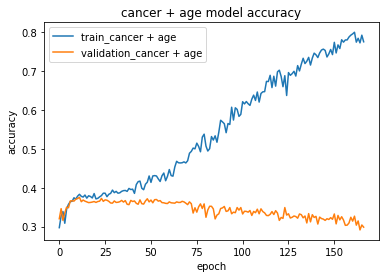

In [76]:

# df_model["all_features"] = df_model.iloc[:, 1]
# for i in range(6, 7):
#     df_model["all_features"] = df_model["all_features"] + df_model.iloc[:, i]


# df_model[
# "all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls + df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 + df_model.five_gram + df_model.six_gram + df_model.five_gram_cls + df_model.six_gram_cls

# df_model["all_features"] = df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 

# df_model["all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls

df_model["selected_features"] = df_origin.cs + df_origin.agel + df_model.trigram
features = [
    'unigram',
    'bigram',
    'trigram',
    'four_gram',
    'five_gram',
    'six_gram',
    'trigram_skip2',
    'trigram_skip3',
    'unigram_cls',
    'bigram_cls',
    'trigram_cls',
    'four_gram_cls',
    'five_gram_cls',
    'six_gram_cls',
    'trigram_cls_skip2',
    'trigram_cls_skip3',
    'all_features']

# for feature in features:

# df_model["selected_features"] = df_model.trigram 

start_time1 = time.time()

X = np.array(list(df_model["selected_features"])).astype(float)
logger.debug(len(X[0]))


dummy_y = np.array(list(df_origin["os"])).astype(float)
# logger.debug(dummy_y[0])

seed = 23
np.random.seed(23)
dim = len(X[0])

# , kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.0001)
K.clear_session()
model = Sequential()
model.add(Dense(2000, input_dim=dim, activation="relu"))
# model.add(Dropout(0.50))
model.add(Dense(2000, activation="relu"))
model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.10))
model.add(Dense(5, activation="softmax"))
Adam = optimizers.adam(lr=0.0001)
model.compile(loss="mean_squared_error", optimizer=Adam,  metrics=["accuracy"])
# plot_model(model, to_file="/model/model.png", show_shapes=True, show_layer_names=True)
model.summary()
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)
history = model.fit(X, dummy_y, validation_split=0.5, epochs=500, batch_size=1024, callbacks=[early_stop])

feature = "cancer + age"

plot_loss(feature)

plot_acc(feature)

logger.debug("--- %s seconds ---" % (time.time() - start_time1))



In [44]:
df_model["selected_features"] = df_model.trigram + df_model.trigram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 + df_clustering.clustering

In [45]:
len(df_model["selected_features"][0])

16043

[2018-05-09 23:14:43,806]-[6628]-[5208]-[etl]-[40]-[DEBUG]: 16043


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              32088000  
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)                26013     
Total params: 36,116,013
Trainable params: 36,116,013
Non-trainable params: 0
_________________________________________________________________


Train on 2120 samples, validate on 2121 samples
Epoch 1/500


1024/2120 [=============>................] - ETA: 1s - loss: 2.5665 - acc: 0.0547

2048/2120 [===========================>..] - ETA: 0s - loss: 4.9598 - acc: 0.0845

2120/2120 [==============================] - 2s 823us/step - loss: 5.0467 - acc: 0.0830 - val_loss: 5.1066 - val_acc: 0.0839


Epoch 2/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.9732 - acc: 0.0801

2048/2120 [===========================>..] - ETA: 0s - loss: 3.7585 - acc: 0.0845

2120/2120 [==============================] - 1s 416us/step - loss: 3.7204 - acc: 0.0854 - val_loss: 2.4747 - val_acc: 0.1150


Epoch 3/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.4908 - acc: 0.1172

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4772 - acc: 0.1504

2120/2120 [==============================] - 1s 439us/step - loss: 2.4751 - acc: 0.1486 - val_loss: 2.4549 - val_acc: 0.1589


Epoch 4/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.4083 - acc: 0.1904

2048/2120 [===========================>..] - ETA: 0s - loss: 2.3759 - acc: 0.1953

2120/2120 [==============================] - 1s 414us/step - loss: 2.3697 - acc: 0.1981 - val_loss: 2.2747 - val_acc: 0.1443


Epoch 5/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.1846 - acc: 0.2031

2048/2120 [===========================>..] - ETA: 0s - loss: 2.1497 - acc: 0.2314

2120/2120 [==============================] - 1s 433us/step - loss: 2.1492 - acc: 0.2302 - val_loss: 2.6748 - val_acc: 0.1726


Epoch 6/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.5058 - acc: 0.2021

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4255 - acc: 0.2065

2120/2120 [==============================] - 1s 424us/step - loss: 2.4131 - acc: 0.2099 - val_loss: 2.2869 - val_acc: 0.1867


Epoch 7/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.0647 - acc: 0.2461

2048/2120 [===========================>..] - ETA: 0s - loss: 1.9765 - acc: 0.2993

2120/2120 [==============================] - 1s 409us/step - loss: 1.9726 - acc: 0.3005 - val_loss: 3.2654 - val_acc: 0.1584


Epoch 8/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.8442 - acc: 0.2090

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4998 - acc: 0.2666

2120/2120 [==============================] - 1s 423us/step - loss: 2.4845 - acc: 0.2693 - val_loss: 2.4263 - val_acc: 0.2041


Epoch 9/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.2263 - acc: 0.2510

2048/2120 [===========================>..] - ETA: 0s - loss: 2.0775 - acc: 0.2959

2120/2120 [==============================] - 1s 415us/step - loss: 2.0741 - acc: 0.2953 - val_loss: 2.1930 - val_acc: 0.2112


Epoch 10/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.9345 - acc: 0.3262

2048/2120 [===========================>..] - ETA: 0s - loss: 1.8450 - acc: 0.3628

2120/2120 [==============================] - 1s 404us/step - loss: 1.8457 - acc: 0.3618 - val_loss: 2.1463 - val_acc: 0.2249


Epoch 11/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.8154 - acc: 0.3232

2048/2120 [===========================>..] - ETA: 0s - loss: 1.7812 - acc: 0.3413

2120/2120 [==============================] - 1s 419us/step - loss: 1.7746 - acc: 0.3467 - val_loss: 2.1440 - val_acc: 0.2390


Epoch 12/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.7183 - acc: 0.3574

2048/2120 [===========================>..] - ETA: 0s - loss: 1.6664 - acc: 0.3711

2120/2120 [==============================] - 1s 415us/step - loss: 1.6610 - acc: 0.3759 - val_loss: 2.3680 - val_acc: 0.2598


Epoch 13/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.6846 - acc: 0.4219

2048/2120 [===========================>..] - ETA: 0s - loss: 1.7317 - acc: 0.4150

2120/2120 [==============================] - 1s 411us/step - loss: 1.7263 - acc: 0.4132 - val_loss: 2.1835 - val_acc: 0.2574


Epoch 14/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.4560 - acc: 0.5342

2048/2120 [===========================>..] - ETA: 0s - loss: 1.4615 - acc: 0.5063

2120/2120 [==============================] - 1s 410us/step - loss: 1.4626 - acc: 0.5033 - val_loss: 2.1959 - val_acc: 0.2202


Epoch 15/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.4071 - acc: 0.5146

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3897 - acc: 0.5117

2120/2120 [==============================] - 1s 416us/step - loss: 1.3948 - acc: 0.5118 - val_loss: 2.1878 - val_acc: 0.2551


Epoch 16/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.3118 - acc: 0.5391

2048/2120 [===========================>..] - ETA: 0s - loss: 1.2734 - acc: 0.5425

2120/2120 [==============================] - 1s 438us/step - loss: 1.2696 - acc: 0.5425 - val_loss: 2.2877 - val_acc: 0.2654


Epoch 17/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.1436 - acc: 0.6270

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3629 - acc: 0.5566

2120/2120 [==============================] - 1s 416us/step - loss: 1.3616 - acc: 0.5575 - val_loss: 2.4327 - val_acc: 0.2428


Epoch 18/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.0468 - acc: 0.6152

2048/2120 [===========================>..] - ETA: 0s - loss: 1.1197 - acc: 0.6016

2120/2120 [==============================] - 1s 420us/step - loss: 1.1134 - acc: 0.6024 - val_loss: 2.6693 - val_acc: 0.2546


Epoch 19/500


1024/2120 [=============>................] - ETA: 0s - loss: 1.4203 - acc: 0.5244

2048/2120 [===========================>..] - ETA: 0s - loss: 1.2224 - acc: 0.5771

2120/2120 [==============================] - 1s 425us/step - loss: 1.2236 - acc: 0.5778 - val_loss: 2.3416 - val_acc: 0.2617


Epoch 20/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.9473 - acc: 0.7070

2048/2120 [===========================>..] - ETA: 0s - loss: 0.9319 - acc: 0.7090

2120/2120 [==============================] - 1s 413us/step - loss: 0.9280 - acc: 0.7104 - val_loss: 2.3444 - val_acc: 0.2456


Epoch 21/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.9422 - acc: 0.6943

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8539 - acc: 0.7280

2120/2120 [==============================] - 1s 395us/step - loss: 0.8509 - acc: 0.7288 - val_loss: 2.5517 - val_acc: 0.2603


Epoch 22/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.8132 - acc: 0.7139

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8769 - acc: 0.7051

2120/2120 [==============================] - 1s 397us/step - loss: 0.8714 - acc: 0.7066 - val_loss: 2.7153 - val_acc: 0.2414


Epoch 23/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.6268 - acc: 0.7861

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7054 - acc: 0.7290

2120/2120 [==============================] - 1s 417us/step - loss: 0.7123 - acc: 0.7288 - val_loss: 3.0488 - val_acc: 0.2537


Epoch 24/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.8908 - acc: 0.7002

2048/2120 [===========================>..] - ETA: 0s - loss: 0.9543 - acc: 0.6738

2120/2120 [==============================] - 1s 419us/step - loss: 0.9440 - acc: 0.6769 - val_loss: 2.5749 - val_acc: 0.2895


Epoch 25/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.7243 - acc: 0.7871

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7233 - acc: 0.7817

2120/2120 [==============================] - 1s 405us/step - loss: 0.7170 - acc: 0.7835 - val_loss: 2.7085 - val_acc: 0.2532


Epoch 26/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.7091 - acc: 0.7617

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6165 - acc: 0.8062

2120/2120 [==============================] - 1s 416us/step - loss: 0.6170 - acc: 0.8057 - val_loss: 2.6391 - val_acc: 0.2551


Epoch 27/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.4887 - acc: 0.8643

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4697 - acc: 0.8735

2120/2120 [==============================] - 1s 455us/step - loss: 0.4633 - acc: 0.8745 - val_loss: 2.6488 - val_acc: 0.2758


Epoch 28/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.4155 - acc: 0.8486

2048/2120 [===========================>..] - ETA: 0s - loss: 0.3864 - acc: 0.8721

2120/2120 [==============================] - 1s 448us/step - loss: 0.3852 - acc: 0.8741 - val_loss: 2.6642 - val_acc: 0.2961


Epoch 29/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.3330 - acc: 0.9082

2048/2120 [===========================>..] - ETA: 0s - loss: 0.3002 - acc: 0.9219

2120/2120 [==============================] - 1s 430us/step - loss: 0.2970 - acc: 0.9222 - val_loss: 2.9959 - val_acc: 0.2951


Epoch 30/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.2428 - acc: 0.9258

2048/2120 [===========================>..] - ETA: 0s - loss: 0.2399 - acc: 0.9282

2120/2120 [==============================] - 1s 405us/step - loss: 0.2409 - acc: 0.9269 - val_loss: 3.0969 - val_acc: 0.2824


Epoch 31/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1583 - acc: 0.9609

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1828 - acc: 0.9507

2120/2120 [==============================] - 1s 424us/step - loss: 0.1805 - acc: 0.9509 - val_loss: 3.1675 - val_acc: 0.2867


Epoch 32/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1810 - acc: 0.9482

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1765 - acc: 0.9526

2120/2120 [==============================] - 1s 419us/step - loss: 0.1756 - acc: 0.9528 - val_loss: 3.3014 - val_acc: 0.3055


Epoch 33/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1426 - acc: 0.9570

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1390 - acc: 0.9590

2120/2120 [==============================] - 1s 424us/step - loss: 0.1369 - acc: 0.9599 - val_loss: 3.4240 - val_acc: 0.2862


Epoch 34/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1558 - acc: 0.9404

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1215 - acc: 0.9600

2120/2120 [==============================] - 1s 407us/step - loss: 0.1231 - acc: 0.9590 - val_loss: 3.3492 - val_acc: 0.3121


Epoch 35/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0839 - acc: 0.9854

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1050 - acc: 0.9722

2120/2120 [==============================] - 1s 407us/step - loss: 0.1028 - acc: 0.9726 - val_loss: 3.7757 - val_acc: 0.2852


Epoch 36/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1581 - acc: 0.9453

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1157 - acc: 0.9648

2120/2120 [==============================] - 1s 407us/step - loss: 0.1144 - acc: 0.9651 - val_loss: 3.6411 - val_acc: 0.2984


Epoch 37/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1226 - acc: 0.9609

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0935 - acc: 0.9731

2120/2120 [==============================] - 1s 423us/step - loss: 0.0932 - acc: 0.9736 - val_loss: 3.6303 - val_acc: 0.2876


Epoch 38/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1047 - acc: 0.9629

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0786 - acc: 0.9775

2120/2120 [==============================] - 1s 420us/step - loss: 0.0839 - acc: 0.9759 - val_loss: 3.7357 - val_acc: 0.2730


Epoch 39/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.1007 - acc: 0.9688

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1148 - acc: 0.9595

2120/2120 [==============================] - 1s 427us/step - loss: 0.1186 - acc: 0.9580 - val_loss: 3.4767 - val_acc: 0.3098


Epoch 40/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0553 - acc: 0.9902

2048/2120 [===========================>..] - ETA: 0s - loss: 0.1264 - acc: 0.9595

2120/2120 [==============================] - 1s 422us/step - loss: 0.1243 - acc: 0.9599 - val_loss: 3.5268 - val_acc: 0.2984


Epoch 41/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0723 - acc: 0.9814

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0640 - acc: 0.9863

2120/2120 [==============================] - 1s 409us/step - loss: 0.0646 - acc: 0.9863 - val_loss: 3.4091 - val_acc: 0.2900


Epoch 42/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0331 - acc: 0.9980

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0311 - acc: 0.9971

2120/2120 [==============================] - 1s 419us/step - loss: 0.0314 - acc: 0.9972 - val_loss: 3.7326 - val_acc: 0.3116


Epoch 43/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0317 - acc: 0.9980

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0274 - acc: 0.9980

2120/2120 [==============================] - 1s 415us/step - loss: 0.0271 - acc: 0.9981 - val_loss: 3.7722 - val_acc: 0.2989


Epoch 44/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0289 - acc: 0.9961

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0258 - acc: 0.9961

2120/2120 [==============================] - 1s 419us/step - loss: 0.0253 - acc: 0.9962 - val_loss: 3.7304 - val_acc: 0.2989


Epoch 45/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0151 - acc: 0.9961

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0165 - acc: 0.9971

2120/2120 [==============================] - 1s 428us/step - loss: 0.0163 - acc: 0.9972 - val_loss: 3.6705 - val_acc: 0.3088


Epoch 46/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0136 - acc: 0.9980

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0132 - acc: 0.9990

2120/2120 [==============================] - 1s 414us/step - loss: 0.0131 - acc: 0.9991 - val_loss: 3.7557 - val_acc: 0.3272


Epoch 47/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0075 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0075 - acc: 1.0000

2120/2120 [==============================] - 1s 423us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 4.0734 - val_acc: 0.3145


Epoch 48/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0119 - acc: 0.9990

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0091 - acc: 0.9995

2120/2120 [==============================] - 1s 430us/step - loss: 0.0093 - acc: 0.9995 - val_loss: 3.8953 - val_acc: 0.3187


Epoch 49/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0044 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0044 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 3.9221 - val_acc: 0.3168


Epoch 50/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0066 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0067 - acc: 1.0000

2120/2120 [==============================] - 1s 419us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 3.8428 - val_acc: 0.3300


Epoch 51/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0034 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 1.0000

2120/2120 [==============================] - 1s 432us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 3.9934 - val_acc: 0.3253


Epoch 52/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0040 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0038 - acc: 1.0000

2120/2120 [==============================] - 1s 432us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 4.1045 - val_acc: 0.3168


Epoch 53/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0038 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0041 - acc: 1.0000

2120/2120 [==============================] - 1s 421us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 4.0748 - val_acc: 0.3140


Epoch 54/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0026 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 4.0206 - val_acc: 0.3248


Epoch 55/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0018 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 1.0000

2120/2120 [==============================] - 1s 416us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 4.0426 - val_acc: 0.3258


Epoch 56/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0019 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 1.0000

2120/2120 [==============================] - 1s 415us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 4.0238 - val_acc: 0.3220


Epoch 57/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0019 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 1.0000

2120/2120 [==============================] - 1s 424us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 4.0034 - val_acc: 0.3258


Epoch 58/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0017 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 1.0000

2120/2120 [==============================] - 1s 430us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 4.0170 - val_acc: 0.3329


Epoch 59/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0014 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

2120/2120 [==============================] - 1s 433us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 4.0606 - val_acc: 0.3272


Epoch 60/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0012 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

2120/2120 [==============================] - 1s 409us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 4.0927 - val_acc: 0.3234


Epoch 61/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0013 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

2120/2120 [==============================] - 1s 432us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 4.1053 - val_acc: 0.3267


Epoch 62/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0013 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

2120/2120 [==============================] - 1s 421us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 4.0951 - val_acc: 0.3291


Epoch 63/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0013 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 1.0000

2120/2120 [==============================] - 1s 435us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 4.0815 - val_acc: 0.3319


Epoch 64/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0012 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0011 - acc: 1.0000

2120/2120 [==============================] - 1s 416us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 4.0756 - val_acc: 0.3319


Epoch 65/500


1024/2120 [=============>................] - ETA: 0s - loss: 9.9612e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0010 - acc: 1.0000    

2120/2120 [==============================] - 1s 429us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 4.0728 - val_acc: 0.3314


Epoch 66/500


1024/2120 [=============>................] - ETA: 0s - loss: 9.5113e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 0.0010 - acc: 1.0000    

2120/2120 [==============================] - 1s 410us/step - loss: 9.9770e-04 - acc: 1.0000 - val_loss: 4.0713 - val_acc: 0.3324


Epoch 67/500


1024/2120 [=============>................] - ETA: 0s - loss: 0.0010 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 9.7047e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 407us/step - loss: 9.6857e-04 - acc: 1.0000 - val_loss: 4.0744 - val_acc: 0.3310


Epoch 68/500


1024/2120 [=============>................] - ETA: 0s - loss: 9.6426e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 9.8644e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 438us/step - loss: 9.9159e-04 - acc: 1.0000 - val_loss: 4.0770 - val_acc: 0.3296


Epoch 69/500


1024/2120 [=============>................] - ETA: 0s - loss: 8.7027e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 8.9289e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 419us/step - loss: 8.9059e-04 - acc: 1.0000 - val_loss: 4.0912 - val_acc: 0.3263


Epoch 70/500


1024/2120 [=============>................] - ETA: 0s - loss: 9.0566e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 9.1306e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 9.0328e-04 - acc: 1.0000 - val_loss: 4.1032 - val_acc: 0.3244


Epoch 71/500


1024/2120 [=============>................] - ETA: 0s - loss: 8.6714e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 8.6328e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 431us/step - loss: 8.5789e-04 - acc: 1.0000 - val_loss: 4.1053 - val_acc: 0.3239


Epoch 72/500


1024/2120 [=============>................] - ETA: 0s - loss: 9.2174e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 8.3178e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 420us/step - loss: 8.2663e-04 - acc: 1.0000 - val_loss: 4.1046 - val_acc: 0.3277


Epoch 73/500


1024/2120 [=============>................] - ETA: 0s - loss: 8.5661e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 8.1380e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 434us/step - loss: 8.1416e-04 - acc: 1.0000 - val_loss: 4.1099 - val_acc: 0.3314


Epoch 74/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.3657e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 7.8119e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 418us/step - loss: 7.9036e-04 - acc: 1.0000 - val_loss: 4.1199 - val_acc: 0.3333


Epoch 75/500


1024/2120 [=============>................] - ETA: 0s - loss: 7.9900e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 7.8544e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 408us/step - loss: 7.9451e-04 - acc: 1.0000 - val_loss: 4.1296 - val_acc: 0.3343


Epoch 76/500


1024/2120 [=============>................] - ETA: 0s - loss: 7.5701e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 7.5701e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 426us/step - loss: 7.6356e-04 - acc: 1.0000 - val_loss: 4.1409 - val_acc: 0.3314


Epoch 77/500


1024/2120 [=============>................] - ETA: 0s - loss: 7.7314e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 7.5759e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 424us/step - loss: 7.5206e-04 - acc: 1.0000 - val_loss: 4.1588 - val_acc: 0.3291


Epoch 78/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.5367e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 7.2609e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 416us/step - loss: 7.2399e-04 - acc: 1.0000 - val_loss: 4.1660 - val_acc: 0.3281


Epoch 79/500


1024/2120 [=============>................] - ETA: 0s - loss: 7.5835e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 7.1292e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 418us/step - loss: 7.0898e-04 - acc: 1.0000 - val_loss: 4.1642 - val_acc: 0.3300


Epoch 80/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.9364e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 6.7234e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 435us/step - loss: 6.6866e-04 - acc: 1.0000 - val_loss: 4.1649 - val_acc: 0.3277


Epoch 81/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.5380e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 6.6632e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 412us/step - loss: 6.6538e-04 - acc: 1.0000 - val_loss: 4.1769 - val_acc: 0.3263


Epoch 82/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.5982e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 6.5028e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 435us/step - loss: 6.5124e-04 - acc: 1.0000 - val_loss: 4.1891 - val_acc: 0.3300


Epoch 83/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.7203e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 6.2239e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 424us/step - loss: 6.2373e-04 - acc: 1.0000 - val_loss: 4.1966 - val_acc: 0.3296


Epoch 84/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.1082e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 5.8918e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 419us/step - loss: 6.0267e-04 - acc: 1.0000 - val_loss: 4.2017 - val_acc: 0.3305


Epoch 85/500


1024/2120 [=============>................] - ETA: 0s - loss: 6.0520e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 6.1780e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 429us/step - loss: 6.1628e-04 - acc: 1.0000 - val_loss: 4.2137 - val_acc: 0.3319


Epoch 86/500


1024/2120 [=============>................] - ETA: 0s - loss: 5.8601e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 5.9575e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 5.9405e-04 - acc: 1.0000 - val_loss: 4.2239 - val_acc: 0.3281


Epoch 87/500


1024/2120 [=============>................] - ETA: 0s - loss: 5.0485e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 5.6893e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 394us/step - loss: 5.6640e-04 - acc: 1.0000 - val_loss: 4.2316 - val_acc: 0.3291


Epoch 88/500


1024/2120 [=============>................] - ETA: 0s - loss: 5.7555e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 5.4123e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 415us/step - loss: 5.3571e-04 - acc: 1.0000 - val_loss: 4.2409 - val_acc: 0.3263


Epoch 89/500


1024/2120 [=============>................] - ETA: 0s - loss: 5.7601e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 5.4069e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 416us/step - loss: 5.4007e-04 - acc: 1.0000 - val_loss: 4.2374 - val_acc: 0.3286


Epoch 90/500


1024/2120 [=============>................] - ETA: 0s - loss: 5.3403e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 5.1318e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 5.0774e-04 - acc: 1.0000 - val_loss: 4.2346 - val_acc: 0.3291


Epoch 91/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.7517e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 5.0305e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 432us/step - loss: 5.0724e-04 - acc: 1.0000 - val_loss: 4.2418 - val_acc: 0.3277


Epoch 92/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.6489e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.9912e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 426us/step - loss: 5.0129e-04 - acc: 1.0000 - val_loss: 4.2522 - val_acc: 0.3286


Epoch 93/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.9488e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.6696e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 437us/step - loss: 4.6712e-04 - acc: 1.0000 - val_loss: 4.2703 - val_acc: 0.3281


Epoch 94/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.8501e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.5475e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 415us/step - loss: 4.5936e-04 - acc: 1.0000 - val_loss: 4.2739 - val_acc: 0.3296


Epoch 95/500


1024/2120 [=============>................] - ETA: 0s - loss: 5.0653e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.5698e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 423us/step - loss: 4.5451e-04 - acc: 1.0000 - val_loss: 4.2838 - val_acc: 0.3314


Epoch 96/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.4952e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.2761e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 423us/step - loss: 4.2787e-04 - acc: 1.0000 - val_loss: 4.2980 - val_acc: 0.3314


Epoch 97/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.3846e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.4274e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 411us/step - loss: 4.4586e-04 - acc: 1.0000 - val_loss: 4.3058 - val_acc: 0.3319


Epoch 98/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.0264e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.0317e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 433us/step - loss: 4.0424e-04 - acc: 1.0000 - val_loss: 4.3073 - val_acc: 0.3324


Epoch 99/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.7241e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 4.1138e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 4.0987e-04 - acc: 1.0000 - val_loss: 4.3150 - val_acc: 0.3329


Epoch 100/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.6483e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.8143e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 432us/step - loss: 3.7624e-04 - acc: 1.0000 - val_loss: 4.3281 - val_acc: 0.3300


Epoch 101/500


1024/2120 [=============>................] - ETA: 0s - loss: 4.0135e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.7448e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 409us/step - loss: 3.7861e-04 - acc: 1.0000 - val_loss: 4.3395 - val_acc: 0.3272


Epoch 102/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.6232e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.8474e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 423us/step - loss: 3.8769e-04 - acc: 1.0000 - val_loss: 4.3458 - val_acc: 0.3296


Epoch 103/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.7443e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.7945e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 420us/step - loss: 3.7496e-04 - acc: 1.0000 - val_loss: 4.3499 - val_acc: 0.3324


Epoch 104/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.4912e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.4705e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 3.4598e-04 - acc: 1.0000 - val_loss: 4.3638 - val_acc: 0.3314


Epoch 105/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.1825e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.1952e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 414us/step - loss: 3.2111e-04 - acc: 1.0000 - val_loss: 4.3856 - val_acc: 0.3277


Epoch 106/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.3257e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.2464e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 432us/step - loss: 3.2722e-04 - acc: 1.0000 - val_loss: 4.4087 - val_acc: 0.3253


Epoch 107/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.4721e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.2515e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 419us/step - loss: 3.2042e-04 - acc: 1.0000 - val_loss: 4.4212 - val_acc: 0.3225


Epoch 108/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.4558e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.4805e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 425us/step - loss: 3.4748e-04 - acc: 1.0000 - val_loss: 4.4150 - val_acc: 0.3258


Epoch 109/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.1039e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.3103e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 410us/step - loss: 3.2817e-04 - acc: 1.0000 - val_loss: 4.4064 - val_acc: 0.3281


Epoch 110/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.1745e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.1663e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 415us/step - loss: 3.1526e-04 - acc: 1.0000 - val_loss: 4.4105 - val_acc: 0.3277


Epoch 111/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.6389e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.8587e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 407us/step - loss: 2.8880e-04 - acc: 1.0000 - val_loss: 4.4304 - val_acc: 0.3267


Epoch 112/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.5757e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.8987e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 419us/step - loss: 2.8906e-04 - acc: 1.0000 - val_loss: 4.4445 - val_acc: 0.3258


Epoch 113/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.4131e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.0002e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 427us/step - loss: 3.0347e-04 - acc: 1.0000 - val_loss: 4.4446 - val_acc: 0.3281


Epoch 114/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.1112e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 3.0070e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 403us/step - loss: 2.9630e-04 - acc: 1.0000 - val_loss: 4.4451 - val_acc: 0.3272


Epoch 115/500


1024/2120 [=============>................] - ETA: 0s - loss: 3.1897e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.8843e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 431us/step - loss: 2.8729e-04 - acc: 1.0000 - val_loss: 4.4465 - val_acc: 0.3277


Epoch 116/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.8113e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.7258e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 414us/step - loss: 2.7040e-04 - acc: 1.0000 - val_loss: 4.4563 - val_acc: 0.3296


Epoch 117/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.3024e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.5937e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 418us/step - loss: 2.5972e-04 - acc: 1.0000 - val_loss: 4.4731 - val_acc: 0.3263


Epoch 118/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.6554e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.6568e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 2.6460e-04 - acc: 1.0000 - val_loss: 4.4786 - val_acc: 0.3277


Epoch 119/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.6499e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.5484e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 427us/step - loss: 2.5878e-04 - acc: 1.0000 - val_loss: 4.4813 - val_acc: 0.3272


Epoch 120/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.8682e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.7246e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 2.6900e-04 - acc: 1.0000 - val_loss: 4.4846 - val_acc: 0.3263


Epoch 121/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.7976e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.7030e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 412us/step - loss: 2.6824e-04 - acc: 1.0000 - val_loss: 4.4816 - val_acc: 0.3281


Epoch 122/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.1673e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.2398e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 422us/step - loss: 2.2311e-04 - acc: 1.0000 - val_loss: 4.4820 - val_acc: 0.3305


Epoch 123/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.2748e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4022e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 423us/step - loss: 2.4052e-04 - acc: 1.0000 - val_loss: 4.4903 - val_acc: 0.3286


Epoch 124/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.4099e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4481e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 439us/step - loss: 2.4762e-04 - acc: 1.0000 - val_loss: 4.5048 - val_acc: 0.3272


Epoch 125/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.2308e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4294e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 413us/step - loss: 2.4679e-04 - acc: 1.0000 - val_loss: 4.5134 - val_acc: 0.3286


Epoch 126/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.6570e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4536e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 421us/step - loss: 2.4276e-04 - acc: 1.0000 - val_loss: 4.5284 - val_acc: 0.3291


Epoch 127/500


1024/2120 [=============>................] - ETA: 0s - loss: 2.4918e-04 - acc: 1.0000

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4213e-04 - acc: 1.0000

2120/2120 [==============================] - 1s 438us/step - loss: 2.3897e-04 - acc: 1.0000 - val_loss: 4.5445 - val_acc: 0.3277


[2018-05-09 23:16:39,053]-[6628]-[5208]-[etl]-[73]-[DEBUG]: --- 117.70215845108032 seconds ---


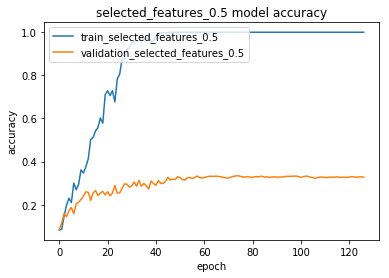

In [52]:
# df_model["all_features"] = df_model.iloc[:, 1]
# for i in range(6, 7):
#     df_model["all_features"] = df_model["all_features"] + df_model.iloc[:, i]


# df_model[
# "all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls + df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 + df_model.five_gram + df_model.six_gram + df_model.five_gram_cls + df_model.six_gram_cls

# df_model["all_features"] = df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 

# df_model["all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls

features = [
    'unigram',
    'bigram',
    'trigram',
    'four_gram',
    'five_gram',
    'six_gram',
    'trigram_skip2',
    'trigram_skip3',
    'unigram_cls',
    'bigram_cls',
    'trigram_cls',
    'four_gram_cls',
    'five_gram_cls',
    'six_gram_cls',
    'trigram_cls_skip2',
    'trigram_cls_skip3',
    'all_features']

# for feature in features:

# df_model["selected_features"] = df_model.trigram 

start_time1 = time.time()

X = np.array(list(df_model["selected_features"])).astype(float)
Y = np.array(list(df_model.cancer))
logger.debug(len(X[0]))

encoder = LabelEncoder()
encoder.fit(Y)
encoder_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoder_Y)
# logger.debug(dummy_y[0])

seed = 23
np.random.seed(23)
dim = len(X[0])

# , kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.0001)
K.clear_session()
model = Sequential()
model.add(Dense(2000, input_dim=dim, activation="relu"))
# model.add(Dropout(0.50))
model.add(Dense(2000, input_dim=dim, activation="relu"))
model.add(Dropout(0.10))
model.add(Dense(13, activation="softmax"))
Adam = optimizers.adam(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=Adam, metrics=["accuracy"])
# plot_model(model, to_file="/model/model.png", show_shapes=True, show_layer_names=True)
model.summary()
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)
history = model.fit(X, dummy_y, validation_split=0.5, epochs=500, batch_size=1024, callbacks=[early_stop])

feature = "selected_features_0.5"

plot_loss(feature)

plot_acc(feature)

logger.debug("--- %s seconds ---" % (time.time() - start_time1))


In [17]:
# seed = 23
# np.random.seed(23)
# dim = len(X[0])
# 
# # , kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.0001)
# K.clear_session()
# model = Sequential()
# model.add(Dense(256, input_dim=dim, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(13, activation="softmax"))
# Adam = optimizers.adam(lr=0.001)
# model.compile(loss="categorical_crossentropy", optimizer=Adam, metrics=["accuracy"])
# # plot_model(model, to_file="/model/model.png", show_shapes=True, show_layer_names=True)
# model.summary()
# early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# history = model.fit(X, dummy_y, validation_split=0.5, epochs=300, batch_size=512, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10379776  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                3341      
Total params: 10,383,117
Trainable params: 10,383,117
Non-trainable params: 0
_________________________________________________________________


Train on 2120 samples, validate on 2121 samples
Epoch 1/300


 256/2120 [==>...........................] - ETA: 4s - loss: 2.5665 - acc: 0.0859

 512/2120 [======>.......................] - ETA: 2s - loss: 2.5632 - acc: 0.0859

 768/2120 [=========>....................] - ETA: 1s - loss: 2.5613 - acc: 0.0872

1024/2120 [=============>................] - ETA: 0s - loss: 2.5600 - acc: 0.0859

1280/2120 [=================>............] - ETA: 0s - loss: 2.5583 - acc: 0.0914

1536/2120 [====================>.........] - ETA: 0s - loss: 2.5545 - acc: 0.0996

1792/2120 [========================>.....] - ETA: 0s - loss: 2.5530 - acc: 0.1010

2048/2120 [===========================>..] - ETA: 0s - loss: 2.5523 - acc: 0.1021

2120/2120 [==============================] - 2s 1ms/step - loss: 2.5518 - acc: 0.1028 - val_loss: 2.5357 - val_acc: 0.0835


Epoch 2/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.5268 - acc: 0.1602



 512/2120 [======>.......................] - ETA: 0s - loss: 2.5203 - acc: 0.1523

 768/2120 [=========>....................] - ETA: 0s - loss: 2.5210 - acc: 0.1510

1024/2120 [=============>................] - ETA: 0s - loss: 2.5220 - acc: 0.1406



1280/2120 [=================>............] - ETA: 0s - loss: 2.5213 - acc: 0.1367



1536/2120 [====================>.........] - ETA: 0s - loss: 2.5231 - acc: 0.1309

1792/2120 [========================>.....] - ETA: 0s - loss: 2.5210 - acc: 0.1362

2048/2120 [===========================>..] - ETA: 0s - loss: 2.5199 - acc: 0.1362

2120/2120 [==============================] - 2s 785us/step - loss: 2.5181 - acc: 0.1373 - val_loss: 2.5158 - val_acc: 0.0835


Epoch 3/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.5096 - acc: 0.1406

 512/2120 [======>.......................] - ETA: 0s - loss: 2.5035 - acc: 0.1230

 768/2120 [=========>....................] - ETA: 0s - loss: 2.5040 - acc: 0.1289

1024/2120 [=============>................] - ETA: 0s - loss: 2.4996 - acc: 0.1289

1280/2120 [=================>............] - ETA: 0s - loss: 2.4931 - acc: 0.1344

1536/2120 [====================>.........] - ETA: 0s - loss: 2.4906 - acc: 0.1374

1792/2120 [========================>.....] - ETA: 0s - loss: 2.4894 - acc: 0.1423

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4866 - acc: 0.1421

2120/2120 [==============================] - 2s 810us/step - loss: 2.4882 - acc: 0.1415 - val_loss: 2.4967 - val_acc: 0.1391


Epoch 4/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.4742 - acc: 0.1680

 512/2120 [======>.......................] - ETA: 0s - loss: 2.4777 - acc: 0.1641

 768/2120 [=========>....................] - ETA: 0s - loss: 2.4771 - acc: 0.1615

1024/2120 [=============>................] - ETA: 0s - loss: 2.4737 - acc: 0.1641

1280/2120 [=================>............] - ETA: 0s - loss: 2.4686 - acc: 0.1766



1536/2120 [====================>.........] - ETA: 0s - loss: 2.4694 - acc: 0.1745

1792/2120 [========================>.....] - ETA: 0s - loss: 2.4678 - acc: 0.1780

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4639 - acc: 0.1851

2120/2120 [==============================] - 2s 779us/step - loss: 2.4629 - acc: 0.1873 - val_loss: 2.4761 - val_acc: 0.1419


Epoch 5/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.4569 - acc: 0.1914



 512/2120 [======>.......................] - ETA: 0s - loss: 2.4414 - acc: 0.1934

 768/2120 [=========>....................] - ETA: 0s - loss: 2.4436 - acc: 0.1888

1024/2120 [=============>................] - ETA: 0s - loss: 2.4416 - acc: 0.1934

1280/2120 [=================>............] - ETA: 0s - loss: 2.4352 - acc: 0.2031

1536/2120 [====================>.........] - ETA: 0s - loss: 2.4347 - acc: 0.2083



1792/2120 [========================>.....] - ETA: 0s - loss: 2.4358 - acc: 0.2098

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4366 - acc: 0.2065

2120/2120 [==============================] - 2s 783us/step - loss: 2.4363 - acc: 0.2085 - val_loss: 2.4549 - val_acc: 0.1815


Epoch 6/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.4204 - acc: 0.2266



 512/2120 [======>.......................] - ETA: 0s - loss: 2.4084 - acc: 0.2441

 768/2120 [=========>....................] - ETA: 0s - loss: 2.4093 - acc: 0.2448

1024/2120 [=============>................] - ETA: 0s - loss: 2.4115 - acc: 0.2422

1280/2120 [=================>............] - ETA: 0s - loss: 2.4151 - acc: 0.2281

1536/2120 [====================>.........] - ETA: 0s - loss: 2.4168 - acc: 0.2311

1792/2120 [========================>.....] - ETA: 0s - loss: 2.4104 - acc: 0.2416

2048/2120 [===========================>..] - ETA: 0s - loss: 2.4063 - acc: 0.2471

2120/2120 [==============================] - 2s 798us/step - loss: 2.4061 - acc: 0.2505 - val_loss: 2.4350 - val_acc: 0.2225


Epoch 7/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.3857 - acc: 0.2812

 512/2120 [======>.......................] - ETA: 0s - loss: 2.3868 - acc: 0.2891

 768/2120 [=========>....................] - ETA: 0s - loss: 2.3812 - acc: 0.2839

1024/2120 [=============>................] - ETA: 0s - loss: 2.3748 - acc: 0.2871

1280/2120 [=================>............] - ETA: 0s - loss: 2.3745 - acc: 0.2914

1536/2120 [====================>.........] - ETA: 0s - loss: 2.3714 - acc: 0.2949

1792/2120 [========================>.....] - ETA: 0s - loss: 2.3691 - acc: 0.2930

2048/2120 [===========================>..] - ETA: 0s - loss: 2.3722 - acc: 0.2939

2120/2120 [==============================] - 2s 808us/step - loss: 2.3702 - acc: 0.2939 - val_loss: 2.4154 - val_acc: 0.1985


Epoch 8/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.3157 - acc: 0.3438

 512/2120 [======>.......................] - ETA: 0s - loss: 2.3327 - acc: 0.3223

 768/2120 [=========>....................] - ETA: 0s - loss: 2.3420 - acc: 0.3060

1024/2120 [=============>................] - ETA: 0s - loss: 2.3380 - acc: 0.3086

1280/2120 [=================>............] - ETA: 0s - loss: 2.3367 - acc: 0.3102

1536/2120 [====================>.........] - ETA: 0s - loss: 2.3437 - acc: 0.3001

1792/2120 [========================>.....] - ETA: 0s - loss: 2.3454 - acc: 0.3019

2048/2120 [===========================>..] - ETA: 0s - loss: 2.3479 - acc: 0.3003

2120/2120 [==============================] - 2s 829us/step - loss: 2.3442 - acc: 0.3028 - val_loss: 2.3907 - val_acc: 0.2527


Epoch 9/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.3491 - acc: 0.2656

 512/2120 [======>.......................] - ETA: 0s - loss: 2.3188 - acc: 0.3164

 768/2120 [=========>....................] - ETA: 0s - loss: 2.3072 - acc: 0.3359

1024/2120 [=============>................] - ETA: 0s - loss: 2.3015 - acc: 0.3330

1280/2120 [=================>............] - ETA: 0s - loss: 2.3044 - acc: 0.3320

1536/2120 [====================>.........] - ETA: 0s - loss: 2.3003 - acc: 0.3366

1792/2120 [========================>.....] - ETA: 0s - loss: 2.3080 - acc: 0.3292

2048/2120 [===========================>..] - ETA: 0s - loss: 2.3057 - acc: 0.3306

2120/2120 [==============================] - 2s 841us/step - loss: 2.3075 - acc: 0.3283 - val_loss: 2.3720 - val_acc: 0.2442


Epoch 10/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.2737 - acc: 0.2852

 512/2120 [======>.......................] - ETA: 0s - loss: 2.2739 - acc: 0.3223

 768/2120 [=========>....................] - ETA: 0s - loss: 2.2685 - acc: 0.3320

1024/2120 [=============>................] - ETA: 0s - loss: 2.2648 - acc: 0.3467

1280/2120 [=================>............] - ETA: 0s - loss: 2.2646 - acc: 0.3563

1536/2120 [====================>.........] - ETA: 0s - loss: 2.2606 - acc: 0.3613

1792/2120 [========================>.....] - ETA: 0s - loss: 2.2648 - acc: 0.3633

2048/2120 [===========================>..] - ETA: 0s - loss: 2.2695 - acc: 0.3599

2120/2120 [==============================] - 2s 763us/step - loss: 2.2687 - acc: 0.3632 - val_loss: 2.3517 - val_acc: 0.2546


Epoch 11/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.2729 - acc: 0.3320

 512/2120 [======>.......................] - ETA: 0s - loss: 2.2487 - acc: 0.3613

 768/2120 [=========>....................] - ETA: 0s - loss: 2.2474 - acc: 0.3555

1024/2120 [=============>................] - ETA: 0s - loss: 2.2414 - acc: 0.3789

1280/2120 [=================>............] - ETA: 0s - loss: 2.2386 - acc: 0.3836

1536/2120 [====================>.........] - ETA: 0s - loss: 2.2381 - acc: 0.3783

1792/2120 [========================>.....] - ETA: 0s - loss: 2.2392 - acc: 0.3728

2048/2120 [===========================>..] - ETA: 0s - loss: 2.2422 - acc: 0.3730

2120/2120 [==============================] - 2s 820us/step - loss: 2.2421 - acc: 0.3755 - val_loss: 2.3319 - val_acc: 0.2598


Epoch 12/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.2471 - acc: 0.3359

 512/2120 [======>.......................] - ETA: 0s - loss: 2.2146 - acc: 0.3750

 768/2120 [=========>....................] - ETA: 0s - loss: 2.2014 - acc: 0.4023

1024/2120 [=============>................] - ETA: 0s - loss: 2.2095 - acc: 0.3994

1280/2120 [=================>............] - ETA: 0s - loss: 2.2105 - acc: 0.4039

1536/2120 [====================>.........] - ETA: 0s - loss: 2.2132 - acc: 0.4076

1792/2120 [========================>.....] - ETA: 0s - loss: 2.2033 - acc: 0.4152

2048/2120 [===========================>..] - ETA: 0s - loss: 2.2039 - acc: 0.4116

2120/2120 [==============================] - 2s 790us/step - loss: 2.2041 - acc: 0.4123 - val_loss: 2.3128 - val_acc: 0.2555


Epoch 13/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.2110 - acc: 0.4570

 512/2120 [======>.......................] - ETA: 0s - loss: 2.2040 - acc: 0.4336

 768/2120 [=========>....................] - ETA: 0s - loss: 2.1913 - acc: 0.4375

1024/2120 [=============>................] - ETA: 0s - loss: 2.1863 - acc: 0.4365

1280/2120 [=================>............] - ETA: 0s - loss: 2.1815 - acc: 0.4336

1536/2120 [====================>.........] - ETA: 0s - loss: 2.1760 - acc: 0.4329



1792/2120 [========================>.....] - ETA: 0s - loss: 2.1743 - acc: 0.4286

2048/2120 [===========================>..] - ETA: 0s - loss: 2.1743 - acc: 0.4307

2120/2120 [==============================] - 2s 802us/step - loss: 2.1738 - acc: 0.4302 - val_loss: 2.2927 - val_acc: 0.2617


Epoch 14/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.1187 - acc: 0.4688

 512/2120 [======>.......................] - ETA: 0s - loss: 2.1361 - acc: 0.4453

 768/2120 [=========>....................] - ETA: 0s - loss: 2.1351 - acc: 0.4427

1024/2120 [=============>................] - ETA: 0s - loss: 2.1315 - acc: 0.4365

1280/2120 [=================>............] - ETA: 0s - loss: 2.1340 - acc: 0.4375

1536/2120 [====================>.........] - ETA: 0s - loss: 2.1372 - acc: 0.4368

1792/2120 [========================>.....] - ETA: 0s - loss: 2.1396 - acc: 0.4342

2048/2120 [===========================>..] - ETA: 0s - loss: 2.1367 - acc: 0.4404

2120/2120 [==============================] - 2s 835us/step - loss: 2.1368 - acc: 0.4406 - val_loss: 2.2736 - val_acc: 0.2763


Epoch 15/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.1160 - acc: 0.4688

 512/2120 [======>.......................] - ETA: 0s - loss: 2.1093 - acc: 0.4648

 768/2120 [=========>....................] - ETA: 0s - loss: 2.1314 - acc: 0.4466

1024/2120 [=============>................] - ETA: 0s - loss: 2.1117 - acc: 0.4619

1280/2120 [=================>............] - ETA: 0s - loss: 2.1129 - acc: 0.4609

1536/2120 [====================>.........] - ETA: 0s - loss: 2.1109 - acc: 0.4564

1792/2120 [========================>.....] - ETA: 0s - loss: 2.1134 - acc: 0.4542

2048/2120 [===========================>..] - ETA: 0s - loss: 2.1161 - acc: 0.4517

2120/2120 [==============================] - 2s 835us/step - loss: 2.1134 - acc: 0.4505 - val_loss: 2.2609 - val_acc: 0.2650


Epoch 16/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.0710 - acc: 0.5000

 512/2120 [======>.......................] - ETA: 0s - loss: 2.0689 - acc: 0.4844

 768/2120 [=========>....................] - ETA: 0s - loss: 2.0707 - acc: 0.4753

1024/2120 [=============>................] - ETA: 0s - loss: 2.0760 - acc: 0.4580

1280/2120 [=================>............] - ETA: 0s - loss: 2.0658 - acc: 0.4734

1536/2120 [====================>.........] - ETA: 0s - loss: 2.0686 - acc: 0.4629

1792/2120 [========================>.....] - ETA: 0s - loss: 2.0691 - acc: 0.4609

2048/2120 [===========================>..] - ETA: 0s - loss: 2.0685 - acc: 0.4629

2120/2120 [==============================] - 2s 779us/step - loss: 2.0696 - acc: 0.4632 - val_loss: 2.2446 - val_acc: 0.2706


Epoch 17/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.0551 - acc: 0.4922

 512/2120 [======>.......................] - ETA: 0s - loss: 2.0650 - acc: 0.4785

 768/2120 [=========>....................] - ETA: 0s - loss: 2.0654 - acc: 0.4701

1024/2120 [=============>................] - ETA: 0s - loss: 2.0523 - acc: 0.4805

1280/2120 [=================>............] - ETA: 0s - loss: 2.0580 - acc: 0.4742



1536/2120 [====================>.........] - ETA: 0s - loss: 2.0569 - acc: 0.4798

1792/2120 [========================>.....] - ETA: 0s - loss: 2.0514 - acc: 0.4833

2048/2120 [===========================>..] - ETA: 0s - loss: 2.0491 - acc: 0.4834

2120/2120 [==============================] - 2s 763us/step - loss: 2.0480 - acc: 0.4840 - val_loss: 2.2293 - val_acc: 0.2786


Epoch 18/300
 256/2120 [==>...........................] - ETA: 0s - loss: 2.0526 - acc: 0.4648



 512/2120 [======>.......................] - ETA: 0s - loss: 2.0395 - acc: 0.4727

 768/2120 [=========>....................] - ETA: 0s - loss: 2.0223 - acc: 0.4987

1024/2120 [=============>................] - ETA: 0s - loss: 2.0251 - acc: 0.5049

1280/2120 [=================>............] - ETA: 0s - loss: 2.0280 - acc: 0.4992

1536/2120 [====================>.........] - ETA: 0s - loss: 2.0263 - acc: 0.5020

1792/2120 [========================>.....] - ETA: 0s - loss: 2.0229 - acc: 0.5050

2048/2120 [===========================>..] - ETA: 0s - loss: 2.0215 - acc: 0.5063

2120/2120 [==============================] - 2s 814us/step - loss: 2.0165 - acc: 0.5108 - val_loss: 2.2170 - val_acc: 0.2852


Epoch 19/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.9977 - acc: 0.5117

 512/2120 [======>.......................] - ETA: 0s - loss: 1.9873 - acc: 0.5039

 768/2120 [=========>....................] - ETA: 0s - loss: 1.9902 - acc: 0.5104

1024/2120 [=============>................] - ETA: 0s - loss: 1.9838 - acc: 0.5215

1280/2120 [=================>............] - ETA: 0s - loss: 1.9909 - acc: 0.5117

1536/2120 [====================>.........] - ETA: 0s - loss: 1.9891 - acc: 0.5059



1792/2120 [========================>.....] - ETA: 0s - loss: 1.9886 - acc: 0.5073

2048/2120 [===========================>..] - ETA: 0s - loss: 1.9912 - acc: 0.5073

2120/2120 [==============================] - 2s 763us/step - loss: 1.9901 - acc: 0.5099 - val_loss: 2.2053 - val_acc: 0.2744


Epoch 20/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.9223 - acc: 0.5586

 512/2120 [======>.......................] - ETA: 0s - loss: 1.9623 - acc: 0.5234

 768/2120 [=========>....................] - ETA: 0s - loss: 1.9515 - acc: 0.5260

1024/2120 [=============>................] - ETA: 0s - loss: 1.9606 - acc: 0.5352

1280/2120 [=================>............] - ETA: 0s - loss: 1.9540 - acc: 0.5359

1536/2120 [====================>.........] - ETA: 0s - loss: 1.9620 - acc: 0.5326

1792/2120 [========================>.....] - ETA: 0s - loss: 1.9551 - acc: 0.5329



2048/2120 [===========================>..] - ETA: 0s - loss: 1.9529 - acc: 0.5327

2120/2120 [==============================] - 2s 765us/step - loss: 1.9514 - acc: 0.5344 - val_loss: 2.1899 - val_acc: 0.2824


Epoch 21/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.9616 - acc: 0.5352

 512/2120 [======>.......................] - ETA: 0s - loss: 1.9561 - acc: 0.5430

 768/2120 [=========>....................] - ETA: 0s - loss: 1.9180 - acc: 0.5534



1024/2120 [=============>................] - ETA: 0s - loss: 1.9216 - acc: 0.5430

1280/2120 [=================>............] - ETA: 0s - loss: 1.9243 - acc: 0.5367

1536/2120 [====================>.........] - ETA: 0s - loss: 1.9303 - acc: 0.5352

1792/2120 [========================>.....] - ETA: 0s - loss: 1.9308 - acc: 0.5329

2048/2120 [===========================>..] - ETA: 0s - loss: 1.9281 - acc: 0.5386

2120/2120 [==============================] - 2s 812us/step - loss: 1.9280 - acc: 0.5396 - val_loss: 2.1771 - val_acc: 0.2862


Epoch 22/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.9199 - acc: 0.5430

 512/2120 [======>.......................] - ETA: 0s - loss: 1.9328 - acc: 0.5391

 768/2120 [=========>....................] - ETA: 0s - loss: 1.9217 - acc: 0.5352

1024/2120 [=============>................] - ETA: 0s - loss: 1.9157 - acc: 0.5322

1280/2120 [=================>............] - ETA: 0s - loss: 1.9083 - acc: 0.5375

1536/2120 [====================>.........] - ETA: 0s - loss: 1.9112 - acc: 0.5456

1792/2120 [========================>.....] - ETA: 0s - loss: 1.9070 - acc: 0.5474

2048/2120 [===========================>..] - ETA: 0s - loss: 1.9026 - acc: 0.5503

2120/2120 [==============================] - 2s 786us/step - loss: 1.9022 - acc: 0.5509 - val_loss: 2.1686 - val_acc: 0.2876


Epoch 23/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.8654 - acc: 0.6016



 512/2120 [======>.......................] - ETA: 0s - loss: 1.8828 - acc: 0.5801

 768/2120 [=========>....................] - ETA: 0s - loss: 1.8800 - acc: 0.5755



1024/2120 [=============>................] - ETA: 0s - loss: 1.8812 - acc: 0.5703

1280/2120 [=================>............] - ETA: 0s - loss: 1.8881 - acc: 0.5633

1536/2120 [====================>.........] - ETA: 0s - loss: 1.8796 - acc: 0.5664

1792/2120 [========================>.....] - ETA: 0s - loss: 1.8813 - acc: 0.5619

2048/2120 [===========================>..] - ETA: 0s - loss: 1.8733 - acc: 0.5630

2120/2120 [==============================] - 2s 771us/step - loss: 1.8778 - acc: 0.5627 - val_loss: 2.1575 - val_acc: 0.2937


Epoch 24/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.8627 - acc: 0.5859



 512/2120 [======>.......................] - ETA: 0s - loss: 1.8916 - acc: 0.5605

 768/2120 [=========>....................] - ETA: 0s - loss: 1.8930 - acc: 0.5547

1024/2120 [=============>................] - ETA: 0s - loss: 1.8773 - acc: 0.5645

1280/2120 [=================>............] - ETA: 0s - loss: 1.8609 - acc: 0.5781

1536/2120 [====================>.........] - ETA: 0s - loss: 1.8558 - acc: 0.5781

1792/2120 [========================>.....] - ETA: 0s - loss: 1.8542 - acc: 0.5843

2048/2120 [===========================>..] - ETA: 0s - loss: 1.8519 - acc: 0.5859

2120/2120 [==============================] - 2s 807us/step - loss: 1.8502 - acc: 0.5873 - val_loss: 2.1475 - val_acc: 0.3017


Epoch 25/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.8289 - acc: 0.5898

 512/2120 [======>.......................] - ETA: 0s - loss: 1.8465 - acc: 0.5762

 768/2120 [=========>....................] - ETA: 0s - loss: 1.8474 - acc: 0.5794

1024/2120 [=============>................] - ETA: 0s - loss: 1.8449 - acc: 0.5869

1280/2120 [=================>............] - ETA: 0s - loss: 1.8373 - acc: 0.5859

1536/2120 [====================>.........] - ETA: 0s - loss: 1.8427 - acc: 0.5827

1792/2120 [========================>.....] - ETA: 0s - loss: 1.8296 - acc: 0.5887

2048/2120 [===========================>..] - ETA: 0s - loss: 1.8274 - acc: 0.5918

2120/2120 [==============================] - 2s 761us/step - loss: 1.8270 - acc: 0.5910 - val_loss: 2.1371 - val_acc: 0.3013


Epoch 26/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.8342 - acc: 0.5820

 512/2120 [======>.......................] - ETA: 0s - loss: 1.8396 - acc: 0.5801

 768/2120 [=========>....................] - ETA: 0s - loss: 1.8395 - acc: 0.5872

1024/2120 [=============>................] - ETA: 0s - loss: 1.8298 - acc: 0.5889

1280/2120 [=================>............] - ETA: 0s - loss: 1.8133 - acc: 0.5961

1536/2120 [====================>.........] - ETA: 0s - loss: 1.8148 - acc: 0.5951

1792/2120 [========================>.....] - ETA: 0s - loss: 1.8156 - acc: 0.5910

2048/2120 [===========================>..] - ETA: 0s - loss: 1.8055 - acc: 0.5962

2120/2120 [==============================] - 2s 867us/step - loss: 1.8067 - acc: 0.5925 - val_loss: 2.1310 - val_acc: 0.2956


Epoch 27/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.7820 - acc: 0.6406

 512/2120 [======>.......................] - ETA: 0s - loss: 1.7492 - acc: 0.6523

 768/2120 [=========>....................] - ETA: 0s - loss: 1.7713 - acc: 0.6159

1024/2120 [=============>................] - ETA: 0s - loss: 1.7706 - acc: 0.6133

1280/2120 [=================>............] - ETA: 0s - loss: 1.7757 - acc: 0.6078

1536/2120 [====================>.........] - ETA: 0s - loss: 1.7761 - acc: 0.6074

1792/2120 [========================>.....] - ETA: 0s - loss: 1.7768 - acc: 0.6038

2048/2120 [===========================>..] - ETA: 0s - loss: 1.7722 - acc: 0.6006

2120/2120 [==============================] - 2s 814us/step - loss: 1.7693 - acc: 0.6019 - val_loss: 2.1227 - val_acc: 0.3032


Epoch 28/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.7361 - acc: 0.6055

 512/2120 [======>.......................] - ETA: 0s - loss: 1.7560 - acc: 0.5938

 768/2120 [=========>....................] - ETA: 0s - loss: 1.7609 - acc: 0.6055

1024/2120 [=============>................] - ETA: 0s - loss: 1.7469 - acc: 0.6104

1280/2120 [=================>............] - ETA: 0s - loss: 1.7381 - acc: 0.6156

1536/2120 [====================>.........] - ETA: 0s - loss: 1.7422 - acc: 0.6159

1792/2120 [========================>.....] - ETA: 0s - loss: 1.7497 - acc: 0.6116

2048/2120 [===========================>..] - ETA: 0s - loss: 1.7496 - acc: 0.6147

2120/2120 [==============================] - 2s 756us/step - loss: 1.7471 - acc: 0.6175 - val_loss: 2.1131 - val_acc: 0.3022


Epoch 29/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.6777 - acc: 0.6328

 512/2120 [======>.......................] - ETA: 0s - loss: 1.7310 - acc: 0.6289

 768/2120 [=========>....................] - ETA: 0s - loss: 1.7510 - acc: 0.6224

1024/2120 [=============>................] - ETA: 0s - loss: 1.7398 - acc: 0.6172

1280/2120 [=================>............] - ETA: 0s - loss: 1.7289 - acc: 0.6211

1536/2120 [====================>.........] - ETA: 0s - loss: 1.7294 - acc: 0.6178

1792/2120 [========================>.....] - ETA: 0s - loss: 1.7295 - acc: 0.6161

2048/2120 [===========================>..] - ETA: 0s - loss: 1.7308 - acc: 0.6196

2120/2120 [==============================] - 2s 791us/step - loss: 1.7271 - acc: 0.6212 - val_loss: 2.1087 - val_acc: 0.3008


Epoch 30/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.7741 - acc: 0.5977

 512/2120 [======>.......................] - ETA: 0s - loss: 1.7151 - acc: 0.6211

 768/2120 [=========>....................] - ETA: 0s - loss: 1.7054 - acc: 0.6289

1024/2120 [=============>................] - ETA: 0s - loss: 1.7035 - acc: 0.6279

1280/2120 [=================>............] - ETA: 0s - loss: 1.7089 - acc: 0.6203

1536/2120 [====================>.........] - ETA: 0s - loss: 1.7242 - acc: 0.6100



1792/2120 [========================>.....] - ETA: 0s - loss: 1.7111 - acc: 0.6200

2048/2120 [===========================>..] - ETA: 0s - loss: 1.7104 - acc: 0.6226

2120/2120 [==============================] - 2s 771us/step - loss: 1.7061 - acc: 0.6245 - val_loss: 2.1031 - val_acc: 0.2942


Epoch 31/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.6681 - acc: 0.6602

 512/2120 [======>.......................] - ETA: 0s - loss: 1.6721 - acc: 0.6270

 768/2120 [=========>....................] - ETA: 0s - loss: 1.6783 - acc: 0.6406

1024/2120 [=============>................] - ETA: 0s - loss: 1.6797 - acc: 0.6426

1280/2120 [=================>............] - ETA: 0s - loss: 1.6705 - acc: 0.6516

1536/2120 [====================>.........] - ETA: 0s - loss: 1.6732 - acc: 0.6523

1792/2120 [========================>.....] - ETA: 0s - loss: 1.6725 - acc: 0.6540

2048/2120 [===========================>..] - ETA: 0s - loss: 1.6813 - acc: 0.6514

2120/2120 [==============================] - 2s 797us/step - loss: 1.6836 - acc: 0.6491 - val_loss: 2.0916 - val_acc: 0.3107


Epoch 32/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.6070 - acc: 0.6797

 512/2120 [======>.......................] - ETA: 0s - loss: 1.6502 - acc: 0.6543

 768/2120 [=========>....................] - ETA: 0s - loss: 1.6417 - acc: 0.6589

1024/2120 [=============>................] - ETA: 0s - loss: 1.6529 - acc: 0.6533

1280/2120 [=================>............] - ETA: 0s - loss: 1.6611 - acc: 0.6422

1536/2120 [====================>.........] - ETA: 0s - loss: 1.6585 - acc: 0.6432

1792/2120 [========================>.....] - ETA: 0s - loss: 1.6697 - acc: 0.6334

2048/2120 [===========================>..] - ETA: 0s - loss: 1.6690 - acc: 0.6348

2120/2120 [==============================] - 2s 845us/step - loss: 1.6718 - acc: 0.6340 - val_loss: 2.0889 - val_acc: 0.3055


Epoch 33/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.6617 - acc: 0.6367

 512/2120 [======>.......................] - ETA: 0s - loss: 1.6362 - acc: 0.6465

 768/2120 [=========>....................] - ETA: 0s - loss: 1.6575 - acc: 0.6393

1024/2120 [=============>................] - ETA: 0s - loss: 1.6609 - acc: 0.6396

1280/2120 [=================>............] - ETA: 0s - loss: 1.6454 - acc: 0.6508

1536/2120 [====================>.........] - ETA: 0s - loss: 1.6398 - acc: 0.6549

1792/2120 [========================>.....] - ETA: 0s - loss: 1.6377 - acc: 0.6574

2048/2120 [===========================>..] - ETA: 0s - loss: 1.6386 - acc: 0.6553

2120/2120 [==============================] - 2s 846us/step - loss: 1.6419 - acc: 0.6547 - val_loss: 2.0821 - val_acc: 0.3164


Epoch 34/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.6167 - acc: 0.6484

 512/2120 [======>.......................] - ETA: 0s - loss: 1.5659 - acc: 0.6797

 768/2120 [=========>....................] - ETA: 0s - loss: 1.5808 - acc: 0.6732

1024/2120 [=============>................] - ETA: 0s - loss: 1.5985 - acc: 0.6650

1280/2120 [=================>............] - ETA: 0s - loss: 1.6145 - acc: 0.6570

1536/2120 [====================>.........] - ETA: 0s - loss: 1.6064 - acc: 0.6693

1792/2120 [========================>.....] - ETA: 0s - loss: 1.6139 - acc: 0.6641

2048/2120 [===========================>..] - ETA: 0s - loss: 1.6157 - acc: 0.6572

2120/2120 [==============================] - 2s 785us/step - loss: 1.6172 - acc: 0.6571 - val_loss: 2.0744 - val_acc: 0.3149


Epoch 35/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.5903 - acc: 0.6523

 512/2120 [======>.......................] - ETA: 0s - loss: 1.5929 - acc: 0.6602

 768/2120 [=========>....................] - ETA: 0s - loss: 1.6067 - acc: 0.6602

1024/2120 [=============>................] - ETA: 0s - loss: 1.6071 - acc: 0.6631

1280/2120 [=================>............] - ETA: 0s - loss: 1.5987 - acc: 0.6633

1536/2120 [====================>.........] - ETA: 0s - loss: 1.6031 - acc: 0.6582

1792/2120 [========================>.....] - ETA: 0s - loss: 1.5996 - acc: 0.6652

2048/2120 [===========================>..] - ETA: 0s - loss: 1.5991 - acc: 0.6714

2120/2120 [==============================] - 2s 839us/step - loss: 1.5974 - acc: 0.6750 - val_loss: 2.0701 - val_acc: 0.3149


Epoch 36/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.5945 - acc: 0.6992



 512/2120 [======>.......................] - ETA: 0s - loss: 1.6158 - acc: 0.6855

 768/2120 [=========>....................] - ETA: 0s - loss: 1.5782 - acc: 0.7018

1024/2120 [=============>................] - ETA: 0s - loss: 1.5742 - acc: 0.6924

1280/2120 [=================>............] - ETA: 0s - loss: 1.5758 - acc: 0.6922

1536/2120 [====================>.........] - ETA: 0s - loss: 1.5698 - acc: 0.6947

1792/2120 [========================>.....] - ETA: 0s - loss: 1.5734 - acc: 0.6953

2048/2120 [===========================>..] - ETA: 0s - loss: 1.5770 - acc: 0.6890

2120/2120 [==============================] - 2s 802us/step - loss: 1.5760 - acc: 0.6901 - val_loss: 2.0635 - val_acc: 0.3206


Epoch 37/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.5186 - acc: 0.7266



 512/2120 [======>.......................] - ETA: 0s - loss: 1.5468 - acc: 0.7070

 768/2120 [=========>....................] - ETA: 0s - loss: 1.5556 - acc: 0.6979

1024/2120 [=============>................] - ETA: 0s - loss: 1.5544 - acc: 0.6943

1280/2120 [=================>............] - ETA: 0s - loss: 1.5607 - acc: 0.6867

1536/2120 [====================>.........] - ETA: 0s - loss: 1.5593 - acc: 0.6947

1792/2120 [========================>.....] - ETA: 0s - loss: 1.5583 - acc: 0.6897

2048/2120 [===========================>..] - ETA: 0s - loss: 1.5617 - acc: 0.6895

2120/2120 [==============================] - 2s 833us/step - loss: 1.5628 - acc: 0.6877 - val_loss: 2.0608 - val_acc: 0.3197


Epoch 38/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.5420 - acc: 0.6992

 512/2120 [======>.......................] - ETA: 0s - loss: 1.5381 - acc: 0.7031

 768/2120 [=========>....................] - ETA: 0s - loss: 1.5356 - acc: 0.6979

1024/2120 [=============>................] - ETA: 0s - loss: 1.5520 - acc: 0.6787

1280/2120 [=================>............] - ETA: 0s - loss: 1.5544 - acc: 0.6820

1536/2120 [====================>.........] - ETA: 0s - loss: 1.5402 - acc: 0.6882

1792/2120 [========================>.....] - ETA: 0s - loss: 1.5377 - acc: 0.6869

2048/2120 [===========================>..] - ETA: 0s - loss: 1.5306 - acc: 0.6934

2120/2120 [==============================] - 2s 803us/step - loss: 1.5317 - acc: 0.6934 - val_loss: 2.0553 - val_acc: 0.3267


Epoch 39/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.5459 - acc: 0.6875



 512/2120 [======>.......................] - ETA: 0s - loss: 1.5140 - acc: 0.7148

 768/2120 [=========>....................] - ETA: 0s - loss: 1.5167 - acc: 0.7057

1024/2120 [=============>................] - ETA: 0s - loss: 1.5183 - acc: 0.7119

1280/2120 [=================>............] - ETA: 0s - loss: 1.5156 - acc: 0.7023

1536/2120 [====================>.........] - ETA: 0s - loss: 1.5165 - acc: 0.6947

1792/2120 [========================>.....] - ETA: 0s - loss: 1.5150 - acc: 0.6914

2048/2120 [===========================>..] - ETA: 0s - loss: 1.5176 - acc: 0.6929

2120/2120 [==============================] - 2s 785us/step - loss: 1.5162 - acc: 0.6915 - val_loss: 2.0509 - val_acc: 0.3215


Epoch 40/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.5151 - acc: 0.6875

 512/2120 [======>.......................] - ETA: 0s - loss: 1.5147 - acc: 0.7012

 768/2120 [=========>....................] - ETA: 0s - loss: 1.5050 - acc: 0.7109

1024/2120 [=============>................] - ETA: 0s - loss: 1.5068 - acc: 0.7012

1280/2120 [=================>............] - ETA: 0s - loss: 1.5015 - acc: 0.7000

1536/2120 [====================>.........] - ETA: 0s - loss: 1.5149 - acc: 0.6908

1792/2120 [========================>.....] - ETA: 0s - loss: 1.5172 - acc: 0.6903

2048/2120 [===========================>..] - ETA: 0s - loss: 1.5137 - acc: 0.6904

2120/2120 [==============================] - 2s 811us/step - loss: 1.5100 - acc: 0.6929 - val_loss: 2.0492 - val_acc: 0.3182


Epoch 41/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.4833 - acc: 0.6758

 512/2120 [======>.......................] - ETA: 0s - loss: 1.4730 - acc: 0.6973

 768/2120 [=========>....................] - ETA: 0s - loss: 1.4745 - acc: 0.7005

1024/2120 [=============>................] - ETA: 0s - loss: 1.4712 - acc: 0.7021

1280/2120 [=================>............] - ETA: 0s - loss: 1.4759 - acc: 0.7008

1536/2120 [====================>.........] - ETA: 0s - loss: 1.4801 - acc: 0.7077

1792/2120 [========================>.....] - ETA: 0s - loss: 1.4750 - acc: 0.7176

2048/2120 [===========================>..] - ETA: 0s - loss: 1.4735 - acc: 0.7212

2120/2120 [==============================] - 2s 829us/step - loss: 1.4756 - acc: 0.7203 - val_loss: 2.0430 - val_acc: 0.3225


Epoch 42/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.4699 - acc: 0.7305

 512/2120 [======>.......................] - ETA: 0s - loss: 1.4609 - acc: 0.7500

 768/2120 [=========>....................] - ETA: 0s - loss: 1.4538 - acc: 0.7513

1024/2120 [=============>................] - ETA: 0s - loss: 1.4614 - acc: 0.7324

1280/2120 [=================>............] - ETA: 0s - loss: 1.4560 - acc: 0.7234

1536/2120 [====================>.........] - ETA: 0s - loss: 1.4552 - acc: 0.7214

1792/2120 [========================>.....] - ETA: 0s - loss: 1.4596 - acc: 0.7126

2048/2120 [===========================>..] - ETA: 0s - loss: 1.4622 - acc: 0.7144

2120/2120 [==============================] - 2s 815us/step - loss: 1.4666 - acc: 0.7104 - val_loss: 2.0379 - val_acc: 0.3154


Epoch 43/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.4778 - acc: 0.6680



 512/2120 [======>.......................] - ETA: 0s - loss: 1.4916 - acc: 0.6934

 768/2120 [=========>....................] - ETA: 0s - loss: 1.4746 - acc: 0.7057



1024/2120 [=============>................] - ETA: 0s - loss: 1.4771 - acc: 0.7021

1280/2120 [=================>............] - ETA: 0s - loss: 1.4642 - acc: 0.7078

1536/2120 [====================>.........] - ETA: 0s - loss: 1.4540 - acc: 0.7129



1792/2120 [========================>.....] - ETA: 0s - loss: 1.4427 - acc: 0.7215

2048/2120 [===========================>..] - ETA: 0s - loss: 1.4439 - acc: 0.7231

2120/2120 [==============================] - 2s 800us/step - loss: 1.4410 - acc: 0.7226 - val_loss: 2.0314 - val_acc: 0.3385


Epoch 44/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.3981 - acc: 0.7344

 512/2120 [======>.......................] - ETA: 0s - loss: 1.4039 - acc: 0.7363

 768/2120 [=========>....................] - ETA: 0s - loss: 1.4123 - acc: 0.7331

1024/2120 [=============>................] - ETA: 0s - loss: 1.4211 - acc: 0.7236

1280/2120 [=================>............] - ETA: 0s - loss: 1.4278 - acc: 0.7133

1536/2120 [====================>.........] - ETA: 0s - loss: 1.4284 - acc: 0.7174



1792/2120 [========================>.....] - ETA: 0s - loss: 1.4254 - acc: 0.7210

2048/2120 [===========================>..] - ETA: 0s - loss: 1.4309 - acc: 0.7168

2120/2120 [==============================] - 2s 821us/step - loss: 1.4293 - acc: 0.7193 - val_loss: 2.0332 - val_acc: 0.3319


Epoch 45/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.3828 - acc: 0.7305



 512/2120 [======>.......................] - ETA: 0s - loss: 1.3800 - acc: 0.7285

 768/2120 [=========>....................] - ETA: 0s - loss: 1.4010 - acc: 0.7331



1024/2120 [=============>................] - ETA: 0s - loss: 1.3933 - acc: 0.7363

1280/2120 [=================>............] - ETA: 0s - loss: 1.3907 - acc: 0.7398

1536/2120 [====================>.........] - ETA: 0s - loss: 1.3970 - acc: 0.7370

1792/2120 [========================>.....] - ETA: 0s - loss: 1.4080 - acc: 0.7338

2048/2120 [===========================>..] - ETA: 0s - loss: 1.4064 - acc: 0.7358

2120/2120 [==============================] - 2s 754us/step - loss: 1.4064 - acc: 0.7344 - val_loss: 2.0252 - val_acc: 0.3258


Epoch 46/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.3986 - acc: 0.7070



 512/2120 [======>.......................] - ETA: 0s - loss: 1.4185 - acc: 0.7168

 768/2120 [=========>....................] - ETA: 0s - loss: 1.3885 - acc: 0.7344



1024/2120 [=============>................] - ETA: 0s - loss: 1.3836 - acc: 0.7402

1280/2120 [=================>............] - ETA: 0s - loss: 1.3824 - acc: 0.7445

1536/2120 [====================>.........] - ETA: 0s - loss: 1.3854 - acc: 0.7441

1792/2120 [========================>.....] - ETA: 0s - loss: 1.3992 - acc: 0.7383

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3818 - acc: 0.7393

2120/2120 [==============================] - 2s 802us/step - loss: 1.3833 - acc: 0.7377 - val_loss: 2.0229 - val_acc: 0.3357


Epoch 47/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.4159 - acc: 0.7305



 512/2120 [======>.......................] - ETA: 0s - loss: 1.3470 - acc: 0.7812

 768/2120 [=========>....................] - ETA: 0s - loss: 1.3359 - acc: 0.7773

1024/2120 [=============>................] - ETA: 0s - loss: 1.3456 - acc: 0.7686

1280/2120 [=================>............] - ETA: 0s - loss: 1.3618 - acc: 0.7570

1536/2120 [====================>.........] - ETA: 0s - loss: 1.3646 - acc: 0.7533

1792/2120 [========================>.....] - ETA: 0s - loss: 1.3681 - acc: 0.7533

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3736 - acc: 0.7500

2120/2120 [==============================] - 2s 784us/step - loss: 1.3708 - acc: 0.7524 - val_loss: 2.0171 - val_acc: 0.3296


Epoch 48/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.3752 - acc: 0.7461

 512/2120 [======>.......................] - ETA: 0s - loss: 1.3777 - acc: 0.7441

 768/2120 [=========>....................] - ETA: 0s - loss: 1.3797 - acc: 0.7500

1024/2120 [=============>................] - ETA: 0s - loss: 1.3626 - acc: 0.7490

1280/2120 [=================>............] - ETA: 0s - loss: 1.3623 - acc: 0.7516

1536/2120 [====================>.........] - ETA: 0s - loss: 1.3539 - acc: 0.7565

1792/2120 [========================>.....] - ETA: 0s - loss: 1.3603 - acc: 0.7494

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3569 - acc: 0.7456

2120/2120 [==============================] - 2s 774us/step - loss: 1.3531 - acc: 0.7481 - val_loss: 2.0159 - val_acc: 0.3277


Epoch 49/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.3214 - acc: 0.7656



 512/2120 [======>.......................] - ETA: 0s - loss: 1.3134 - acc: 0.7754

 768/2120 [=========>....................] - ETA: 0s - loss: 1.2971 - acc: 0.7760

1024/2120 [=============>................] - ETA: 0s - loss: 1.3190 - acc: 0.7695

1280/2120 [=================>............] - ETA: 0s - loss: 1.3241 - acc: 0.7625

1536/2120 [====================>.........] - ETA: 0s - loss: 1.3284 - acc: 0.7611

1792/2120 [========================>.....] - ETA: 0s - loss: 1.3368 - acc: 0.7589

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3394 - acc: 0.7612

2120/2120 [==============================] - 2s 790us/step - loss: 1.3333 - acc: 0.7646 - val_loss: 2.0121 - val_acc: 0.3371


Epoch 50/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.3321 - acc: 0.7891

 512/2120 [======>.......................] - ETA: 0s - loss: 1.3308 - acc: 0.7832

 768/2120 [=========>....................] - ETA: 0s - loss: 1.3375 - acc: 0.7643



1024/2120 [=============>................] - ETA: 0s - loss: 1.3296 - acc: 0.7705

1280/2120 [=================>............] - ETA: 0s - loss: 1.3349 - acc: 0.7688

1536/2120 [====================>.........] - ETA: 0s - loss: 1.3170 - acc: 0.7741



1792/2120 [========================>.....] - ETA: 0s - loss: 1.3200 - acc: 0.7718

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3217 - acc: 0.7642

2120/2120 [==============================] - 2s 764us/step - loss: 1.3185 - acc: 0.7651 - val_loss: 2.0077 - val_acc: 0.3380


Epoch 51/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.2908 - acc: 0.7656

 512/2120 [======>.......................] - ETA: 0s - loss: 1.2821 - acc: 0.7734

 768/2120 [=========>....................] - ETA: 0s - loss: 1.2887 - acc: 0.7708

1024/2120 [=============>................] - ETA: 0s - loss: 1.2880 - acc: 0.7715

1280/2120 [=================>............] - ETA: 0s - loss: 1.2918 - acc: 0.7695

1536/2120 [====================>.........] - ETA: 0s - loss: 1.3031 - acc: 0.7676

1792/2120 [========================>.....] - ETA: 0s - loss: 1.2971 - acc: 0.7718

2048/2120 [===========================>..] - ETA: 0s - loss: 1.3002 - acc: 0.7725

2120/2120 [==============================] - 2s 787us/step - loss: 1.2985 - acc: 0.7708 - val_loss: 2.0033 - val_acc: 0.3413


Epoch 52/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.3073 - acc: 0.7852

 512/2120 [======>.......................] - ETA: 0s - loss: 1.2943 - acc: 0.7734

 768/2120 [=========>....................] - ETA: 0s - loss: 1.2910 - acc: 0.7604

1024/2120 [=============>................] - ETA: 0s - loss: 1.2822 - acc: 0.7637



1280/2120 [=================>............] - ETA: 0s - loss: 1.2777 - acc: 0.7648

1536/2120 [====================>.........] - ETA: 0s - loss: 1.2822 - acc: 0.7630



1792/2120 [========================>.....] - ETA: 0s - loss: 1.2801 - acc: 0.7634

2048/2120 [===========================>..] - ETA: 0s - loss: 1.2856 - acc: 0.7627

2120/2120 [==============================] - 2s 798us/step - loss: 1.2882 - acc: 0.7627 - val_loss: 2.0013 - val_acc: 0.3418


Epoch 53/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.2383 - acc: 0.8086

 512/2120 [======>.......................] - ETA: 0s - loss: 1.2912 - acc: 0.7773

 768/2120 [=========>....................] - ETA: 0s - loss: 1.2641 - acc: 0.7852

1024/2120 [=============>................] - ETA: 0s - loss: 1.2657 - acc: 0.7812

1280/2120 [=================>............] - ETA: 0s - loss: 1.2656 - acc: 0.7797

1536/2120 [====================>.........] - ETA: 0s - loss: 1.2661 - acc: 0.7780

1792/2120 [========================>.....] - ETA: 0s - loss: 1.2611 - acc: 0.7773

2048/2120 [===========================>..] - ETA: 0s - loss: 1.2738 - acc: 0.7686

2120/2120 [==============================] - 2s 796us/step - loss: 1.2712 - acc: 0.7698 - val_loss: 2.0000 - val_acc: 0.3362


Epoch 54/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.2114 - acc: 0.8047



 512/2120 [======>.......................] - ETA: 0s - loss: 1.2425 - acc: 0.7988

 768/2120 [=========>....................] - ETA: 0s - loss: 1.2362 - acc: 0.7904

1024/2120 [=============>................] - ETA: 0s - loss: 1.2443 - acc: 0.7822

1280/2120 [=================>............] - ETA: 0s - loss: 1.2501 - acc: 0.7805

1536/2120 [====================>.........] - ETA: 0s - loss: 1.2528 - acc: 0.7832

1792/2120 [========================>.....] - ETA: 0s - loss: 1.2563 - acc: 0.7790

2048/2120 [===========================>..] - ETA: 0s - loss: 1.2444 - acc: 0.7817

2120/2120 [==============================] - 2s 784us/step - loss: 1.2441 - acc: 0.7811 - val_loss: 1.9991 - val_acc: 0.3267


Epoch 55/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.2530 - acc: 0.7539

 512/2120 [======>.......................] - ETA: 0s - loss: 1.2184 - acc: 0.7832

 768/2120 [=========>....................] - ETA: 0s - loss: 1.2426 - acc: 0.7852

1024/2120 [=============>................] - ETA: 0s - loss: 1.2390 - acc: 0.7852

1280/2120 [=================>............] - ETA: 0s - loss: 1.2369 - acc: 0.7852



1536/2120 [====================>.........] - ETA: 0s - loss: 1.2339 - acc: 0.7819

1792/2120 [========================>.....] - ETA: 0s - loss: 1.2374 - acc: 0.7779



2048/2120 [===========================>..] - ETA: 0s - loss: 1.2392 - acc: 0.7793

2120/2120 [==============================] - 2s 740us/step - loss: 1.2384 - acc: 0.7792 - val_loss: 1.9954 - val_acc: 0.3286


Epoch 56/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0984 - acc: 0.8477



 512/2120 [======>.......................] - ETA: 0s - loss: 1.1515 - acc: 0.8301

 768/2120 [=========>....................] - ETA: 0s - loss: 1.1645 - acc: 0.8177

1024/2120 [=============>................] - ETA: 0s - loss: 1.1845 - acc: 0.8018

1280/2120 [=================>............] - ETA: 0s - loss: 1.1970 - acc: 0.8016

1536/2120 [====================>.........] - ETA: 0s - loss: 1.2033 - acc: 0.7956



1792/2120 [========================>.....] - ETA: 0s - loss: 1.2066 - acc: 0.7946

2048/2120 [===========================>..] - ETA: 0s - loss: 1.2122 - acc: 0.7915

2120/2120 [==============================] - 2s 820us/step - loss: 1.2148 - acc: 0.7882 - val_loss: 1.9884 - val_acc: 0.3451


Epoch 57/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.1759 - acc: 0.7891

 512/2120 [======>.......................] - ETA: 0s - loss: 1.1837 - acc: 0.7969

 768/2120 [=========>....................] - ETA: 0s - loss: 1.2024 - acc: 0.7878

1024/2120 [=============>................] - ETA: 0s - loss: 1.1940 - acc: 0.7900

1280/2120 [=================>............] - ETA: 0s - loss: 1.1932 - acc: 0.7891

1536/2120 [====================>.........] - ETA: 0s - loss: 1.1978 - acc: 0.7865



1792/2120 [========================>.....] - ETA: 0s - loss: 1.2053 - acc: 0.7829

2048/2120 [===========================>..] - ETA: 0s - loss: 1.2039 - acc: 0.7817

2120/2120 [==============================] - 2s 752us/step - loss: 1.2019 - acc: 0.7816 - val_loss: 1.9873 - val_acc: 0.3390


Epoch 58/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.1346 - acc: 0.8125



 512/2120 [======>.......................] - ETA: 0s - loss: 1.1426 - acc: 0.8262

 768/2120 [=========>....................] - ETA: 0s - loss: 1.1588 - acc: 0.8203

1024/2120 [=============>................] - ETA: 0s - loss: 1.1702 - acc: 0.8135

1280/2120 [=================>............] - ETA: 0s - loss: 1.1844 - acc: 0.8086

1536/2120 [====================>.........] - ETA: 0s - loss: 1.1817 - acc: 0.8047

1792/2120 [========================>.....] - ETA: 0s - loss: 1.1828 - acc: 0.8069

2048/2120 [===========================>..] - ETA: 0s - loss: 1.1839 - acc: 0.8042

2120/2120 [==============================] - 2s 827us/step - loss: 1.1851 - acc: 0.8038 - val_loss: 1.9877 - val_acc: 0.3376


Epoch 59/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.1425 - acc: 0.8203



 512/2120 [======>.......................] - ETA: 0s - loss: 1.1767 - acc: 0.8105

 768/2120 [=========>....................] - ETA: 0s - loss: 1.1696 - acc: 0.8060

1024/2120 [=============>................] - ETA: 0s - loss: 1.1780 - acc: 0.8008

1280/2120 [=================>............] - ETA: 0s - loss: 1.1872 - acc: 0.7906

1536/2120 [====================>.........] - ETA: 0s - loss: 1.1781 - acc: 0.7904



1792/2120 [========================>.....] - ETA: 0s - loss: 1.1834 - acc: 0.7896

2048/2120 [===========================>..] - ETA: 0s - loss: 1.1794 - acc: 0.7905

2120/2120 [==============================] - 2s 790us/step - loss: 1.1744 - acc: 0.7939 - val_loss: 1.9845 - val_acc: 0.3376


Epoch 60/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.1962 - acc: 0.7812

 512/2120 [======>.......................] - ETA: 0s - loss: 1.1739 - acc: 0.7754

 768/2120 [=========>....................] - ETA: 0s - loss: 1.1699 - acc: 0.7799

1024/2120 [=============>................] - ETA: 0s - loss: 1.1530 - acc: 0.7900

1280/2120 [=================>............] - ETA: 0s - loss: 1.1545 - acc: 0.7961

1536/2120 [====================>.........] - ETA: 0s - loss: 1.1495 - acc: 0.8014

1792/2120 [========================>.....] - ETA: 0s - loss: 1.1488 - acc: 0.7997

2048/2120 [===========================>..] - ETA: 0s - loss: 1.1425 - acc: 0.8018

2120/2120 [==============================] - 2s 783us/step - loss: 1.1446 - acc: 0.8024 - val_loss: 1.9789 - val_acc: 0.3385


Epoch 61/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.2713 - acc: 0.7734

 512/2120 [======>.......................] - ETA: 0s - loss: 1.2129 - acc: 0.7832

 768/2120 [=========>....................] - ETA: 0s - loss: 1.1872 - acc: 0.7865

1024/2120 [=============>................] - ETA: 0s - loss: 1.1618 - acc: 0.7979

1280/2120 [=================>............] - ETA: 0s - loss: 1.1519 - acc: 0.8008

1536/2120 [====================>.........] - ETA: 0s - loss: 1.1387 - acc: 0.8047

1792/2120 [========================>.....] - ETA: 0s - loss: 1.1421 - acc: 0.8041

2048/2120 [===========================>..] - ETA: 0s - loss: 1.1423 - acc: 0.8071

2120/2120 [==============================] - 2s 837us/step - loss: 1.1410 - acc: 0.8085 - val_loss: 1.9770 - val_acc: 0.3413


Epoch 62/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.1104 - acc: 0.8125

 512/2120 [======>.......................] - ETA: 0s - loss: 1.1329 - acc: 0.8086

 768/2120 [=========>....................] - ETA: 0s - loss: 1.1349 - acc: 0.8073

1024/2120 [=============>................] - ETA: 0s - loss: 1.1389 - acc: 0.8154

1280/2120 [=================>............] - ETA: 0s - loss: 1.1365 - acc: 0.8070

1536/2120 [====================>.........] - ETA: 0s - loss: 1.1327 - acc: 0.8027

1792/2120 [========================>.....] - ETA: 0s - loss: 1.1313 - acc: 0.8092

2048/2120 [===========================>..] - ETA: 0s - loss: 1.1282 - acc: 0.8091

2120/2120 [==============================] - 2s 752us/step - loss: 1.1259 - acc: 0.8090 - val_loss: 1.9804 - val_acc: 0.3253


Epoch 63/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0468 - acc: 0.8359

 512/2120 [======>.......................] - ETA: 0s - loss: 1.0653 - acc: 0.8359

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0903 - acc: 0.8203

1024/2120 [=============>................] - ETA: 0s - loss: 1.0769 - acc: 0.8291

1280/2120 [=================>............] - ETA: 0s - loss: 1.0753 - acc: 0.8336

1536/2120 [====================>.........] - ETA: 0s - loss: 1.0889 - acc: 0.8294



1792/2120 [========================>.....] - ETA: 0s - loss: 1.0885 - acc: 0.8309

2048/2120 [===========================>..] - ETA: 0s - loss: 1.1011 - acc: 0.8237

2120/2120 [==============================] - 2s 786us/step - loss: 1.0993 - acc: 0.8241 - val_loss: 1.9720 - val_acc: 0.3442


Epoch 64/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.1272 - acc: 0.8281



 512/2120 [======>.......................] - ETA: 0s - loss: 1.1066 - acc: 0.8359

 768/2120 [=========>....................] - ETA: 0s - loss: 1.1058 - acc: 0.8372

1024/2120 [=============>................] - ETA: 0s - loss: 1.0998 - acc: 0.8350



1280/2120 [=================>............] - ETA: 0s - loss: 1.1019 - acc: 0.8328

1536/2120 [====================>.........] - ETA: 0s - loss: 1.0871 - acc: 0.8379



1792/2120 [========================>.....] - ETA: 0s - loss: 1.0859 - acc: 0.8359

2048/2120 [===========================>..] - ETA: 0s - loss: 1.0888 - acc: 0.8320

2120/2120 [==============================] - 2s 774us/step - loss: 1.0861 - acc: 0.8335 - val_loss: 1.9704 - val_acc: 0.3413


Epoch 65/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0882 - acc: 0.8672

 512/2120 [======>.......................] - ETA: 0s - loss: 1.0560 - acc: 0.8516

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0800 - acc: 0.8333

1024/2120 [=============>................] - ETA: 0s - loss: 1.0845 - acc: 0.8301

1280/2120 [=================>............] - ETA: 0s - loss: 1.0802 - acc: 0.8266

1536/2120 [====================>.........] - ETA: 0s - loss: 1.0790 - acc: 0.8275

1792/2120 [========================>.....] - ETA: 0s - loss: 1.0812 - acc: 0.8225

2048/2120 [===========================>..] - ETA: 0s - loss: 1.0786 - acc: 0.8223

2120/2120 [==============================] - 2s 795us/step - loss: 1.0850 - acc: 0.8184 - val_loss: 1.9688 - val_acc: 0.3338


Epoch 66/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0559 - acc: 0.8203

 512/2120 [======>.......................] - ETA: 0s - loss: 1.0816 - acc: 0.8105

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0847 - acc: 0.8099

1024/2120 [=============>................] - ETA: 0s - loss: 1.0924 - acc: 0.8047

1280/2120 [=================>............] - ETA: 0s - loss: 1.0891 - acc: 0.8117

1536/2120 [====================>.........] - ETA: 0s - loss: 1.0826 - acc: 0.8184

1792/2120 [========================>.....] - ETA: 0s - loss: 1.0902 - acc: 0.8164

2048/2120 [===========================>..] - ETA: 0s - loss: 1.0776 - acc: 0.8232

2120/2120 [==============================] - 2s 773us/step - loss: 1.0771 - acc: 0.8212 - val_loss: 1.9681 - val_acc: 0.3404


Epoch 67/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.1021 - acc: 0.8164

 512/2120 [======>.......................] - ETA: 0s - loss: 1.0685 - acc: 0.8223

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0663 - acc: 0.8190

1024/2120 [=============>................] - ETA: 0s - loss: 1.0727 - acc: 0.8154

1280/2120 [=================>............] - ETA: 0s - loss: 1.0657 - acc: 0.8180



1536/2120 [====================>.........] - ETA: 0s - loss: 1.0688 - acc: 0.8164

1792/2120 [========================>.....] - ETA: 0s - loss: 1.0589 - acc: 0.8181

2048/2120 [===========================>..] - ETA: 0s - loss: 1.0591 - acc: 0.8188

2120/2120 [==============================] - 2s 795us/step - loss: 1.0594 - acc: 0.8184 - val_loss: 1.9662 - val_acc: 0.3418


Epoch 68/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0236 - acc: 0.8477

 512/2120 [======>.......................] - ETA: 0s - loss: 1.0097 - acc: 0.8516

 768/2120 [=========>....................] - ETA: 0s - loss: 0.9972 - acc: 0.8555

1024/2120 [=============>................] - ETA: 0s - loss: 1.0113 - acc: 0.8438

1280/2120 [=================>............] - ETA: 0s - loss: 1.0184 - acc: 0.8391

1536/2120 [====================>.........] - ETA: 0s - loss: 1.0255 - acc: 0.8398

1792/2120 [========================>.....] - ETA: 0s - loss: 1.0266 - acc: 0.8443

2048/2120 [===========================>..] - ETA: 0s - loss: 1.0311 - acc: 0.8442

2120/2120 [==============================] - 2s 790us/step - loss: 1.0323 - acc: 0.8429 - val_loss: 1.9625 - val_acc: 0.3470


Epoch 69/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0592 - acc: 0.8047

 512/2120 [======>.......................] - ETA: 0s - loss: 1.0176 - acc: 0.8320

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0253 - acc: 0.8333

1024/2120 [=============>................] - ETA: 0s - loss: 1.0163 - acc: 0.8438

1280/2120 [=================>............] - ETA: 0s - loss: 1.0139 - acc: 0.8484

1536/2120 [====================>.........] - ETA: 0s - loss: 1.0163 - acc: 0.8398

1792/2120 [========================>.....] - ETA: 0s - loss: 1.0199 - acc: 0.8410

2048/2120 [===========================>..] - ETA: 0s - loss: 1.0216 - acc: 0.8428

2120/2120 [==============================] - 2s 802us/step - loss: 1.0235 - acc: 0.8425 - val_loss: 1.9632 - val_acc: 0.3428


Epoch 70/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0008 - acc: 0.8672



 512/2120 [======>.......................] - ETA: 0s - loss: 1.0113 - acc: 0.8398

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0087 - acc: 0.8359

1024/2120 [=============>................] - ETA: 0s - loss: 1.0104 - acc: 0.8350

1280/2120 [=================>............] - ETA: 0s - loss: 1.0162 - acc: 0.8305

1536/2120 [====================>.........] - ETA: 0s - loss: 1.0145 - acc: 0.8333

1792/2120 [========================>.....] - ETA: 0s - loss: 1.0084 - acc: 0.8365

2048/2120 [===========================>..] - ETA: 0s - loss: 1.0071 - acc: 0.8359

2120/2120 [==============================] - 2s 799us/step - loss: 1.0036 - acc: 0.8368 - val_loss: 1.9628 - val_acc: 0.3310


Epoch 71/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0407 - acc: 0.7969

 512/2120 [======>.......................] - ETA: 0s - loss: 1.0264 - acc: 0.8320

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0034 - acc: 0.8398

1024/2120 [=============>................] - ETA: 0s - loss: 0.9895 - acc: 0.8545

1280/2120 [=================>............] - ETA: 0s - loss: 0.9851 - acc: 0.8547

1536/2120 [====================>.........] - ETA: 0s - loss: 0.9751 - acc: 0.8555

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9844 - acc: 0.8521

2048/2120 [===========================>..] - ETA: 0s - loss: 0.9910 - acc: 0.8481

2120/2120 [==============================] - 2s 772us/step - loss: 0.9936 - acc: 0.8481 - val_loss: 1.9561 - val_acc: 0.3512


Epoch 72/300
 256/2120 [==>...........................] - ETA: 0s - loss: 1.0018 - acc: 0.8516

 512/2120 [======>.......................] - ETA: 0s - loss: 0.9763 - acc: 0.8535

 768/2120 [=========>....................] - ETA: 0s - loss: 0.9774 - acc: 0.8490

1024/2120 [=============>................] - ETA: 0s - loss: 0.9920 - acc: 0.8506

1280/2120 [=================>............] - ETA: 0s - loss: 0.9818 - acc: 0.8562

1536/2120 [====================>.........] - ETA: 0s - loss: 0.9719 - acc: 0.8639

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9740 - acc: 0.8622



2048/2120 [===========================>..] - ETA: 0s - loss: 0.9807 - acc: 0.8579

2120/2120 [==============================] - 2s 812us/step - loss: 0.9840 - acc: 0.8571 - val_loss: 1.9564 - val_acc: 0.3413


Epoch 73/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.9522 - acc: 0.8477

 512/2120 [======>.......................] - ETA: 0s - loss: 0.9966 - acc: 0.8359

 768/2120 [=========>....................] - ETA: 0s - loss: 0.9655 - acc: 0.8490

1024/2120 [=============>................] - ETA: 0s - loss: 0.9678 - acc: 0.8506

1280/2120 [=================>............] - ETA: 0s - loss: 0.9732 - acc: 0.8453

1536/2120 [====================>.........] - ETA: 0s - loss: 0.9727 - acc: 0.8444

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9734 - acc: 0.8410



2048/2120 [===========================>..] - ETA: 0s - loss: 0.9701 - acc: 0.8457

2120/2120 [==============================] - 2s 833us/step - loss: 0.9727 - acc: 0.8458 - val_loss: 1.9543 - val_acc: 0.3451


Epoch 74/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.9400 - acc: 0.8672



 512/2120 [======>.......................] - ETA: 0s - loss: 0.9943 - acc: 0.8496

 768/2120 [=========>....................] - ETA: 0s - loss: 1.0076 - acc: 0.8424

1024/2120 [=============>................] - ETA: 0s - loss: 0.9859 - acc: 0.8525

1280/2120 [=================>............] - ETA: 0s - loss: 0.9685 - acc: 0.8594



1536/2120 [====================>.........] - ETA: 0s - loss: 0.9596 - acc: 0.8626

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9675 - acc: 0.8571

2048/2120 [===========================>..] - ETA: 0s - loss: 0.9623 - acc: 0.8574

2120/2120 [==============================] - 2s 782us/step - loss: 0.9644 - acc: 0.8547 - val_loss: 1.9505 - val_acc: 0.3437


Epoch 75/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.9265 - acc: 0.8633

 512/2120 [======>.......................] - ETA: 0s - loss: 0.9129 - acc: 0.8770

 768/2120 [=========>....................] - ETA: 0s - loss: 0.9273 - acc: 0.8685

1024/2120 [=============>................] - ETA: 0s - loss: 0.9206 - acc: 0.8691

1280/2120 [=================>............] - ETA: 0s - loss: 0.9415 - acc: 0.8648

1536/2120 [====================>.........] - ETA: 0s - loss: 0.9582 - acc: 0.8568

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9530 - acc: 0.8549

2048/2120 [===========================>..] - ETA: 0s - loss: 0.9466 - acc: 0.8574

2120/2120 [==============================] - 2s 832us/step - loss: 0.9461 - acc: 0.8590 - val_loss: 1.9515 - val_acc: 0.3461


Epoch 76/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.9251 - acc: 0.8672



 512/2120 [======>.......................] - ETA: 0s - loss: 0.9106 - acc: 0.8652

 768/2120 [=========>....................] - ETA: 0s - loss: 0.9109 - acc: 0.8672

1024/2120 [=============>................] - ETA: 0s - loss: 0.9295 - acc: 0.8574

1280/2120 [=================>............] - ETA: 0s - loss: 0.9348 - acc: 0.8523

1536/2120 [====================>.........] - ETA: 0s - loss: 0.9331 - acc: 0.8568

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9292 - acc: 0.8605

2048/2120 [===========================>..] - ETA: 0s - loss: 0.9287 - acc: 0.8604

2120/2120 [==============================] - 2s 802us/step - loss: 0.9302 - acc: 0.8594 - val_loss: 1.9518 - val_acc: 0.3413


Epoch 77/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.9137 - acc: 0.8828

 512/2120 [======>.......................] - ETA: 0s - loss: 0.9178 - acc: 0.8633

 768/2120 [=========>....................] - ETA: 0s - loss: 0.9282 - acc: 0.8581



1024/2120 [=============>................] - ETA: 0s - loss: 0.9084 - acc: 0.8623

1280/2120 [=================>............] - ETA: 0s - loss: 0.9103 - acc: 0.8609

1536/2120 [====================>.........] - ETA: 0s - loss: 0.9095 - acc: 0.8626

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9120 - acc: 0.8605

2048/2120 [===========================>..] - ETA: 0s - loss: 0.9169 - acc: 0.8564

2120/2120 [==============================] - 2s 807us/step - loss: 0.9121 - acc: 0.8604 - val_loss: 1.9453 - val_acc: 0.3494


Epoch 78/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8421 - acc: 0.8984

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8886 - acc: 0.8711

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8861 - acc: 0.8685

1024/2120 [=============>................] - ETA: 0s - loss: 0.9022 - acc: 0.8633

1280/2120 [=================>............] - ETA: 0s - loss: 0.9005 - acc: 0.8688

1536/2120 [====================>.........] - ETA: 0s - loss: 0.9037 - acc: 0.8711

1792/2120 [========================>.....] - ETA: 0s - loss: 0.9019 - acc: 0.8705

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8977 - acc: 0.8706

2120/2120 [==============================] - 2s 845us/step - loss: 0.9009 - acc: 0.8684 - val_loss: 1.9472 - val_acc: 0.3465


Epoch 79/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.9187 - acc: 0.8633

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8785 - acc: 0.8691

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8682 - acc: 0.8685

1024/2120 [=============>................] - ETA: 0s - loss: 0.8762 - acc: 0.8672

1280/2120 [=================>............] - ETA: 0s - loss: 0.8971 - acc: 0.8594

1536/2120 [====================>.........] - ETA: 0s - loss: 0.8985 - acc: 0.8633

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8879 - acc: 0.8700

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8897 - acc: 0.8730

2120/2120 [==============================] - 2s 842us/step - loss: 0.8901 - acc: 0.8708 - val_loss: 1.9436 - val_acc: 0.3494


Epoch 80/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8908 - acc: 0.8750

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8986 - acc: 0.8750

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8896 - acc: 0.8698

1024/2120 [=============>................] - ETA: 0s - loss: 0.8752 - acc: 0.8770

1280/2120 [=================>............] - ETA: 0s - loss: 0.8856 - acc: 0.8750

1536/2120 [====================>.........] - ETA: 0s - loss: 0.8838 - acc: 0.8757

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8714 - acc: 0.8789

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8750 - acc: 0.8755

2120/2120 [==============================] - 2s 858us/step - loss: 0.8786 - acc: 0.8736 - val_loss: 1.9429 - val_acc: 0.3475


Epoch 81/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8768 - acc: 0.8750

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8752 - acc: 0.8633

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8563 - acc: 0.8750

1024/2120 [=============>................] - ETA: 0s - loss: 0.8588 - acc: 0.8701

1280/2120 [=================>............] - ETA: 0s - loss: 0.8527 - acc: 0.8711



1536/2120 [====================>.........] - ETA: 0s - loss: 0.8602 - acc: 0.8672

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8616 - acc: 0.8672

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8705 - acc: 0.8647

2120/2120 [==============================] - 2s 813us/step - loss: 0.8717 - acc: 0.8646 - val_loss: 1.9437 - val_acc: 0.3456


Epoch 82/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8399 - acc: 0.8789

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8301 - acc: 0.8789

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8411 - acc: 0.8737

1024/2120 [=============>................] - ETA: 0s - loss: 0.8486 - acc: 0.8652

1280/2120 [=================>............] - ETA: 0s - loss: 0.8628 - acc: 0.8672



1536/2120 [====================>.........] - ETA: 0s - loss: 0.8616 - acc: 0.8685

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8600 - acc: 0.8672

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8609 - acc: 0.8682

2120/2120 [==============================] - 2s 807us/step - loss: 0.8594 - acc: 0.8684 - val_loss: 1.9387 - val_acc: 0.3479


Epoch 83/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8691 - acc: 0.8867



 512/2120 [======>.......................] - ETA: 0s - loss: 0.8534 - acc: 0.8789

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8487 - acc: 0.8737

1024/2120 [=============>................] - ETA: 0s - loss: 0.8513 - acc: 0.8760



1280/2120 [=================>............] - ETA: 0s - loss: 0.8473 - acc: 0.8719

1536/2120 [====================>.........] - ETA: 0s - loss: 0.8438 - acc: 0.8757



1792/2120 [========================>.....] - ETA: 0s - loss: 0.8537 - acc: 0.8733

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8429 - acc: 0.8813

2120/2120 [==============================] - 2s 752us/step - loss: 0.8423 - acc: 0.8816 - val_loss: 1.9400 - val_acc: 0.3446


Epoch 84/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8809 - acc: 0.8672

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8638 - acc: 0.8594

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8562 - acc: 0.8633

1024/2120 [=============>................] - ETA: 0s - loss: 0.8547 - acc: 0.8701

1280/2120 [=================>............] - ETA: 0s - loss: 0.8332 - acc: 0.8766



1536/2120 [====================>.........] - ETA: 0s - loss: 0.8449 - acc: 0.8770

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8403 - acc: 0.8811

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8413 - acc: 0.8838

2120/2120 [==============================] - 2s 789us/step - loss: 0.8377 - acc: 0.8844 - val_loss: 1.9367 - val_acc: 0.3475


Epoch 85/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8979 - acc: 0.8281

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8700 - acc: 0.8535

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8480 - acc: 0.8672

1024/2120 [=============>................] - ETA: 0s - loss: 0.8247 - acc: 0.8760

1280/2120 [=================>............] - ETA: 0s - loss: 0.8134 - acc: 0.8773



1536/2120 [====================>.........] - ETA: 0s - loss: 0.8123 - acc: 0.8789

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8252 - acc: 0.8800

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8209 - acc: 0.8799

2120/2120 [==============================] - 2s 796us/step - loss: 0.8227 - acc: 0.8769 - val_loss: 1.9395 - val_acc: 0.3479


Epoch 86/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8503 - acc: 0.8555

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8661 - acc: 0.8555

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8387 - acc: 0.8763

1024/2120 [=============>................] - ETA: 0s - loss: 0.8407 - acc: 0.8662

1280/2120 [=================>............] - ETA: 0s - loss: 0.8284 - acc: 0.8703

1536/2120 [====================>.........] - ETA: 0s - loss: 0.8251 - acc: 0.8750

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8207 - acc: 0.8756

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8144 - acc: 0.8789

2120/2120 [==============================] - 2s 796us/step - loss: 0.8119 - acc: 0.8807 - val_loss: 1.9370 - val_acc: 0.3456


Epoch 87/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8094 - acc: 0.9062

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8102 - acc: 0.8789

 768/2120 [=========>....................] - ETA: 0s - loss: 0.8053 - acc: 0.8815

1024/2120 [=============>................] - ETA: 0s - loss: 0.8097 - acc: 0.8779

1280/2120 [=================>............] - ETA: 0s - loss: 0.8043 - acc: 0.8820

1536/2120 [====================>.........] - ETA: 0s - loss: 0.8099 - acc: 0.8822

1792/2120 [========================>.....] - ETA: 0s - loss: 0.8097 - acc: 0.8834

2048/2120 [===========================>..] - ETA: 0s - loss: 0.8109 - acc: 0.8828

2120/2120 [==============================] - 2s 825us/step - loss: 0.8040 - acc: 0.8854 - val_loss: 1.9338 - val_acc: 0.3494


Epoch 88/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8369 - acc: 0.8750

 512/2120 [======>.......................] - ETA: 0s - loss: 0.8177 - acc: 0.8848

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7988 - acc: 0.8893

1024/2120 [=============>................] - ETA: 0s - loss: 0.8004 - acc: 0.8926

1280/2120 [=================>............] - ETA: 0s - loss: 0.7992 - acc: 0.8875

1536/2120 [====================>.........] - ETA: 0s - loss: 0.8055 - acc: 0.8867

1792/2120 [========================>.....] - ETA: 0s - loss: 0.7949 - acc: 0.8878

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7957 - acc: 0.8867

2120/2120 [==============================] - 2s 811us/step - loss: 0.7993 - acc: 0.8877 - val_loss: 1.9371 - val_acc: 0.3446


Epoch 89/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.8037 - acc: 0.9062

 512/2120 [======>.......................] - ETA: 0s - loss: 0.7768 - acc: 0.9004

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7822 - acc: 0.8919

1024/2120 [=============>................] - ETA: 0s - loss: 0.7892 - acc: 0.8916



1280/2120 [=================>............] - ETA: 0s - loss: 0.7848 - acc: 0.8961

1536/2120 [====================>.........] - ETA: 0s - loss: 0.7875 - acc: 0.8952

1792/2120 [========================>.....] - ETA: 0s - loss: 0.7870 - acc: 0.8923

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7856 - acc: 0.8892

2120/2120 [==============================] - 2s 791us/step - loss: 0.7828 - acc: 0.8906 - val_loss: 1.9339 - val_acc: 0.3503


Epoch 90/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.7808 - acc: 0.9258



 512/2120 [======>.......................] - ETA: 0s - loss: 0.7794 - acc: 0.9043

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7873 - acc: 0.8997



1024/2120 [=============>................] - ETA: 0s - loss: 0.7835 - acc: 0.9014

1280/2120 [=================>............] - ETA: 0s - loss: 0.7870 - acc: 0.8992

1536/2120 [====================>.........] - ETA: 0s - loss: 0.7810 - acc: 0.9030

1792/2120 [========================>.....] - ETA: 0s - loss: 0.7780 - acc: 0.9040



2048/2120 [===========================>..] - ETA: 0s - loss: 0.7734 - acc: 0.8999

2120/2120 [==============================] - 2s 775us/step - loss: 0.7706 - acc: 0.9014 - val_loss: 1.9308 - val_acc: 0.3442


Epoch 91/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.7605 - acc: 0.9062

 512/2120 [======>.......................] - ETA: 0s - loss: 0.7901 - acc: 0.9023

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7810 - acc: 0.9023

1024/2120 [=============>................] - ETA: 0s - loss: 0.7853 - acc: 0.8984

1280/2120 [=================>............] - ETA: 0s - loss: 0.7796 - acc: 0.8953

1536/2120 [====================>.........] - ETA: 0s - loss: 0.7707 - acc: 0.9004

1792/2120 [========================>.....] - ETA: 0s - loss: 0.7687 - acc: 0.8984

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7657 - acc: 0.8965

2120/2120 [==============================] - 2s 807us/step - loss: 0.7637 - acc: 0.8962 - val_loss: 1.9327 - val_acc: 0.3432


Epoch 92/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.7209 - acc: 0.9102

 512/2120 [======>.......................] - ETA: 0s - loss: 0.7505 - acc: 0.9043

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7659 - acc: 0.8971

1024/2120 [=============>................] - ETA: 0s - loss: 0.7740 - acc: 0.8945

1280/2120 [=================>............] - ETA: 0s - loss: 0.7588 - acc: 0.8961

1536/2120 [====================>.........] - ETA: 0s - loss: 0.7511 - acc: 0.9023



1792/2120 [========================>.....] - ETA: 0s - loss: 0.7462 - acc: 0.9035

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7492 - acc: 0.9038

2120/2120 [==============================] - 2s 784us/step - loss: 0.7483 - acc: 0.9042 - val_loss: 1.9300 - val_acc: 0.3531


Epoch 93/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.7095 - acc: 0.9062



 512/2120 [======>.......................] - ETA: 0s - loss: 0.7462 - acc: 0.9062

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7632 - acc: 0.9010

1024/2120 [=============>................] - ETA: 0s - loss: 0.7651 - acc: 0.9033



1280/2120 [=================>............] - ETA: 0s - loss: 0.7467 - acc: 0.9102

1536/2120 [====================>.........] - ETA: 0s - loss: 0.7515 - acc: 0.9062

1792/2120 [========================>.....] - ETA: 0s - loss: 0.7372 - acc: 0.9085

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7326 - acc: 0.9111

2120/2120 [==============================] - 2s 735us/step - loss: 0.7342 - acc: 0.9108 - val_loss: 1.9301 - val_acc: 0.3479


Epoch 94/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.7709 - acc: 0.9023



 512/2120 [======>.......................] - ETA: 0s - loss: 0.7347 - acc: 0.9141

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7134 - acc: 0.9180

1024/2120 [=============>................] - ETA: 0s - loss: 0.7139 - acc: 0.9160



1280/2120 [=================>............] - ETA: 0s - loss: 0.7189 - acc: 0.9133

1536/2120 [====================>.........] - ETA: 0s - loss: 0.7228 - acc: 0.9134

1792/2120 [========================>.....] - ETA: 0s - loss: 0.7260 - acc: 0.9113

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7237 - acc: 0.9111

2120/2120 [==============================] - 2s 784us/step - loss: 0.7248 - acc: 0.9118 - val_loss: 1.9282 - val_acc: 0.3550


Epoch 95/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.7961 - acc: 0.8945

 512/2120 [======>.......................] - ETA: 0s - loss: 0.7630 - acc: 0.9004

 768/2120 [=========>....................] - ETA: 0s - loss: 0.7360 - acc: 0.9036



1024/2120 [=============>................] - ETA: 0s - loss: 0.7181 - acc: 0.9131

1280/2120 [=================>............] - ETA: 0s - loss: 0.7187 - acc: 0.9086

1536/2120 [====================>.........] - ETA: 0s - loss: 0.7121 - acc: 0.9108



1792/2120 [========================>.....] - ETA: 0s - loss: 0.7173 - acc: 0.9079

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7233 - acc: 0.9053

2120/2120 [==============================] - 2s 786us/step - loss: 0.7238 - acc: 0.9052 - val_loss: 1.9297 - val_acc: 0.3494


Epoch 96/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6884 - acc: 0.9375

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6406 - acc: 0.9375

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6839 - acc: 0.9206

1024/2120 [=============>................] - ETA: 0s - loss: 0.6778 - acc: 0.9238

1280/2120 [=================>............] - ETA: 0s - loss: 0.6900 - acc: 0.9180

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6991 - acc: 0.9121

1792/2120 [========================>.....] - ETA: 0s - loss: 0.7004 - acc: 0.9146

2048/2120 [===========================>..] - ETA: 0s - loss: 0.7046 - acc: 0.9126

2120/2120 [==============================] - 2s 797us/step - loss: 0.7066 - acc: 0.9127 - val_loss: 1.9266 - val_acc: 0.3503


Epoch 97/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6648 - acc: 0.9180

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6748 - acc: 0.9199

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6907 - acc: 0.9141

1024/2120 [=============>................] - ETA: 0s - loss: 0.7035 - acc: 0.9102

1280/2120 [=================>............] - ETA: 0s - loss: 0.6931 - acc: 0.9172

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6975 - acc: 0.9154

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6957 - acc: 0.9180

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6923 - acc: 0.9160

2120/2120 [==============================] - 2s 844us/step - loss: 0.6946 - acc: 0.9142 - val_loss: 1.9267 - val_acc: 0.3512


Epoch 98/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6581 - acc: 0.9375

 512/2120 [======>.......................] - ETA: 0s - loss: 0.7002 - acc: 0.9160

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6991 - acc: 0.9115



1024/2120 [=============>................] - ETA: 0s - loss: 0.6993 - acc: 0.9111

1280/2120 [=================>............] - ETA: 0s - loss: 0.6973 - acc: 0.9102



1536/2120 [====================>.........] - ETA: 0s - loss: 0.6927 - acc: 0.9147

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6843 - acc: 0.9180

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6819 - acc: 0.9160

2120/2120 [==============================] - 2s 800us/step - loss: 0.6858 - acc: 0.9142 - val_loss: 1.9252 - val_acc: 0.3503


Epoch 99/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6717 - acc: 0.8906



 512/2120 [======>.......................] - ETA: 0s - loss: 0.6565 - acc: 0.9121

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6628 - acc: 0.9206

1024/2120 [=============>................] - ETA: 0s - loss: 0.6666 - acc: 0.9131

1280/2120 [=================>............] - ETA: 0s - loss: 0.6715 - acc: 0.9125



1536/2120 [====================>.........] - ETA: 0s - loss: 0.6812 - acc: 0.9121

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6755 - acc: 0.9141

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6788 - acc: 0.9150

2120/2120 [==============================] - 2s 777us/step - loss: 0.6840 - acc: 0.9142 - val_loss: 1.9242 - val_acc: 0.3527


Epoch 100/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.7058 - acc: 0.9062



 512/2120 [======>.......................] - ETA: 0s - loss: 0.6809 - acc: 0.9160

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6688 - acc: 0.9206

1024/2120 [=============>................] - ETA: 0s - loss: 0.6720 - acc: 0.9219



1280/2120 [=================>............] - ETA: 0s - loss: 0.6818 - acc: 0.9180

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6809 - acc: 0.9180

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6863 - acc: 0.9141

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6824 - acc: 0.9136

2120/2120 [==============================] - 2s 760us/step - loss: 0.6798 - acc: 0.9127 - val_loss: 1.9278 - val_acc: 0.3531


Epoch 101/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6028 - acc: 0.9492

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6497 - acc: 0.9297

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6335 - acc: 0.9297



1024/2120 [=============>................] - ETA: 0s - loss: 0.6446 - acc: 0.9258

1280/2120 [=================>............] - ETA: 0s - loss: 0.6472 - acc: 0.9227

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6558 - acc: 0.9141

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6577 - acc: 0.9146

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6606 - acc: 0.9136

2120/2120 [==============================] - 2s 769us/step - loss: 0.6600 - acc: 0.9137 - val_loss: 1.9209 - val_acc: 0.3470


Epoch 102/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6384 - acc: 0.9258

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6695 - acc: 0.9102

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6549 - acc: 0.9128

1024/2120 [=============>................] - ETA: 0s - loss: 0.6482 - acc: 0.9150

1280/2120 [=================>............] - ETA: 0s - loss: 0.6476 - acc: 0.9164

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6617 - acc: 0.9173

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6587 - acc: 0.9191

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6610 - acc: 0.9189

2120/2120 [==============================] - 2s 801us/step - loss: 0.6613 - acc: 0.9193 - val_loss: 1.9238 - val_acc: 0.3512


Epoch 103/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6468 - acc: 0.9180

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6404 - acc: 0.9219

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6552 - acc: 0.9219



1024/2120 [=============>................] - ETA: 0s - loss: 0.6544 - acc: 0.9238

1280/2120 [=================>............] - ETA: 0s - loss: 0.6423 - acc: 0.9281

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6484 - acc: 0.9232

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6489 - acc: 0.9224

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6442 - acc: 0.9238

2120/2120 [==============================] - 2s 784us/step - loss: 0.6473 - acc: 0.9226 - val_loss: 1.9241 - val_acc: 0.3522


Epoch 104/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5950 - acc: 0.9297

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6312 - acc: 0.9199

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6425 - acc: 0.9193

1024/2120 [=============>................] - ETA: 0s - loss: 0.6268 - acc: 0.9248

1280/2120 [=================>............] - ETA: 0s - loss: 0.6253 - acc: 0.9281



1536/2120 [====================>.........] - ETA: 0s - loss: 0.6357 - acc: 0.9245

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6316 - acc: 0.9275

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6394 - acc: 0.9238

2120/2120 [==============================] - 2s 786us/step - loss: 0.6345 - acc: 0.9255 - val_loss: 1.9237 - val_acc: 0.3489


Epoch 105/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6167 - acc: 0.9492

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6230 - acc: 0.9434

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6162 - acc: 0.9414

1024/2120 [=============>................] - ETA: 0s - loss: 0.6306 - acc: 0.9355

1280/2120 [=================>............] - ETA: 0s - loss: 0.6328 - acc: 0.9313

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6479 - acc: 0.9225

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6407 - acc: 0.9224

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6356 - acc: 0.9238

2120/2120 [==============================] - 2s 786us/step - loss: 0.6353 - acc: 0.9236 - val_loss: 1.9203 - val_acc: 0.3479


Epoch 106/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5858 - acc: 0.9375

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5847 - acc: 0.9434

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5942 - acc: 0.9388

1024/2120 [=============>................] - ETA: 0s - loss: 0.5914 - acc: 0.9346



1280/2120 [=================>............] - ETA: 0s - loss: 0.5978 - acc: 0.9328

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6100 - acc: 0.9316

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6238 - acc: 0.9241

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6246 - acc: 0.9248

2120/2120 [==============================] - 2s 780us/step - loss: 0.6275 - acc: 0.9236 - val_loss: 1.9217 - val_acc: 0.3531


Epoch 107/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6382 - acc: 0.9180

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6247 - acc: 0.9219

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6184 - acc: 0.9245

1024/2120 [=============>................] - ETA: 0s - loss: 0.6221 - acc: 0.9248

1280/2120 [=================>............] - ETA: 0s - loss: 0.6285 - acc: 0.9273

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6194 - acc: 0.9277

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6249 - acc: 0.9263

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6221 - acc: 0.9263

2120/2120 [==============================] - 2s 781us/step - loss: 0.6230 - acc: 0.9250 - val_loss: 1.9206 - val_acc: 0.3564


Epoch 108/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6640 - acc: 0.9258

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6367 - acc: 0.9277

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6428 - acc: 0.9297

1024/2120 [=============>................] - ETA: 0s - loss: 0.6348 - acc: 0.9307

1280/2120 [=================>............] - ETA: 0s - loss: 0.6210 - acc: 0.9328

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6101 - acc: 0.9336

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6023 - acc: 0.9369

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6059 - acc: 0.9336

2120/2120 [==============================] - 2s 791us/step - loss: 0.6038 - acc: 0.9330 - val_loss: 1.9188 - val_acc: 0.3475


Epoch 109/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6358 - acc: 0.9023

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6064 - acc: 0.9258

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5999 - acc: 0.9271

1024/2120 [=============>................] - ETA: 0s - loss: 0.6115 - acc: 0.9248

1280/2120 [=================>............] - ETA: 0s - loss: 0.6072 - acc: 0.9273

1536/2120 [====================>.........] - ETA: 0s - loss: 0.6008 - acc: 0.9303

1792/2120 [========================>.....] - ETA: 0s - loss: 0.6044 - acc: 0.9297

2048/2120 [===========================>..] - ETA: 0s - loss: 0.6015 - acc: 0.9302

2120/2120 [==============================] - 2s 807us/step - loss: 0.6031 - acc: 0.9307 - val_loss: 1.9182 - val_acc: 0.3512


Epoch 110/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5591 - acc: 0.9375



 512/2120 [======>.......................] - ETA: 0s - loss: 0.5714 - acc: 0.9414

 768/2120 [=========>....................] - ETA: 0s - loss: 0.6073 - acc: 0.9271



1024/2120 [=============>................] - ETA: 0s - loss: 0.5941 - acc: 0.9346

1280/2120 [=================>............] - ETA: 0s - loss: 0.6020 - acc: 0.9297

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5976 - acc: 0.9297

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5927 - acc: 0.9308

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5985 - acc: 0.9292

2120/2120 [==============================] - 2s 818us/step - loss: 0.5992 - acc: 0.9274 - val_loss: 1.9201 - val_acc: 0.3494


Epoch 111/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6113 - acc: 0.8984

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6021 - acc: 0.9102

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5934 - acc: 0.9206

1024/2120 [=============>................] - ETA: 0s - loss: 0.5887 - acc: 0.9238



1280/2120 [=================>............] - ETA: 0s - loss: 0.5907 - acc: 0.9234

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5948 - acc: 0.9212



1792/2120 [========================>.....] - ETA: 0s - loss: 0.5949 - acc: 0.9252

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5850 - acc: 0.9292

2120/2120 [==============================] - 2s 785us/step - loss: 0.5832 - acc: 0.9292 - val_loss: 1.9169 - val_acc: 0.3560


Epoch 112/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5219 - acc: 0.9414

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5487 - acc: 0.9434

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5492 - acc: 0.9466

1024/2120 [=============>................] - ETA: 0s - loss: 0.5560 - acc: 0.9453

1280/2120 [=================>............] - ETA: 0s - loss: 0.5568 - acc: 0.9477

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5652 - acc: 0.9440

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5689 - acc: 0.9420

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5713 - acc: 0.9409

2120/2120 [==============================] - 2s 785us/step - loss: 0.5693 - acc: 0.9410 - val_loss: 1.9195 - val_acc: 0.3508


Epoch 113/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5561 - acc: 0.9297

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5673 - acc: 0.9297

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5817 - acc: 0.9232

1024/2120 [=============>................] - ETA: 0s - loss: 0.5771 - acc: 0.9268

1280/2120 [=================>............] - ETA: 0s - loss: 0.5770 - acc: 0.9281

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5674 - acc: 0.9316

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5746 - acc: 0.9302

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5750 - acc: 0.9302

2120/2120 [==============================] - 2s 807us/step - loss: 0.5724 - acc: 0.9307 - val_loss: 1.9181 - val_acc: 0.3489


Epoch 114/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6201 - acc: 0.9219

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5807 - acc: 0.9375

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5597 - acc: 0.9388

1024/2120 [=============>................] - ETA: 0s - loss: 0.5511 - acc: 0.9414

1280/2120 [=================>............] - ETA: 0s - loss: 0.5422 - acc: 0.9453

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5444 - acc: 0.9421

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5467 - acc: 0.9397

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5461 - acc: 0.9385

2120/2120 [==============================] - 2s 809us/step - loss: 0.5457 - acc: 0.9387 - val_loss: 1.9191 - val_acc: 0.3512


Epoch 115/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5710 - acc: 0.9180

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5536 - acc: 0.9297

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5534 - acc: 0.9323

1024/2120 [=============>................] - ETA: 0s - loss: 0.5548 - acc: 0.9258



1280/2120 [=================>............] - ETA: 0s - loss: 0.5485 - acc: 0.9266

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5509 - acc: 0.9303

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5543 - acc: 0.9291



2048/2120 [===========================>..] - ETA: 0s - loss: 0.5521 - acc: 0.9312

2120/2120 [==============================] - 2s 857us/step - loss: 0.5511 - acc: 0.9321 - val_loss: 1.9174 - val_acc: 0.3512


Epoch 116/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5251 - acc: 0.9297

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5448 - acc: 0.9316

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5592 - acc: 0.9336

1024/2120 [=============>................] - ETA: 0s - loss: 0.5632 - acc: 0.9248

1280/2120 [=================>............] - ETA: 0s - loss: 0.5598 - acc: 0.9258

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5528 - acc: 0.9284

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5562 - acc: 0.9269

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5504 - acc: 0.9297

2120/2120 [==============================] - 2s 823us/step - loss: 0.5504 - acc: 0.9302 - val_loss: 1.9179 - val_acc: 0.3461


Epoch 117/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.6029 - acc: 0.9336

 512/2120 [======>.......................] - ETA: 0s - loss: 0.6077 - acc: 0.9277

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5607 - acc: 0.9375

1024/2120 [=============>................] - ETA: 0s - loss: 0.5504 - acc: 0.9414

1280/2120 [=================>............] - ETA: 0s - loss: 0.5406 - acc: 0.9437

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5460 - acc: 0.9408



1792/2120 [========================>.....] - ETA: 0s - loss: 0.5346 - acc: 0.9436

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5393 - acc: 0.9409

2120/2120 [==============================] - 2s 809us/step - loss: 0.5403 - acc: 0.9401 - val_loss: 1.9118 - val_acc: 0.3522


Epoch 118/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5722 - acc: 0.9258

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5606 - acc: 0.9277

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5413 - acc: 0.9349

1024/2120 [=============>................] - ETA: 0s - loss: 0.5409 - acc: 0.9355

1280/2120 [=================>............] - ETA: 0s - loss: 0.5383 - acc: 0.9383



1536/2120 [====================>.........] - ETA: 0s - loss: 0.5344 - acc: 0.9362

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5342 - acc: 0.9369

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5347 - acc: 0.9395

2120/2120 [==============================] - 2s 829us/step - loss: 0.5349 - acc: 0.9387 - val_loss: 1.9129 - val_acc: 0.3560


Epoch 119/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5461 - acc: 0.9297



 512/2120 [======>.......................] - ETA: 0s - loss: 0.5191 - acc: 0.9414

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5303 - acc: 0.9427

1024/2120 [=============>................] - ETA: 0s - loss: 0.5251 - acc: 0.9482

1280/2120 [=================>............] - ETA: 0s - loss: 0.5258 - acc: 0.9437

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5238 - acc: 0.9440

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5225 - acc: 0.9448

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5198 - acc: 0.9448

2120/2120 [==============================] - 2s 768us/step - loss: 0.5219 - acc: 0.9443 - val_loss: 1.9212 - val_acc: 0.3461


Epoch 120/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5356 - acc: 0.9453



 512/2120 [======>.......................] - ETA: 0s - loss: 0.5294 - acc: 0.9434

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5166 - acc: 0.9414

1024/2120 [=============>................] - ETA: 0s - loss: 0.5100 - acc: 0.9404

1280/2120 [=================>............] - ETA: 0s - loss: 0.5109 - acc: 0.9375

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5152 - acc: 0.9368

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5141 - acc: 0.9408

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5136 - acc: 0.9429

2120/2120 [==============================] - 2s 786us/step - loss: 0.5117 - acc: 0.9425 - val_loss: 1.9147 - val_acc: 0.3531


Epoch 121/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5123 - acc: 0.9609

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4874 - acc: 0.9590

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4965 - acc: 0.9531

1024/2120 [=============>................] - ETA: 0s - loss: 0.4994 - acc: 0.9463

1280/2120 [=================>............] - ETA: 0s - loss: 0.5011 - acc: 0.9461

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5068 - acc: 0.9453



1792/2120 [========================>.....] - ETA: 0s - loss: 0.5069 - acc: 0.9448

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5129 - acc: 0.9409

2120/2120 [==============================] - 2s 785us/step - loss: 0.5110 - acc: 0.9415 - val_loss: 1.9163 - val_acc: 0.3475


Epoch 122/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4829 - acc: 0.9531

 512/2120 [======>.......................] - ETA: 0s - loss: 0.5248 - acc: 0.9395

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5085 - acc: 0.9440

1024/2120 [=============>................] - ETA: 0s - loss: 0.5092 - acc: 0.9395

1280/2120 [=================>............] - ETA: 0s - loss: 0.5074 - acc: 0.9391

1536/2120 [====================>.........] - ETA: 0s - loss: 0.5115 - acc: 0.9408

1792/2120 [========================>.....] - ETA: 0s - loss: 0.5103 - acc: 0.9403

2048/2120 [===========================>..] - ETA: 0s - loss: 0.5103 - acc: 0.9409

2120/2120 [==============================] - 2s 797us/step - loss: 0.5055 - acc: 0.9420 - val_loss: 1.9203 - val_acc: 0.3456


Epoch 123/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5051 - acc: 0.9414



 512/2120 [======>.......................] - ETA: 0s - loss: 0.4696 - acc: 0.9473

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4710 - acc: 0.9466

1024/2120 [=============>................] - ETA: 0s - loss: 0.4932 - acc: 0.9443

1280/2120 [=================>............] - ETA: 0s - loss: 0.4881 - acc: 0.9469

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4883 - acc: 0.9486

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4863 - acc: 0.9498



2048/2120 [===========================>..] - ETA: 0s - loss: 0.4926 - acc: 0.9453

2120/2120 [==============================] - 2s 788us/step - loss: 0.4917 - acc: 0.9467 - val_loss: 1.9155 - val_acc: 0.3597


Epoch 124/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.5068 - acc: 0.9492

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4954 - acc: 0.9570

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4812 - acc: 0.9557

1024/2120 [=============>................] - ETA: 0s - loss: 0.4894 - acc: 0.9502

1280/2120 [=================>............] - ETA: 0s - loss: 0.4924 - acc: 0.9523

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4875 - acc: 0.9538

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4905 - acc: 0.9526

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4874 - acc: 0.9502

2120/2120 [==============================] - 2s 814us/step - loss: 0.4875 - acc: 0.9495 - val_loss: 1.9160 - val_acc: 0.3517


Epoch 125/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4889 - acc: 0.9570

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4871 - acc: 0.9453

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4862 - acc: 0.9479



1024/2120 [=============>................] - ETA: 0s - loss: 0.4823 - acc: 0.9502

1280/2120 [=================>............] - ETA: 0s - loss: 0.4856 - acc: 0.9453



1536/2120 [====================>.........] - ETA: 0s - loss: 0.4847 - acc: 0.9473

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4881 - acc: 0.9475



2048/2120 [===========================>..] - ETA: 0s - loss: 0.4871 - acc: 0.9478

2120/2120 [==============================] - 2s 754us/step - loss: 0.4874 - acc: 0.9472 - val_loss: 1.9176 - val_acc: 0.3498


Epoch 126/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4927 - acc: 0.9492



 512/2120 [======>.......................] - ETA: 0s - loss: 0.5080 - acc: 0.9316

 768/2120 [=========>....................] - ETA: 0s - loss: 0.5062 - acc: 0.9323

1024/2120 [=============>................] - ETA: 0s - loss: 0.4863 - acc: 0.9395



1280/2120 [=================>............] - ETA: 0s - loss: 0.4756 - acc: 0.9469

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4727 - acc: 0.9466

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4820 - acc: 0.9420



2048/2120 [===========================>..] - ETA: 0s - loss: 0.4795 - acc: 0.9434

2120/2120 [==============================] - 2s 745us/step - loss: 0.4782 - acc: 0.9448 - val_loss: 1.9109 - val_acc: 0.3564


Epoch 127/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4499 - acc: 0.9688



 512/2120 [======>.......................] - ETA: 0s - loss: 0.4574 - acc: 0.9570

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4808 - acc: 0.9518

1024/2120 [=============>................] - ETA: 0s - loss: 0.4803 - acc: 0.9482

1280/2120 [=================>............] - ETA: 0s - loss: 0.4904 - acc: 0.9461

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4788 - acc: 0.9518

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4756 - acc: 0.9537

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4744 - acc: 0.9521

2120/2120 [==============================] - 2s 812us/step - loss: 0.4709 - acc: 0.9533 - val_loss: 1.9166 - val_acc: 0.3564


Epoch 128/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4474 - acc: 0.9570

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4485 - acc: 0.9551

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4525 - acc: 0.9570

1024/2120 [=============>................] - ETA: 0s - loss: 0.4594 - acc: 0.9541



1280/2120 [=================>............] - ETA: 0s - loss: 0.4613 - acc: 0.9523

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4661 - acc: 0.9518

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4657 - acc: 0.9548

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4666 - acc: 0.9526

2120/2120 [==============================] - 2s 803us/step - loss: 0.4660 - acc: 0.9528 - val_loss: 1.9146 - val_acc: 0.3498


Epoch 129/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4432 - acc: 0.9531

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4465 - acc: 0.9668

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4560 - acc: 0.9609

1024/2120 [=============>................] - ETA: 0s - loss: 0.4661 - acc: 0.9551

1280/2120 [=================>............] - ETA: 0s - loss: 0.4674 - acc: 0.9531

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4576 - acc: 0.9564

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4566 - acc: 0.9565

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4570 - acc: 0.9551

2120/2120 [==============================] - 2s 828us/step - loss: 0.4562 - acc: 0.9557 - val_loss: 1.9124 - val_acc: 0.3536


Epoch 130/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.3794 - acc: 0.9688

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4227 - acc: 0.9531

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4449 - acc: 0.9544

1024/2120 [=============>................] - ETA: 0s - loss: 0.4511 - acc: 0.9541

1280/2120 [=================>............] - ETA: 0s - loss: 0.4446 - acc: 0.9555

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4458 - acc: 0.9557

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4502 - acc: 0.9559

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4575 - acc: 0.9507

2120/2120 [==============================] - 2s 830us/step - loss: 0.4536 - acc: 0.9519 - val_loss: 1.9173 - val_acc: 0.3545


Epoch 131/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4339 - acc: 0.9648

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4571 - acc: 0.9609

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4537 - acc: 0.9570

1024/2120 [=============>................] - ETA: 0s - loss: 0.4533 - acc: 0.9551

1280/2120 [=================>............] - ETA: 0s - loss: 0.4568 - acc: 0.9563

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4534 - acc: 0.9544

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4509 - acc: 0.9554

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4509 - acc: 0.9536

2120/2120 [==============================] - 2s 781us/step - loss: 0.4500 - acc: 0.9542 - val_loss: 1.9154 - val_acc: 0.3560


Epoch 132/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4621 - acc: 0.9297

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4446 - acc: 0.9531

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4457 - acc: 0.9518

1024/2120 [=============>................] - ETA: 0s - loss: 0.4454 - acc: 0.9561



1280/2120 [=================>............] - ETA: 0s - loss: 0.4394 - acc: 0.9563

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4355 - acc: 0.9557



1792/2120 [========================>.....] - ETA: 0s - loss: 0.4411 - acc: 0.9548



2048/2120 [===========================>..] - ETA: 0s - loss: 0.4446 - acc: 0.9565

2120/2120 [==============================] - 2s 769us/step - loss: 0.4455 - acc: 0.9566 - val_loss: 1.9144 - val_acc: 0.3517


Epoch 133/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4656 - acc: 0.9727



 512/2120 [======>.......................] - ETA: 0s - loss: 0.4556 - acc: 0.9570

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4461 - acc: 0.9570



1024/2120 [=============>................] - ETA: 0s - loss: 0.4435 - acc: 0.9590



1280/2120 [=================>............] - ETA: 0s - loss: 0.4462 - acc: 0.9555

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4380 - acc: 0.9570



1792/2120 [========================>.....] - ETA: 0s - loss: 0.4298 - acc: 0.9587

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4362 - acc: 0.9570

2120/2120 [==============================] - 2s 761us/step - loss: 0.4372 - acc: 0.9571 - val_loss: 1.9167 - val_acc: 0.3503


Epoch 134/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4490 - acc: 0.9570

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4272 - acc: 0.9570

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4310 - acc: 0.9505

1024/2120 [=============>................] - ETA: 0s - loss: 0.4359 - acc: 0.9590

1280/2120 [=================>............] - ETA: 0s - loss: 0.4375 - acc: 0.9570

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4337 - acc: 0.9590

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4282 - acc: 0.9609

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4338 - acc: 0.9600

2120/2120 [==============================] - 2s 797us/step - loss: 0.4359 - acc: 0.9594 - val_loss: 1.9136 - val_acc: 0.3527


Epoch 135/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4179 - acc: 0.9688

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4143 - acc: 0.9629

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4154 - acc: 0.9648

1024/2120 [=============>................] - ETA: 0s - loss: 0.4288 - acc: 0.9600

1280/2120 [=================>............] - ETA: 0s - loss: 0.4234 - acc: 0.9617



1536/2120 [====================>.........] - ETA: 0s - loss: 0.4278 - acc: 0.9622

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4292 - acc: 0.9587

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4255 - acc: 0.9604

2120/2120 [==============================] - 2s 823us/step - loss: 0.4241 - acc: 0.9613 - val_loss: 1.9153 - val_acc: 0.3560


Epoch 136/300
 256/2120 [==>...........................] - ETA: 0s - loss: 0.4381 - acc: 0.9570

 512/2120 [======>.......................] - ETA: 0s - loss: 0.4189 - acc: 0.9570

 768/2120 [=========>....................] - ETA: 0s - loss: 0.4131 - acc: 0.9544

1024/2120 [=============>................] - ETA: 0s - loss: 0.4210 - acc: 0.9531

1280/2120 [=================>............] - ETA: 0s - loss: 0.4153 - acc: 0.9563

1536/2120 [====================>.........] - ETA: 0s - loss: 0.4144 - acc: 0.9570

1792/2120 [========================>.....] - ETA: 0s - loss: 0.4171 - acc: 0.9548

2048/2120 [===========================>..] - ETA: 0s - loss: 0.4181 - acc: 0.9556

2120/2120 [==============================] - 2s 793us/step - loss: 0.4200 - acc: 0.9542 - val_loss: 1.9178 - val_acc: 0.3508


Epoch 00136: early stopping


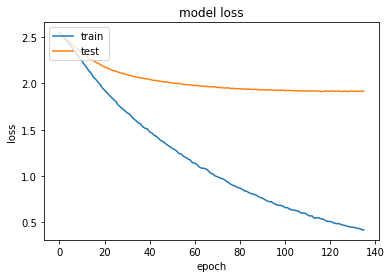

In [18]:
plot_loss()

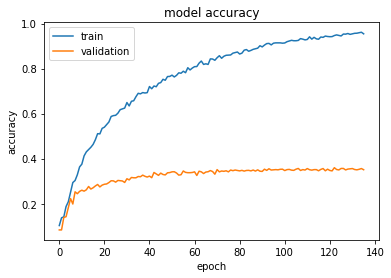

In [24]:
plot_acc()